<a href="https://colab.research.google.com/github/tetsuyayoshino777-coder/customer-targeting-portfolio/blob/main/bank_campaign_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 分析環境の整理

In [ ]:
# 日本語版matplotlibのインストール
!pip install -q japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# 必要なモジュールのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import japanize_matplotlib
from scipy import stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('bmh')

plt.rcParams['figure.figsize'] = 10, 8

In [ ]:
# データセット名：銀行の顧客ターゲティング(学習用データ)
# 取得元： [https://user.competition.signate.jp/ja/competition/detail/?competition=092375ab3c4a43c18c8277e1fd264aa9&task=f3c678327db64f3b988fb85d8a49e5ed&tab=dataset)
# データの内容：定期預金勧誘に関する顧客属性および取引情報

# GitHub公開用の処理
# 実際のSIGNATEデータは公開できないため、サンプルデータを読み込み
# （ローカル環境ではファイルパスを自分の環境に合わせて変更）
file_path = 'data/analytics_report_sample.csv'  # ← 仮想フォルダを想定
df = pd.read_csv(file_path)

# データ確認
df.head()

Mounted at /content/drive


id  age           job  marital  education default  balance housing loan  \
0   1   39   blue-collar  married  secondary      no     1756     yes   no   
1   2   51  entrepreneur  married    primary      no     1443      no   no   
2   3   36    management   single   tertiary      no      436      no   no   
3   4   63       retired  married  secondary      no      474      no   no   
4   5   31    management   single   tertiary      no      354      no   no   

    contact  day month  duration  campaign  pdays  previous poutcome  y  
0  cellular    3   apr       939         1     -1         0  unknown  1  
1  cellular   18   feb       172        10     -1         0  unknown  1  
2  cellular   13   apr       567         1    595         2  failure  1  
3  cellular   25   jan       423         1     -1         0  unknown  1  
4  cellular   30   apr       502         1      9         2  success  1

# ダミーデータ作成

In [ ]:
import numpy as np

# 初期設定
np.random.seed(42)  # 再現性のための乱数シード

# 条件を満たす場合でも成功確率を70%に設定
success_probability = 0.7

# ダミーデータの作成（条件に基づき70%の確率で成功）
df['x'] = np.where(
    (df['age'] >= 30) & (df['balance'] >= 2000) & (df['job'].isin(['management', 'entrepreneur', 'technician'])),
    np.random.choice([1, 0], size=len(df), p=[success_probability, 1 - success_probability]),
    0
)

# y の成功件数に合わせて成功件数を調整
y_success_count = df['y'].sum()
current_x_success_count = df['x'].sum()

if current_x_success_count > 0 and y_success_count > current_x_success_count:
    additional_success_count = y_success_count - current_x_success_count

    # x が 0 のインデックスを取得
    zero_indices = df[df['x'] == 0].index

    # 追加で成功とするインデックスをランダムに選択
    selected_indices = np.random.choice(zero_indices, size=additional_success_count, replace=False)

    # 選択されたインデックスを 1 に変更
    df.loc[selected_indices, 'x'] = 1

# 確認用
df['x'].value_counts()


x
0    23954
1     3174
Name: count, dtype: int64

# メインパート

メインパートでは、以下について記載する。  

0. データ確認と前処理  
1. 代表値の比較  
2. 特徴量重要度分析  
3. クラスタリング分析  
4. シミュレーション（仮）

# 0.データ確認と前処理

In [ ]:
# 欠損値の確認
missing_values = df.isnull().sum()


missing_values

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
x            0
dtype: int64

In [ ]:
# データの型を確認
data_types = df.dtypes
data_types

id            int64
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
x             int64
dtype: object

In [ ]:
# データの基本統計量を確認
summary_stats = df.describe()
summary_stats

id           age        balance           day      duration  \
count  27128.000000  27128.000000   27128.000000  27128.000000  27128.000000   
mean   13564.500000     40.951010    1355.800870     15.806215    260.711295   
std     7831.323388     10.608542    3003.305272      8.337904    260.091727   
min        1.000000     18.000000   -6847.000000      1.000000      0.000000   
25%     6782.750000     33.000000      72.000000      8.000000    104.000000   
50%    13564.500000     39.000000     449.000000     16.000000    182.000000   
75%    20346.250000     48.000000    1428.000000     21.000000    323.000000   
max    27128.000000     95.000000  102127.000000     31.000000   4918.000000   

           campaign         pdays      previous             y             x  
count  27128.000000  27128.000000  27128.000000  27128.000000  27128.000000  
mean       2.751769     40.528052      0.579733      0.117001      0.117001  
std        3.126594    100.382462      2.503653      0.321427      0.321427  
min        1.000000     -1.000000      0.000000      0.000000      0.000000  
25%        1.000000     -1.000000      0.000000      0.000000      0.000000  
50%        2.000000     -1.000000      0.000000      0.000000      0.000000  
75%        3.000000     -1.000000      0.000000      0.000000      0.000000  
max       63.000000    871.000000    275.000000      1.000000      1.000000

## 数値型の変数の傾向（概略）
- age（年齢）
  - 平均値: 40.95歳
  - 最小値: 18歳、最大値: 95歳
  - 中央値: 39歳（四分位範囲: 31〜48歳）
  - 考察: 中央値と平均値が近く、極端に若い/高齢の顧客は少ないと推測。
- balance（口座残高）: 顧客の銀行口座残高（ユーロ）。
  - 平均値: 1,355.80ユーロ
  - 最小値: -6,847ユーロ
  - 最大値: 102,127ユーロ
  - 中央値: 449ユーロ（四分位範囲: 72〜1,428ユーロ）
  - 残高の分布には大きなばらつきがあり、高額な残高の顧客が平均値を引き上げている。
- day（最終接触日）: キャンペーン中、顧客に最後に接触した日（1〜31日）。
  - 平均値: 15.81日
  - 最小値: 1日、最大値: 31日
  - 中央値: 16日（四分位範囲: 8〜21日）
  - 考察: データは月の中旬に集中している可能性が高い。
- duration（最終接触時間（秒））:顧客との通話時間（秒単位）。
  - 平均値: 260.71秒
  - 最小値: 0秒（接触なしの可能性あり）
  - 最大値: 4,918秒（約82分）
  - 中央値: 182秒（四分位範囲: 104〜323秒）
  - 考察: 2～5分程度の通話が多い一方で、一部で非常に長い通話もある。
- campaign（現在のキャンペーンでの接触回数）
  - 平均値: 2.75回
  - 最小値: 1回、最大値: 63回
  - 中央値: 2回（四分位範囲: 1〜3回）
  - 考察: 多くの顧客が1〜3回の接触で、63回という極端な値は稀。
- pdays（最後のキャンペーンからの日数）：前回のキャンペーン接触からの日数
  - 平均値: 40.53日
  - 最小値: -1日
  - 最大値: 871日
  - 中央値：-1日（四分位範囲:-1日〜-1日）
  - 考察: -1が多くを占めており、分布が偏っている。-1日は未接触を意味している可能性あり
- previous（接触実績：現キャンペーン以前までに顧客に接触した回数）
  - 平均値: 0.58回
  - 最小値: 0回
  - 最大値: 275回
  - 中央値：0回（四分位範囲:0回〜0回）
  - 考察: 大半の顧客は過去に接触した回数が少なく、接触回数が多い顧客は稀です。
- y（定額預金の申し込み成功）:定額預金キャンペーンの成功フラグ
  - 成功率: 約11.7%
- x（NISA口座開設成功）:NISA口座開設キャンペーンの成功フラグ
  - 成功率: 約11.7%

## オブジェクト型変数の傾向（概略）

In [ ]:
df.describe(include=['O'])

job  marital  education default housing   loan   contact  \
count         27128    27128      27128   27128   27128  27128     27128   
unique           12        3          4       2       2      2         3   
top     blue-collar  married  secondary      no     yes     no  cellular   
freq           5886    16411      13882   26644   15125  22788     17580   

        month poutcome  
count   27128    27128  
unique     12        4  
top       may  unknown  
freq     8317    22150

- default(債務不履行があるか)は大半がno
- loan(個人ローン)は大半がno
- poutcome(前回のキャンペーンの成果)の大半がunknown

In [ ]:
# オブジェクト型変数を抽出
object_columns = df.select_dtypes(include=['object']).columns

# オブジェクト型変数の該当数と構成割合を計算
object_stats = []

for col in object_columns:
    value_counts = df[col].value_counts()  # 該当数を計算
    percentages = (value_counts / len(df)) * 100  # 構成割合を計算
    stats = pd.DataFrame({
        'Value': value_counts.index,       # 該当値
        'Count': value_counts.values,     # 該当数
        'Percentage': percentages.values  # 構成割合
    })
    stats['Column'] = col  # 変数名を追加
    object_stats.append(stats)

# 全てのオブジェクト型変数の結果を結合
object_stats_df = pd.concat(object_stats, ignore_index=True)

In [ ]:
# jobの分布状況を確認
object_stats_df[object_stats_df['Column'] == 'job']

Value  Count  Percentage Column
0     blue-collar   5886   21.697139    job
1      management   5620   20.716603    job
2      technician   4491   16.554851    job
3          admin.   3085   11.372014    job
4        services   2506    9.237688    job
5         retired   1391    5.127543    job
6   self-employed    945    3.483486    job
7    entrepreneur    914    3.369213    job
8      unemployed    790    2.912120    job
9       housemaid    765    2.819965    job
10        student    557    2.053229    job
11        unknown    178    0.656149    job

- 「blue-collar（労働者）」と「management（管理職）」が最も多く、それぞれ約20%を占めている。
- 一方で「unknown（不明）」の割合は少ないため、職業データは比較的信頼性が高いと考えられる。

In [ ]:
# maritalの分布状況を確認
object_stats_df[object_stats_df['Column'] == 'marital']

Value  Count  Percentage   Column
12   married  16411   60.494692  marital
13    single   7662   28.243881  marital
14  divorced   3055   11.261427  marital

- 「married（既婚者）」が全体の60%以上を占めており、最も多い。「divorced（離婚）」は最も少ない。

In [ ]:
# educationの分布状況を確認
object_stats_df[object_stats_df['Column'] == 'education']

Value  Count  Percentage     Column
15  secondary  13882   51.172221  education
16   tertiary   7959   29.338691  education
17    primary   4150   15.297847  education
18    unknown   1137    4.191242  education

- 「secondary（中等教育修了）」の顧客が半数以上を占めています。
- 「unknown（不明）」は約4%と少ないため、データは比較的信頼性が高いと考えられる。

In [ ]:
# default（債務不履行の有無）の分布状況を確認
object_stats_df[object_stats_df['Column'] == 'default']

Value  Count  Percentage   Column
19    no  26644   98.215866  default
20   yes    484    1.784134  default

- 「債務不履行なし（no）」の顧客が圧倒的多数を占めている。このため、債務不履行の有無が分析に与える影響は限定的と考えられる。

In [ ]:
# housing（住宅ローンの有無）の分布状況を確認
object_stats_df[object_stats_df['Column'] == 'housing']

Value  Count  Percentage   Column
21   yes  15125   55.754202  housing
22    no  12003   44.245798  housing

- 「住宅ローンあり（yes）」の顧客が若干多いですが、ほぼ半々の分布。

In [ ]:
# loan（個人ローンの有無）の分布状況を確認
object_stats_df[object_stats_df['Column'] == 'loan']

Value  Count  Percentage Column
23    no  22788   84.001769   loan
24   yes   4340   15.998231   loan

- 「個人ローンなし（no）」の顧客が大半を占めている。

In [ ]:
# contact（連絡方法）の分布状況を確認
object_stats_df[object_stats_df['Column'] == 'contact']

Value  Count  Percentage   Column
25   cellular  17580   64.803893  contact
26    unknown   7861   28.977440  contact
27  telephone   1687    6.218667  contact

- 「cellular（携帯電話）」が主な連絡手段。
- 「unknown（不明）」が約29%あるため、データの補完や解釈に注意が必要。

In [ ]:
# month（最後の接触月）の分布状況を確認
object_stats_df[object_stats_df['Column'] == 'month']

Value  Count  Percentage Column
28   may   8317   30.658360  month
29   jul   4136   15.246240  month
30   aug   3718   13.705397  month
31   jun   3204   11.810675  month
32   nov   2342    8.633147  month
33   apr   1755    6.469331  month
34   feb   1586    5.846358  month
35   jan    846    3.118549  month
36   oct    439    1.618254  month
37   sep    356    1.312297  month
38   mar    299    1.102182  month
39   dec    130    0.479210  month

- 5月（may）が最も多く、キャンペーン活動の集中時期のもよう。

In [ ]:
# poutcome（前回のキャンペーン結果）の分布状況を確認
object_stats_df[object_stats_df['Column'] == 'poutcome']

Value  Count  Percentage    Column
40  unknown  22150   81.649956  poutcome
41  failure   2969   10.944412  poutcome
42    other   1123    4.139634  poutcome
43  success    886    3.265998  poutcome

- 「unknown（不明）」が81%を占め、過去の結果が不明な顧客が多数派。
- 「success（成功）」のデータは少数だが、重要な情報を含む可能性あり。

# 1.代表値の比較

## 1-1.数値型変数の傾向確認

In [ ]:
# 変数の傾向をALL、y=1（定額預金申し込み成功）、 x=1（NISA口座開設成功）の3分類ごとに確認
# y=1（定額預金申し込み成功）と x=1（NISA口座開設成功）のデータを抽出
y_success = df[df['y'] == 1]
x_success = df[df['x'] == 1]

# 数値型変数の統計量
y_success_stats = y_success.describe()
x_success_stats = x_success.describe()

# オブジェクト型変数の分布
y_success_object_stats = {col: y_success[col].value_counts(normalize=True) for col in object_columns}
x_success_object_stats = {col: x_success[col].value_counts(normalize=True) for col in object_columns}


In [ ]:
# 全体データの統計量
overall_stats = df.describe()

# y=1, x=1, 全体データの統計量を比較しやすい形に整備
comparison_stats = pd.concat(
    {
        'Overall': overall_stats,
        'y=1': y_success_stats,
        'x=1': x_success_stats
    },
    axis=1
)

# 数値型変数の比較を一つ一つ記載するため、統計量を整える
numeric_comparison = comparison_stats[['Overall', 'y=1', 'x=1']]
numeric_comparison


Overall                                                           \
                 id           age        balance           day      duration   
count  27128.000000  27128.000000   27128.000000  27128.000000  27128.000000   
mean   13564.500000     40.951010    1355.800870     15.806215    260.711295   
std     7831.323388     10.608542    3003.305272      8.337904    260.091727   
min        1.000000     18.000000   -6847.000000      1.000000      0.000000   
25%     6782.750000     33.000000      72.000000      8.000000    104.000000   
50%    13564.500000     39.000000     449.000000     16.000000    182.000000   
75%    20346.250000     48.000000    1428.000000     21.000000    323.000000   
max    27128.000000     95.000000  102127.000000     31.000000   4918.000000   

                                                                             \
           campaign         pdays      previous             y             x   
count  27128.000000  27128.000000  27128.000000  27128.000000  27128.000000   
mean       2.751769     40.528052      0.579733      0.117001      0.117001   
std        3.126594    100.382462      2.503653      0.321427      0.321427   
min        1.000000     -1.000000      0.000000      0.000000      0.000000   
25%        1.000000     -1.000000      0.000000      0.000000      0.000000   
50%        2.000000     -1.000000      0.000000      0.000000      0.000000   
75%        3.000000     -1.000000      0.000000      0.000000      0.000000   
max       63.000000    871.000000    275.000000      1.000000      1.000000   

       ...           x=1                                           \
       ...            id          age        balance          day   
count  ...   3174.000000  3174.000000    3174.000000  3174.000000   
mean   ...  13703.971330    41.572149    3383.791745    15.869880   
std    ...   7856.506358    10.086405    5492.765972     8.149588   
min    ...     29.000000    19.000000   -2082.000000     1.000000   
25%    ...   6915.750000    33.000000     301.250000     9.000000   
50%    ...  13788.500000    40.000000    2205.000000    16.000000   
75%    ...  20522.000000    49.000000    4135.750000    21.000000   
max    ...  27122.000000    86.000000  102127.000000    31.000000   

                                                                                
          duration     campaign        pdays     previous            y       x  
count  3174.000000  3174.000000  3174.000000  3174.000000  3174.000000  3174.0  
mean    266.925961     2.766856    40.744486     0.610586     0.134531     1.0  
std     271.851413     3.223450    97.383830     1.809096     0.341275     0.0  
min       0.000000     1.000000    -1.000000     0.000000     0.000000     1.0  
25%     104.250000     1.000000    -1.000000     0.000000     0.000000     1.0  
50%     185.000000     2.000000    -1.000000     0.000000     0.000000     1.0  
75%     325.750000     3.000000    -1.000000     0.000000     0.000000     1.0  
max    4918.000000    63.000000   831.000000    29.000000     1.000000     1.0  

[8 rows x 30 columns]

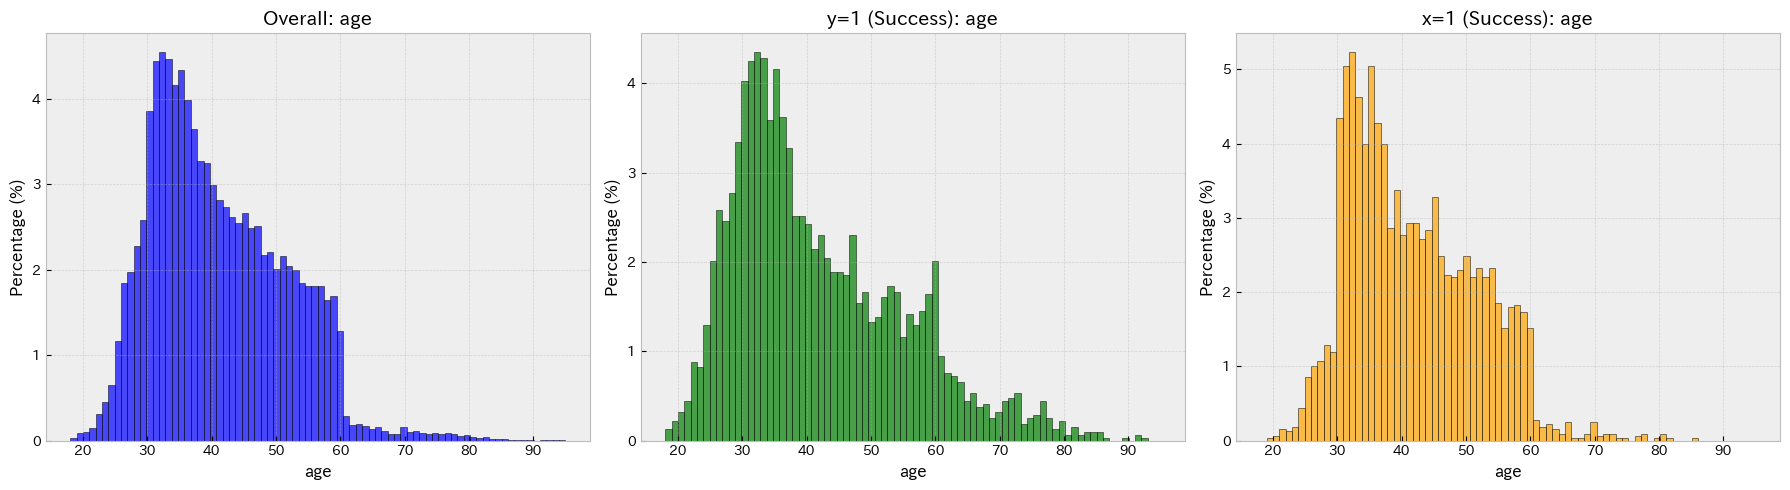

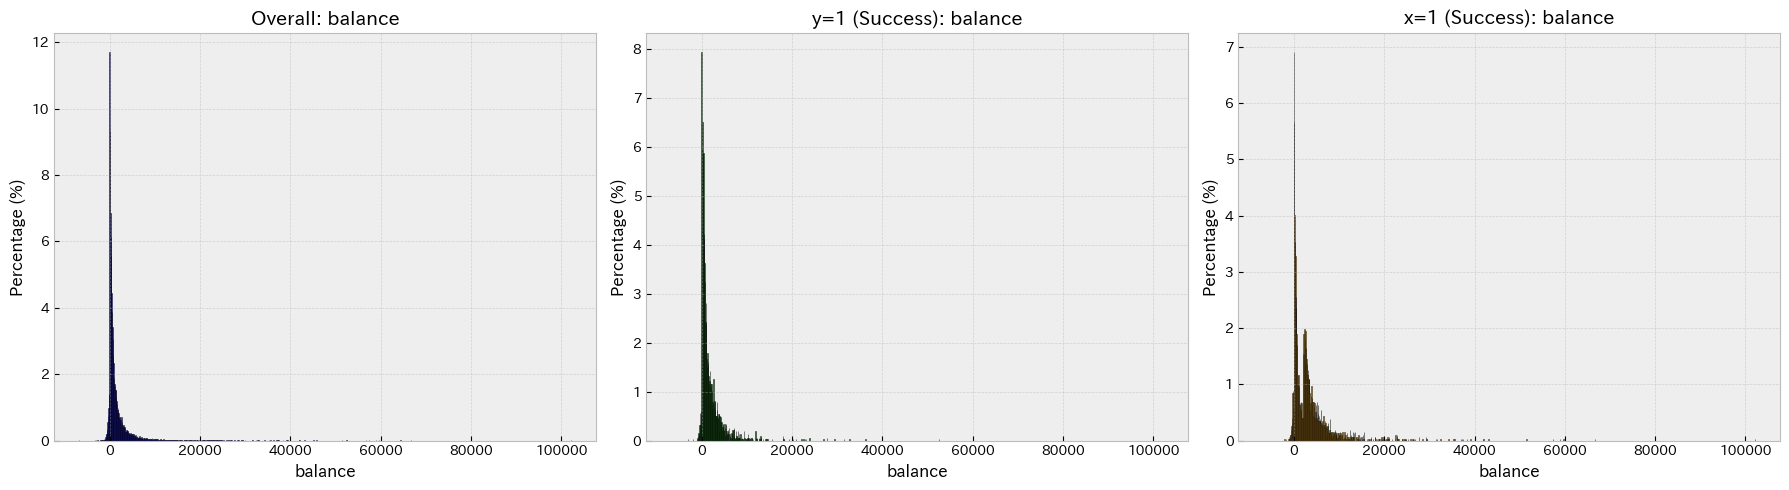

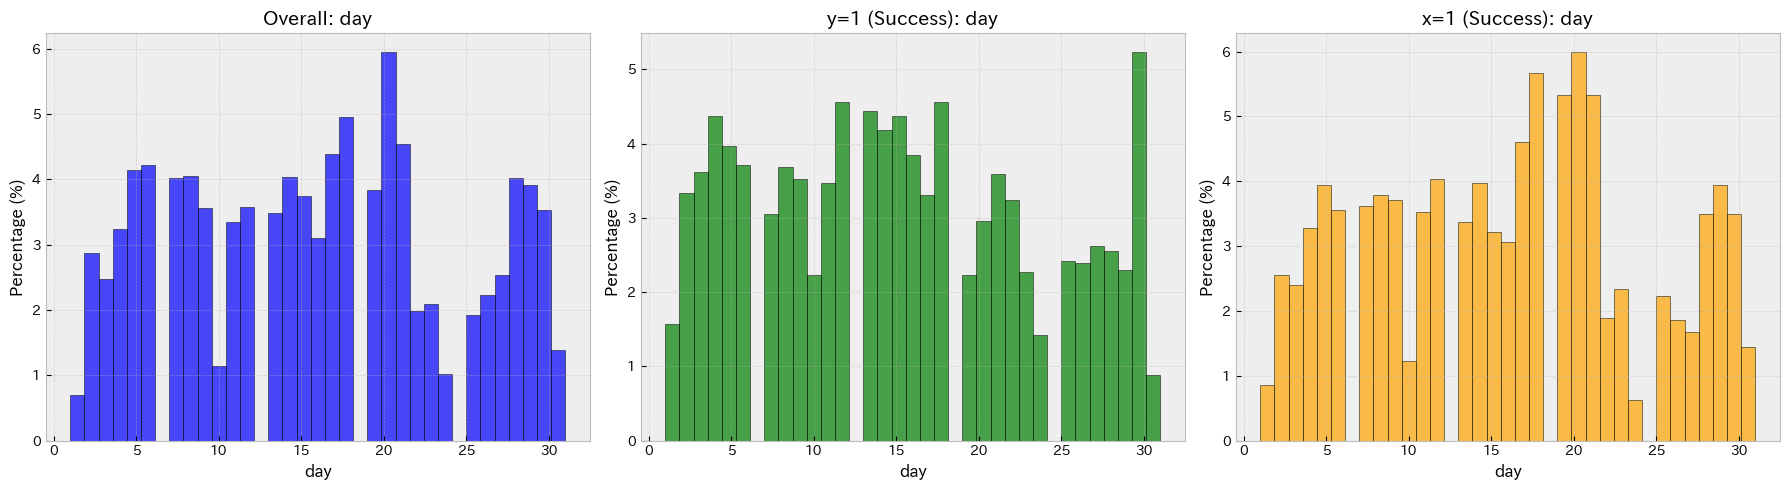

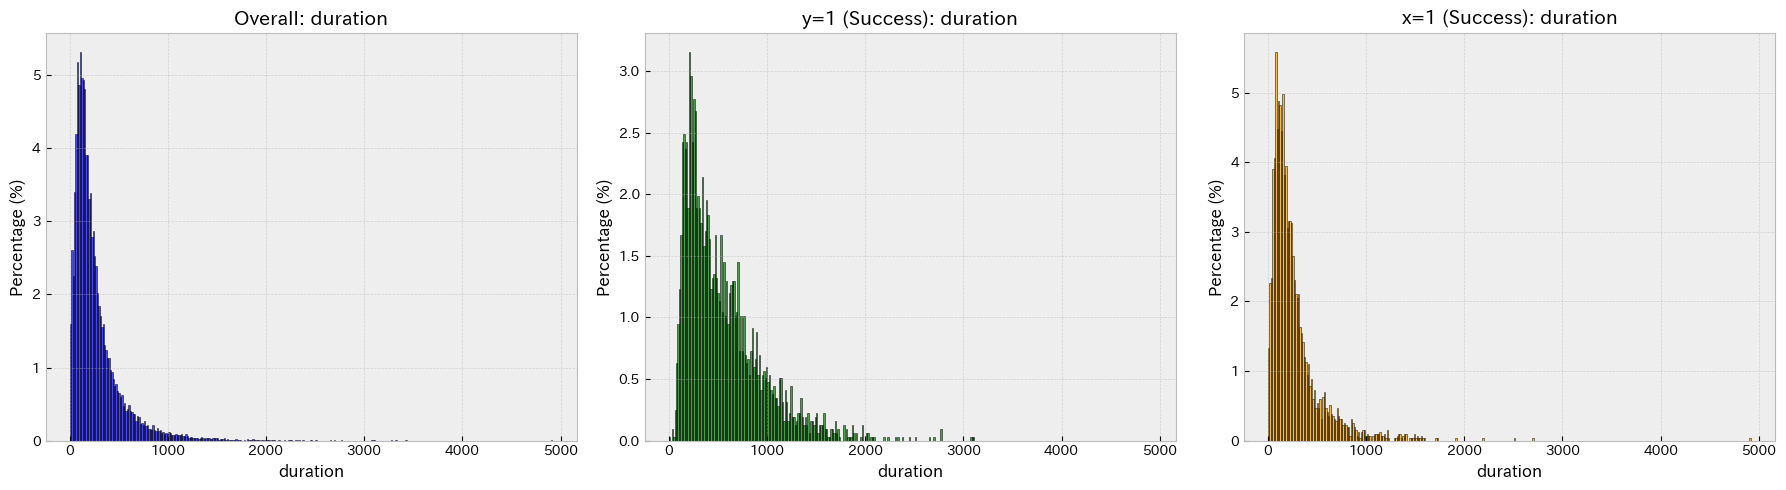

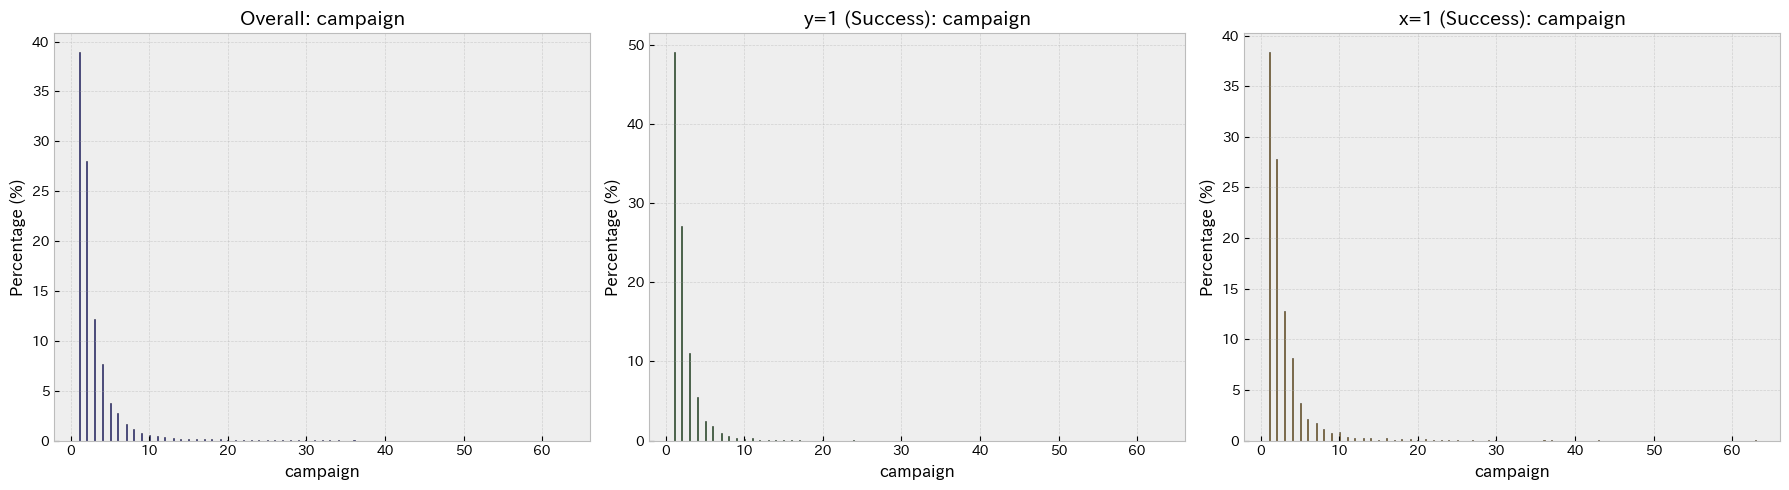

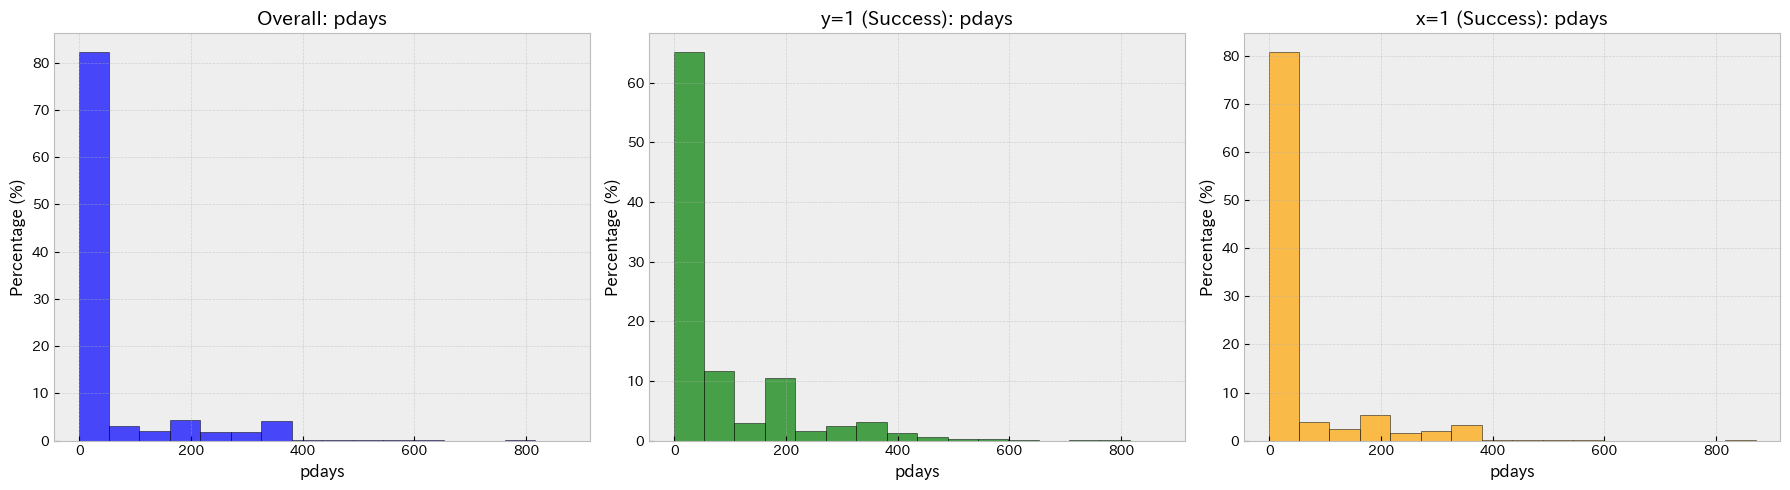

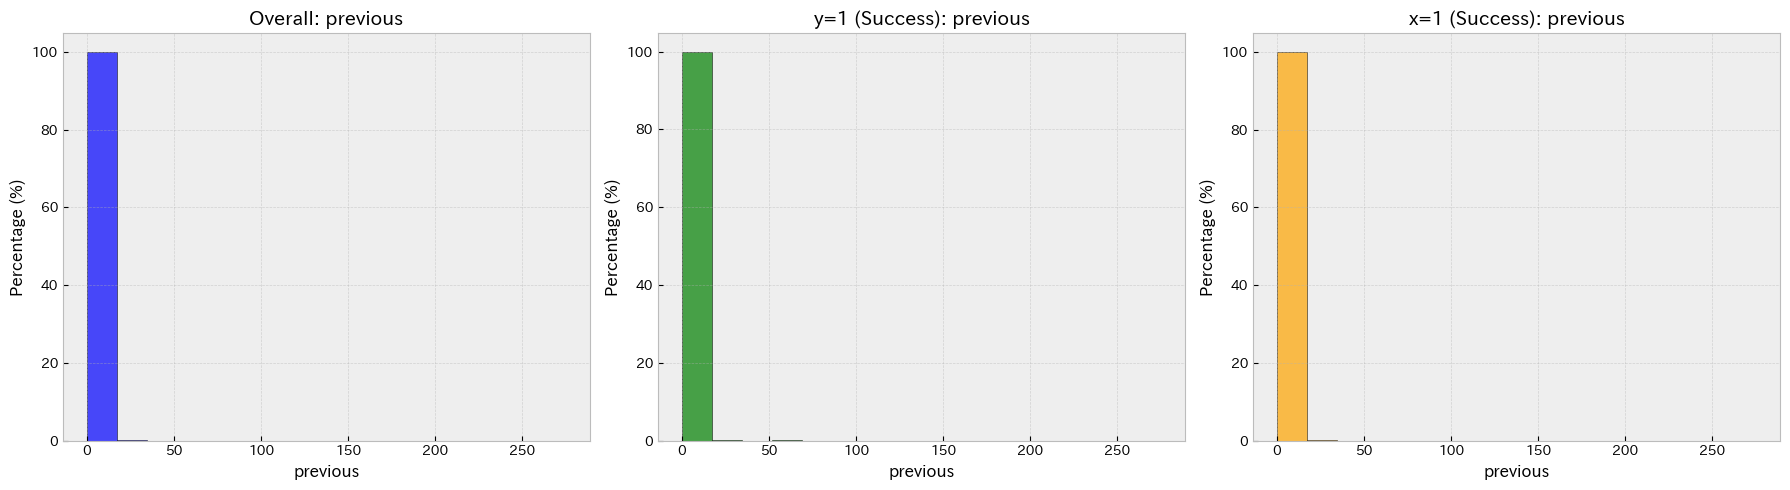

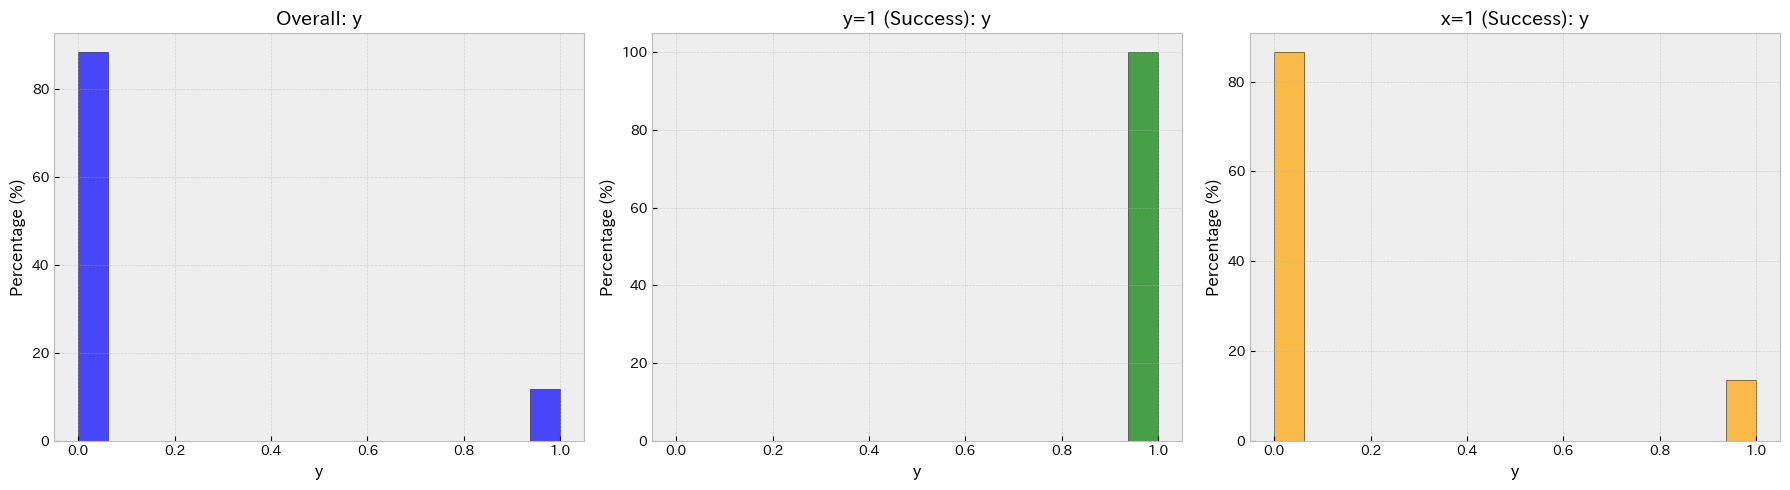

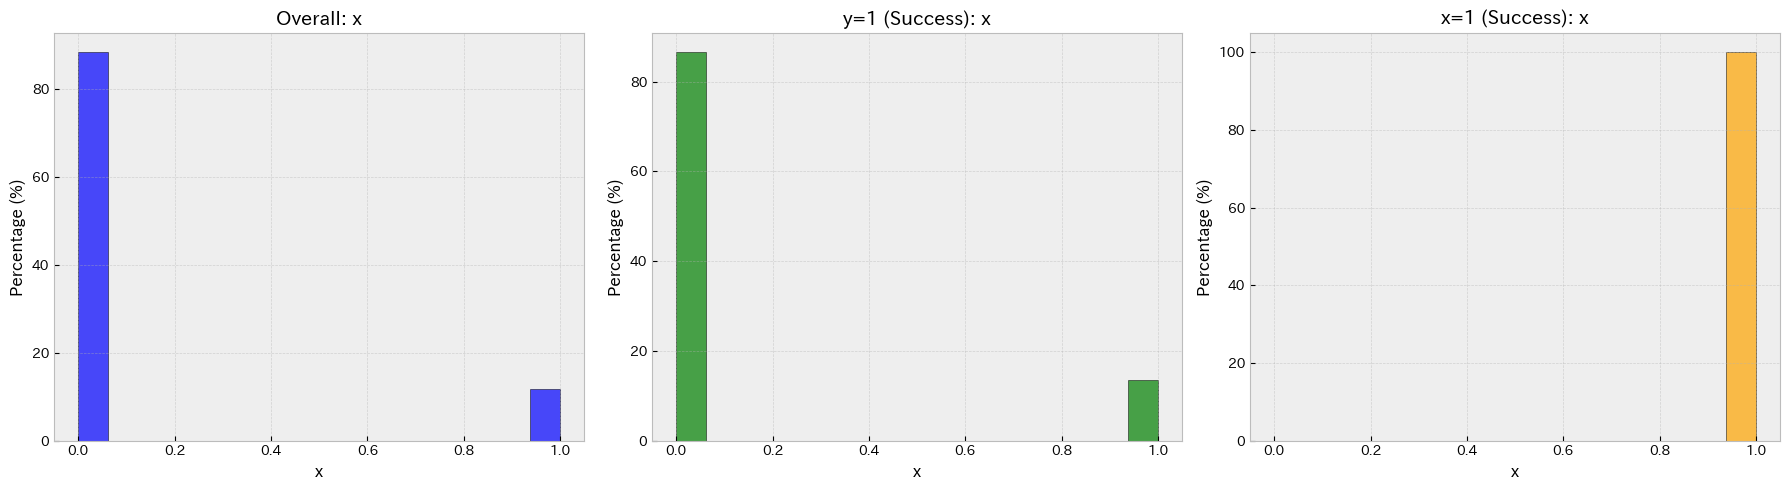

In [ ]:
# 数値型の列を取得
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

# IDを除外した数値型変数リストを作成
numeric_columns_filtered = [col for col in numeric_columns if col not in ['id']]

# ヒストグラムを横3つに並べて描画する関数（ビン数調整版）
def plot_percentage_histograms_separate(column):
    plt.figure(figsize=(18, 5))

    # 全体の分布
    overall_counts, bins = np.histogram(df[column], bins='auto')  # 自動でビンを設定
    overall_percentage = overall_counts / len(df) * 100
    plt.subplot(1, 3, 1)
    plt.bar(bins[:-1], overall_percentage, width=np.diff(bins), alpha=0.7, color='blue', edgecolor='black', align='edge')
    plt.title(f'Overall: {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.grid(alpha=0.5)

    # y=1の分布
    y_counts, _ = np.histogram(y_success[column], bins=bins)  # 同じビン設定を使用
    y_percentage = y_counts / len(y_success) * 100
    plt.subplot(1, 3, 2)
    plt.bar(bins[:-1], y_percentage, width=np.diff(bins), alpha=0.7, color='green', edgecolor='black', align='edge')
    plt.title(f'y=1 (Success): {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.grid(alpha=0.5)

    # x=1の分布
    x_counts, _ = np.histogram(x_success[column], bins=bins)  # 同じビン設定を使用
    x_percentage = x_counts / len(x_success) * 100
    plt.subplot(1, 3, 3)
    plt.bar(bins[:-1], x_percentage, width=np.diff(bins), alpha=0.7, color='orange', edgecolor='black', align='edge')
    plt.title(f'x=1 (Success): {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.grid(alpha=0.5)

    plt.tight_layout()
    plt.show()

# フィルタリングした数値型変数についてヒストグラムを作成
for col in numeric_columns_filtered:
    plot_percentage_histograms_separate(col)


### 数値型の変数の傾向まとめ
- age（年齢）
  - 年齢層は広く分布しており、30代から50代が中心。
  - y=1(定額預金)は比較的年齢層の幅が他の分類と比して広い。

- balance（口座残高）: 顧客の銀行口座残高（ユーロ）。
  - 全体: 残高が0より低い分布が最も多く、y=1、x=1の傾向と異なる
  - y=1: 全体より残高が高い傾向があり、特に1,000〜3,000ユーロの顧客が多い。
  - x=1: y=1と同様に1,000〜3,000ユーロの顧客が多いが、5,000ユーロ以上の割合が他と比して高い

- day（最終接触日）: キャンペーン中、顧客に最後に接触した日（1〜31日）。
  - 全体およびx=1: 月の中旬（15日前後）が多い。初日（1日）や月末（30日以降）も一定の頻度。
  - y=1: 月末の顧客が多い。

- duration（最終接触時間（秒））:顧客との通話時間（秒単位）。
  - 全体では通話時間は100〜300秒が中心で、一部で長い通話が存在。
  - x=1も全体と同様の傾向。
  - y=1では通話時間が長いほど成功率が高く、500秒以上の割合が顕著に高い。

- campaign（現在のキャンペーンでの接触回数）
  - いずれの分類においても、0回が最も多い。
  - 全体およびx-1は、0回の割合が80％程度。
  - y=1では0回の割合が65%程度であり、他の分類と比して0ではないケースが多い。

- pdays（最後のキャンペーンからの日数）：前回のキャンペーン接触からの平日数
  - -1（推定：未接触）が最も多いはずが、ヒストグラムの描画上、表現できていないため、要修正

- previous（接触実績：現キャンペーン以前までに顧客に接触した回数）
  - 過去の接触回数が0回の顧客が大多数を占める。
  - 分布上、分類ごとの違いはみうけられない

- 目的変数)y,x)
  - y,xともに、それぞれの目的変数のみで成功している（=1である）顧客は85％程度であり、15％はy,xともに成功している。

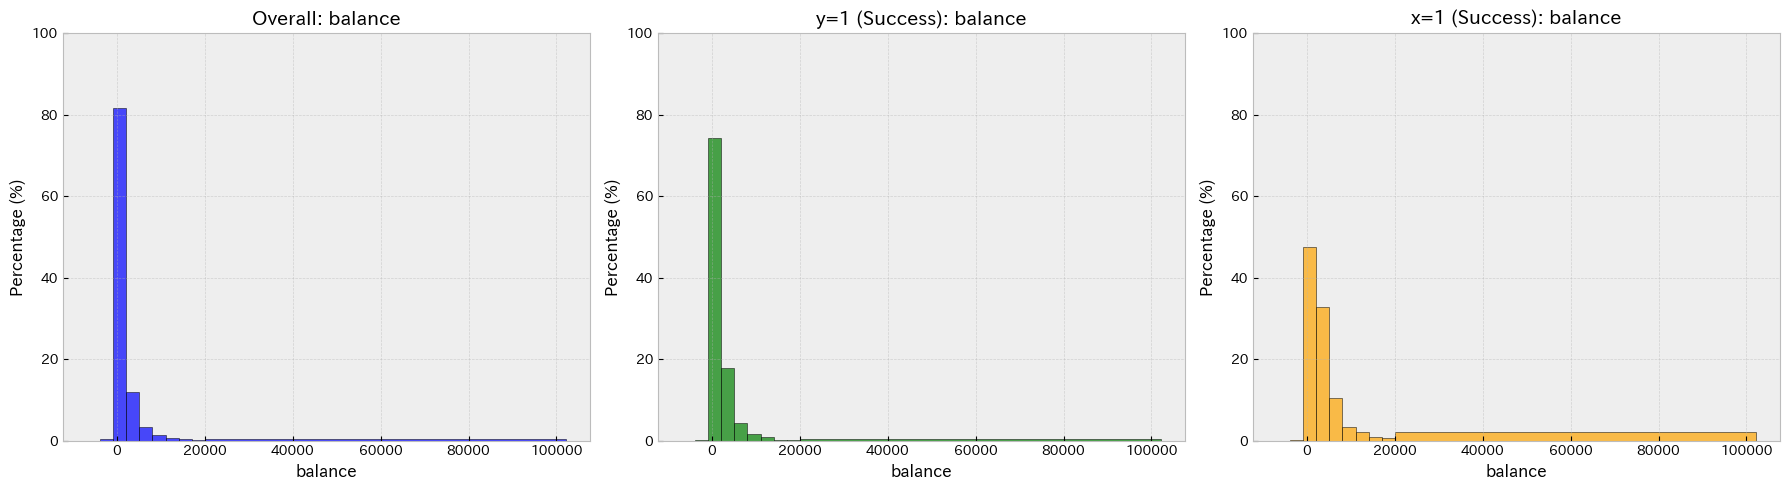

In [ ]:
# balance のヒストグラムを横3つに並べて描画する関数（縦軸を100％に固定）
def plot_balance_histogram():
    column = 'balance'

    # ビンの範囲を手動で設定（20,000以上を一括りにする）
    max_value = 20000
    bins = np.append(np.linspace(df[column].min(), max_value, 10), df[column].max())  # 等間隔ビンと最大値を一括り

    plt.figure(figsize=(18, 5))

    # 全体の分布
    overall_counts, _ = np.histogram(df[column], bins=bins)
    overall_percentage = overall_counts / len(df) * 100
    plt.subplot(1, 3, 1)
    plt.bar(bins[:-1], overall_percentage, width=np.diff(bins), alpha=0.7, color='blue', edgecolor='black', align='edge')
    plt.title(f'Overall: {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.ylim(0, 100)  # 縦軸を100％に固定
    plt.grid(alpha=0.5)

    # y=1の分布
    y_counts, _ = np.histogram(y_success[column], bins=bins)
    y_percentage = y_counts / len(y_success) * 100
    plt.subplot(1, 3, 2)
    plt.bar(bins[:-1], y_percentage, width=np.diff(bins), alpha=0.7, color='green', edgecolor='black', align='edge')
    plt.title(f'y=1 (Success): {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.ylim(0, 100)  # 縦軸を100％に固定
    plt.grid(alpha=0.5)

    # x=1の分布
    x_counts, _ = np.histogram(x_success[column], bins=bins)
    x_percentage = x_counts / len(x_success) * 100
    plt.subplot(1, 3, 3)
    plt.bar(bins[:-1], x_percentage, width=np.diff(bins), alpha=0.7, color='orange', edgecolor='black', align='edge')
    plt.title(f'x=1 (Success): {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.ylim(0, 100)  # 縦軸を100％に固定
    plt.grid(alpha=0.5)

    plt.tight_layout()
    plt.show()

# balance のヒストグラムを作成
plot_balance_histogram()


- balanceについて、x=1の分布は右側に偏っていることを再確認

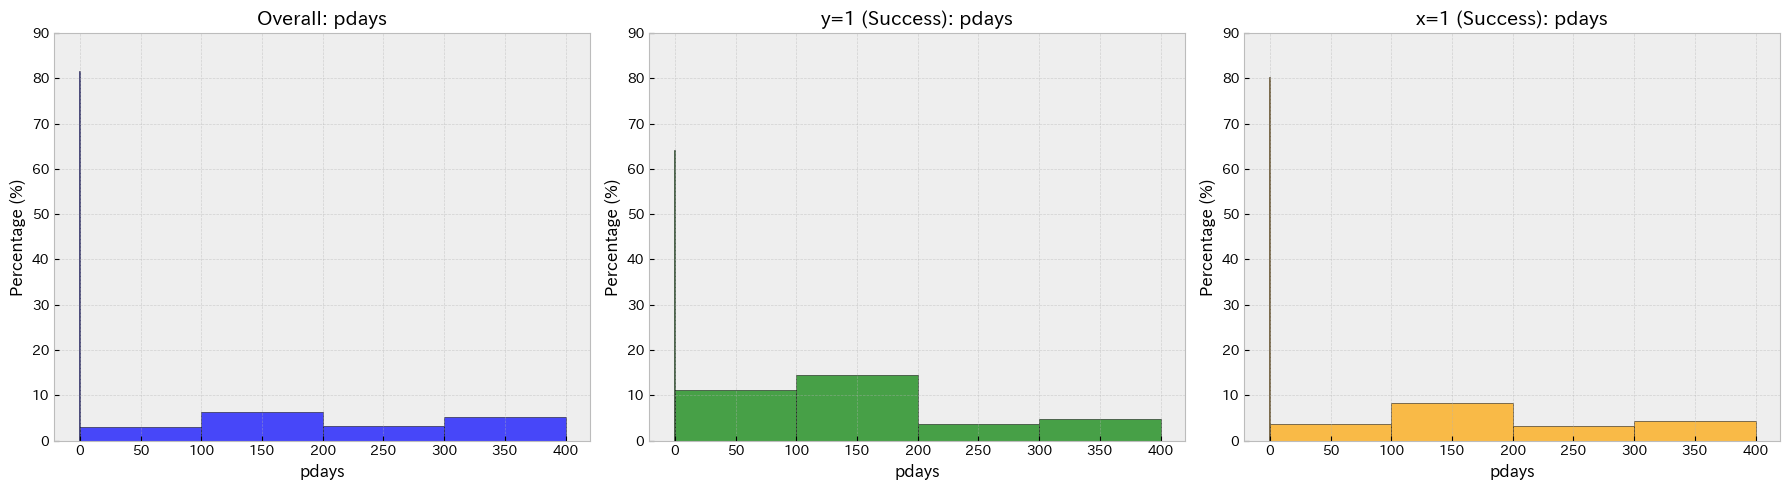

In [ ]:
# ヒストグラムを横3つに並べて描画する関数（pdays専用、手動ビン設定、縦軸90％固定）
def plot_pdays_histogram():
    column = 'pdays'
    # 手動でビンの境界を設定（-1を個別に扱い、それ以外を等間隔で設定）
    bins = [-1, 0, 100, 200, 300, 400]

    plt.figure(figsize=(18, 5))

    # 全体の分布
    overall_counts, _ = np.histogram(df[column], bins=bins)
    overall_percentage = overall_counts / len(df) * 100
    plt.subplot(1, 3, 1)
    plt.bar(bins[:-1], overall_percentage, width=np.diff(bins), alpha=0.7, color='blue', edgecolor='black', align='edge')
    plt.title(f'Overall: {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.ylim(0, 90)  # 縦軸を90％に固定
    plt.grid(alpha=0.5)

    # y=1の分布
    y_counts, _ = np.histogram(y_success[column], bins=bins)
    y_percentage = y_counts / len(y_success) * 100
    plt.subplot(1, 3, 2)
    plt.bar(bins[:-1], y_percentage, width=np.diff(bins), alpha=0.7, color='green', edgecolor='black', align='edge')
    plt.title(f'y=1 (Success): {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.ylim(0, 90)  # 縦軸を90％に固定
    plt.grid(alpha=0.5)

    # x=1の分布
    x_counts, _ = np.histogram(x_success[column], bins=bins)
    x_percentage = x_counts / len(x_success) * 100
    plt.subplot(1, 3, 3)
    plt.bar(bins[:-1], x_percentage, width=np.diff(bins), alpha=0.7, color='orange', edgecolor='black', align='edge')
    plt.title(f'x=1 (Success): {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.ylim(0, 90)  # 縦軸を90％に固定
    plt.grid(alpha=0.5)

    plt.tight_layout()
    plt.show()

# pdays のヒストグラムを描画
plot_pdays_histogram()


### 分類別の傾向まとめ
- 定額預金（y=1）が成功しやすい傾向
 - 中程度の口座残高（1,000〜3,000ユーロ）
 - 長い通話時間（500秒以上）
 - 少ない接触回数（1〜2回）
 - 過去に接触経験がある顧客

- NISA口座（x=1）が成功しやすい傾向
 - 高額口座残高（5,000ユーロ以上）
 - 年齢層が高い（30代後半〜60代）
 - 過去の接触がなくても成功しやすい

### 補足:箱ひげ図による数値型変数の比較
- ヒストグラムにおいて確認した傾向と大きな違いはみられない。

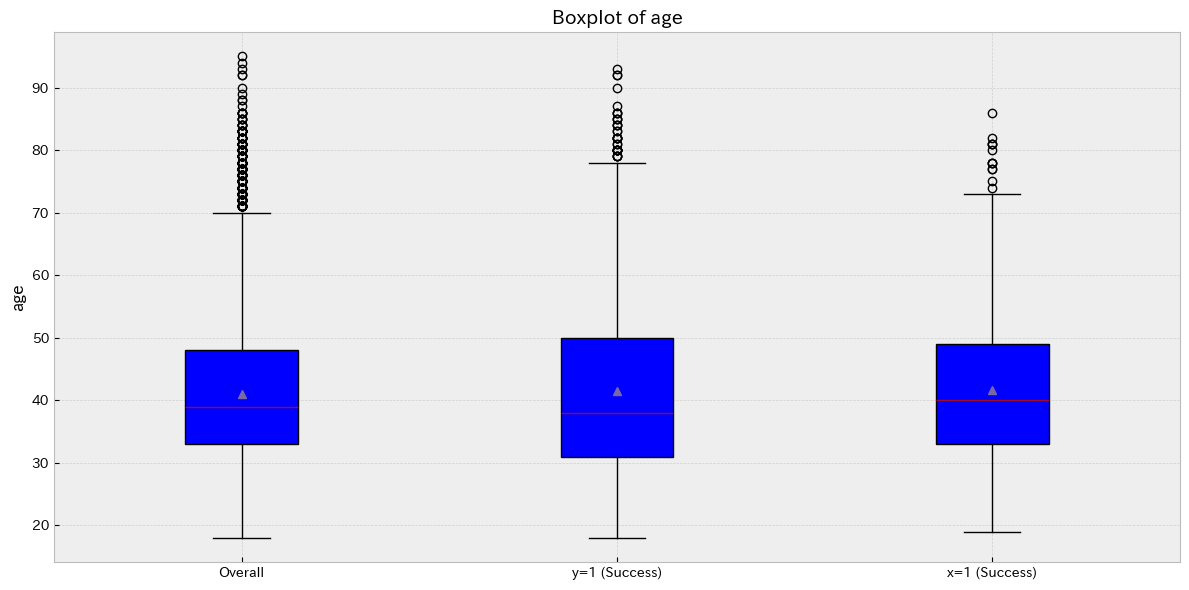

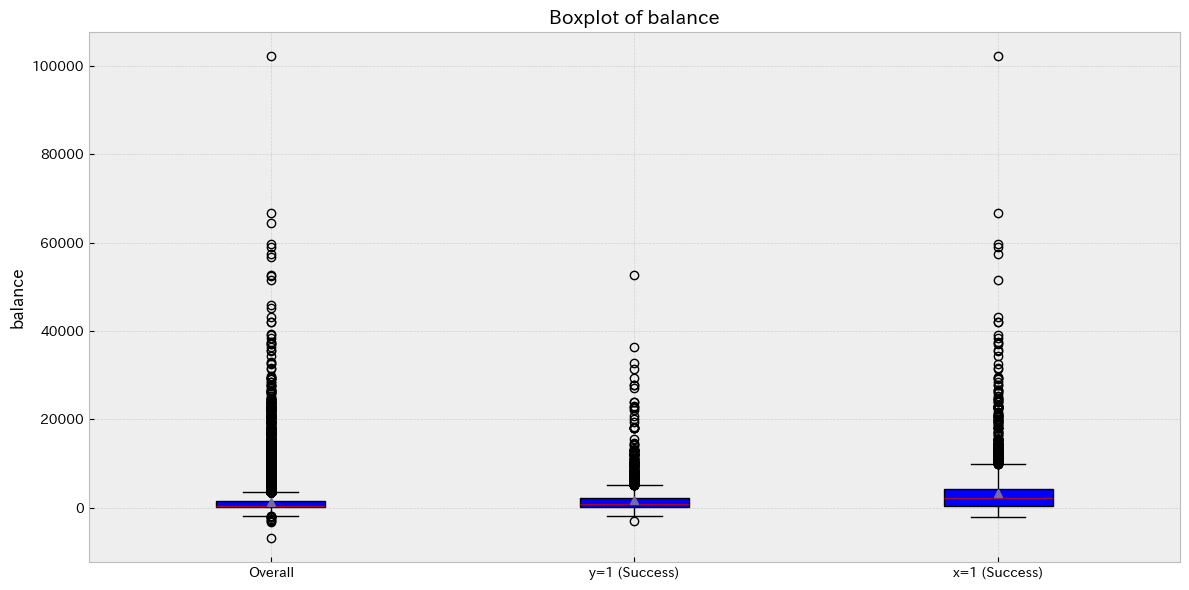

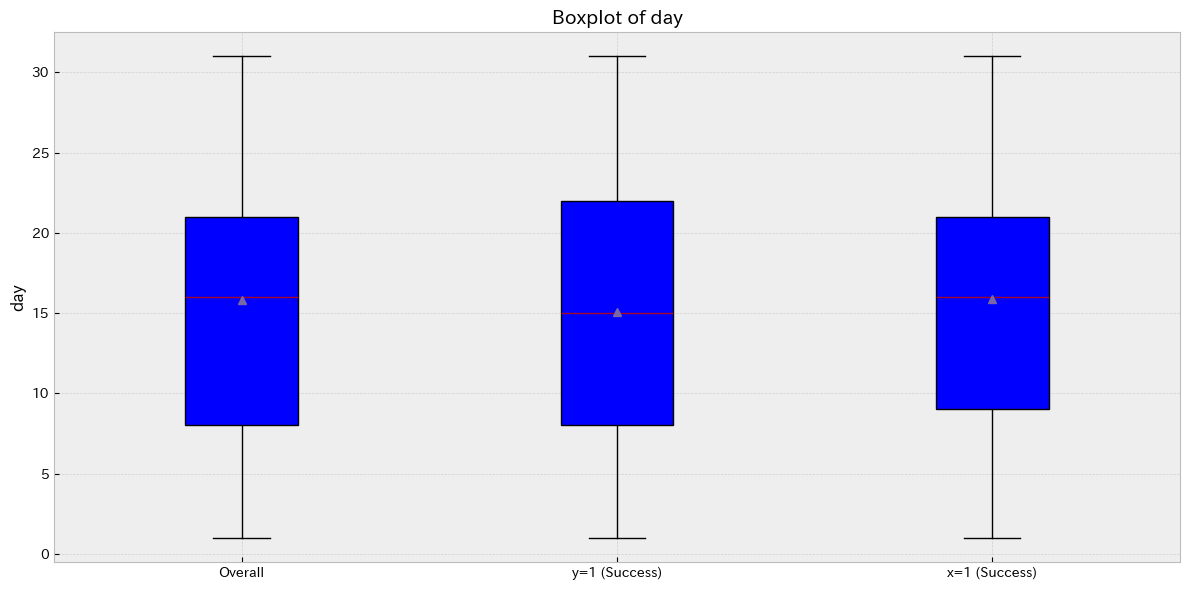

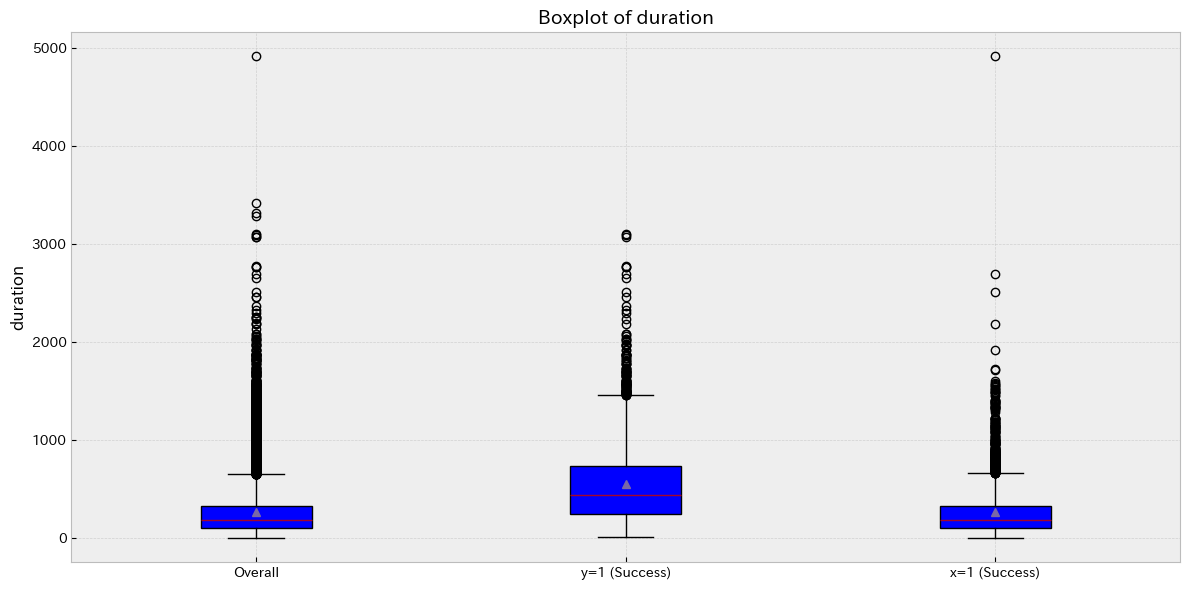

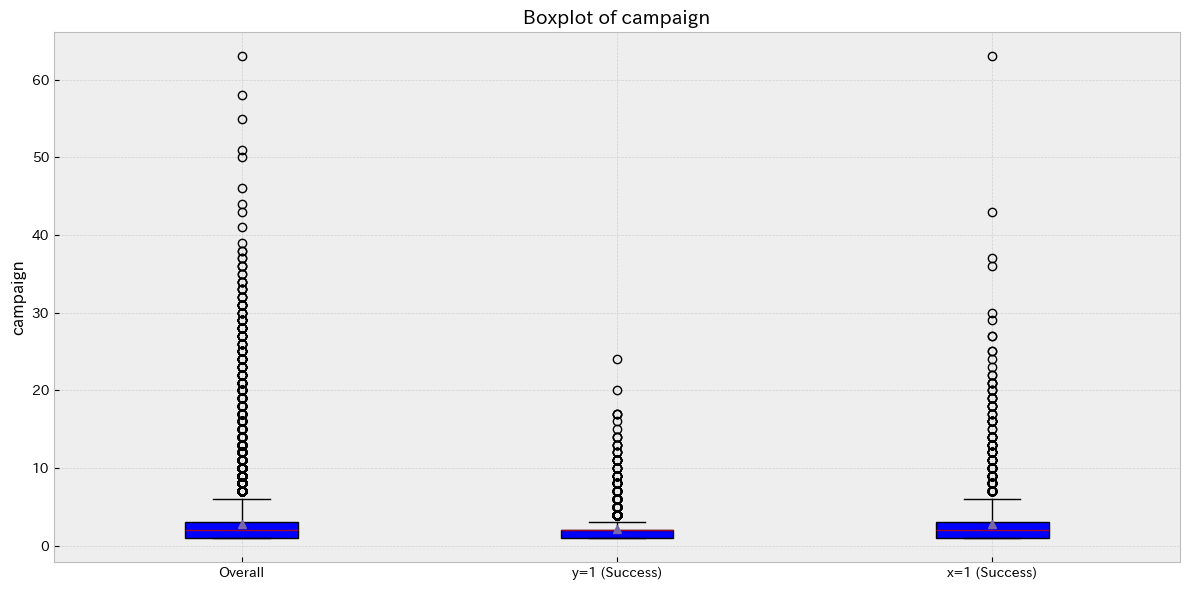

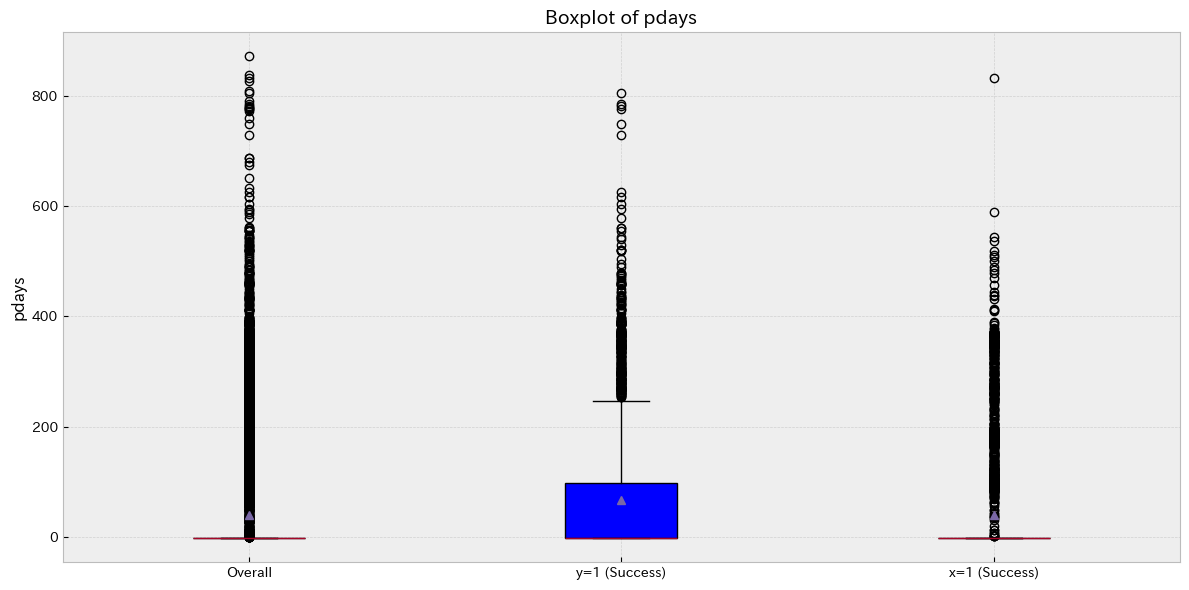

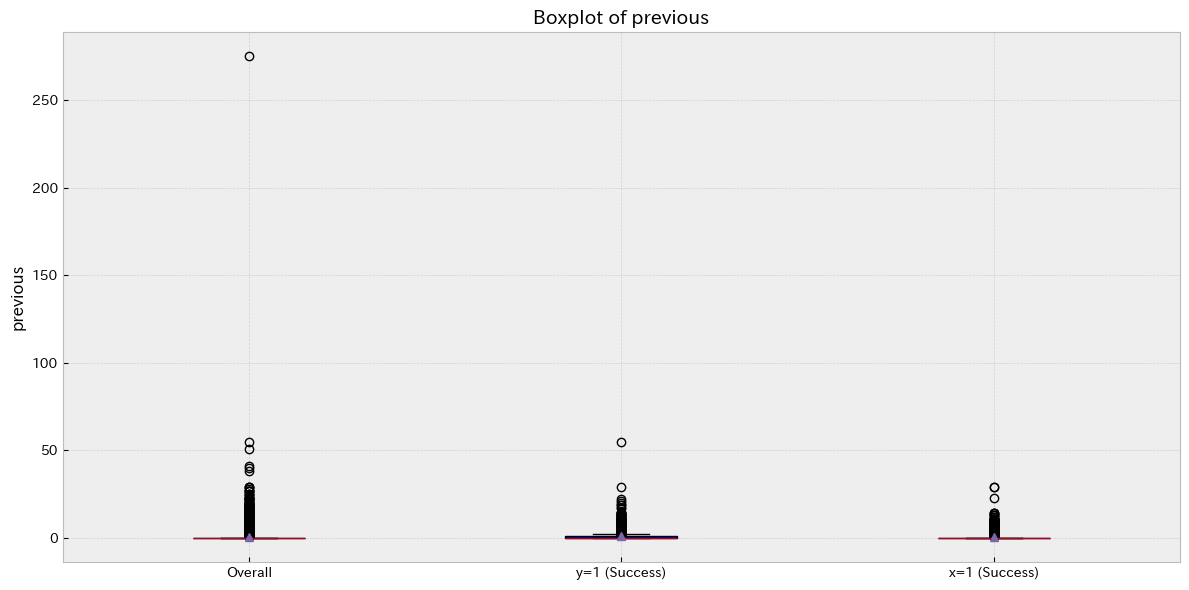

In [ ]:
# 数値型変数の箱ひげ図を作成する関数
def plot_boxplots(columns, df, y_success, x_success):
    for column in columns:
        plt.figure(figsize=(12, 6))

        # 箱ひげ図のデータ準備
        data = [
            df[column],
            y_success[column],
            x_success[column]
        ]
        labels = ['Overall', 'y=1 (Success)', 'x=1 (Success)']

        # 箱ひげ図の描画
        plt.boxplot(data, labels=labels, patch_artist=True, showmeans=True)
        plt.title(f'Boxplot of {column}', fontsize=14)
        plt.ylabel(column, fontsize=12)
        plt.grid(alpha=0.5)
        plt.tight_layout()
        plt.show()

# ID, x, yを除外した数値型変数リストを作成
numeric_columns_filtered = [col for col in numeric_columns if col not in ['id', 'x', 'y']]

# 数値型変数の箱ひげ図を作成
plot_boxplots(numeric_columns_filtered, df, y_success, x_success)


## 1-2.オブジェクト型変数の傾向確認

<Figure size 1200x600 with 0 Axes>

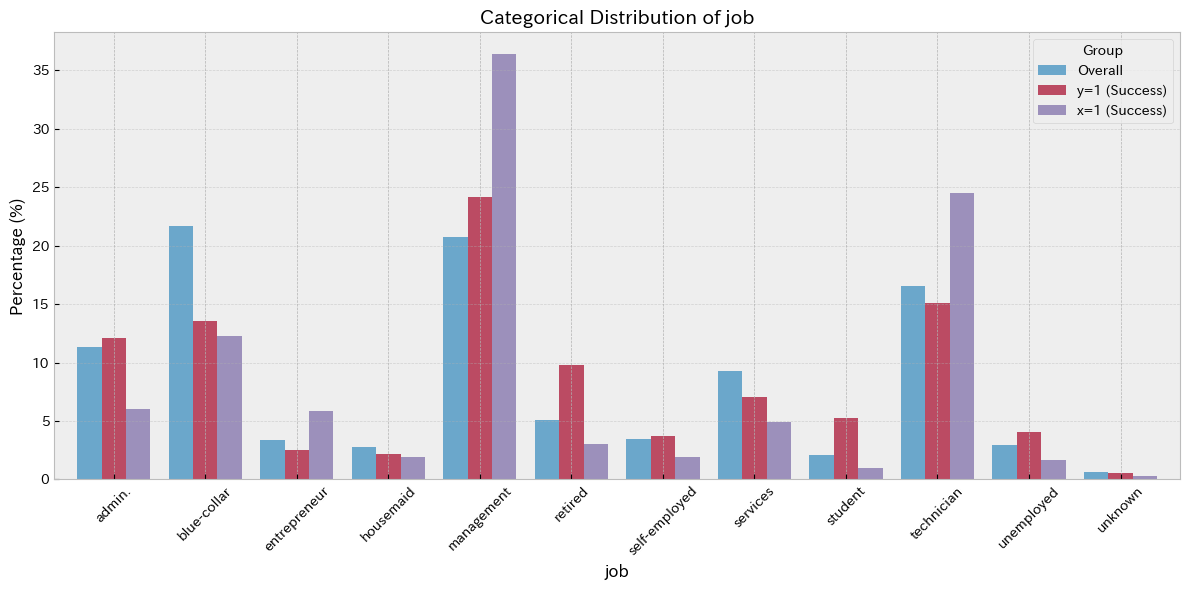

<Figure size 1200x600 with 0 Axes>

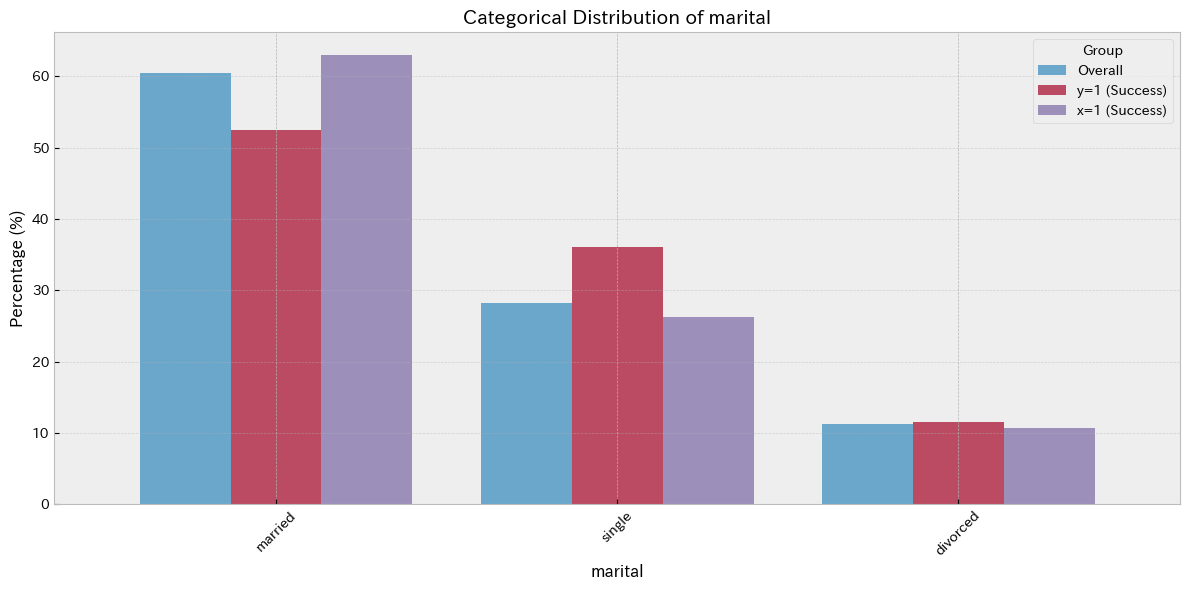

<Figure size 1200x600 with 0 Axes>

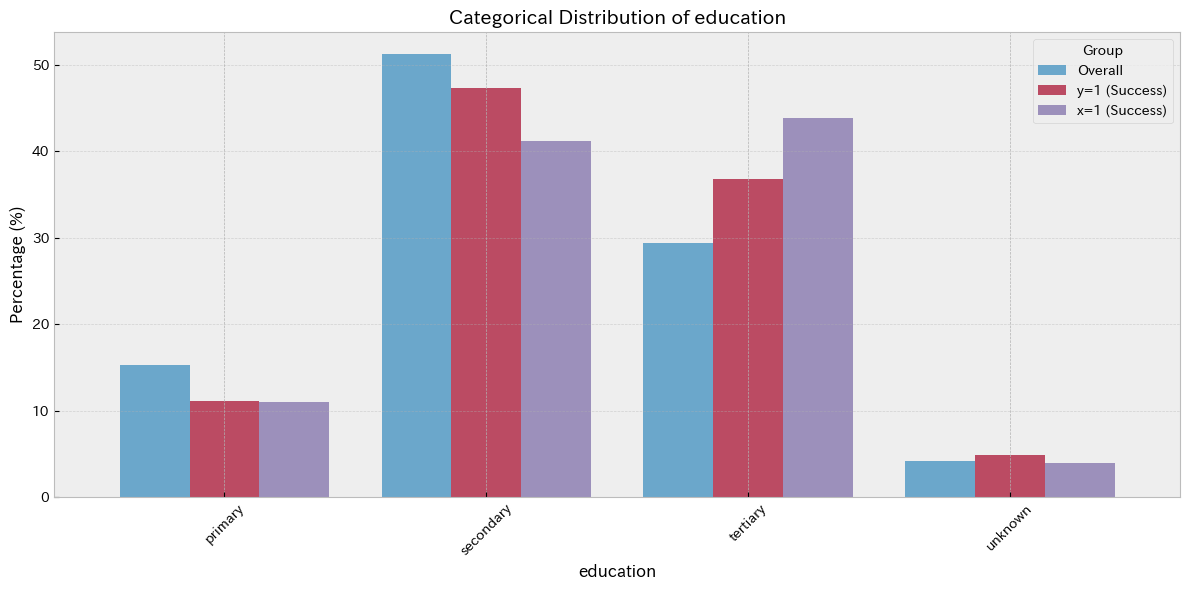

<Figure size 1200x600 with 0 Axes>

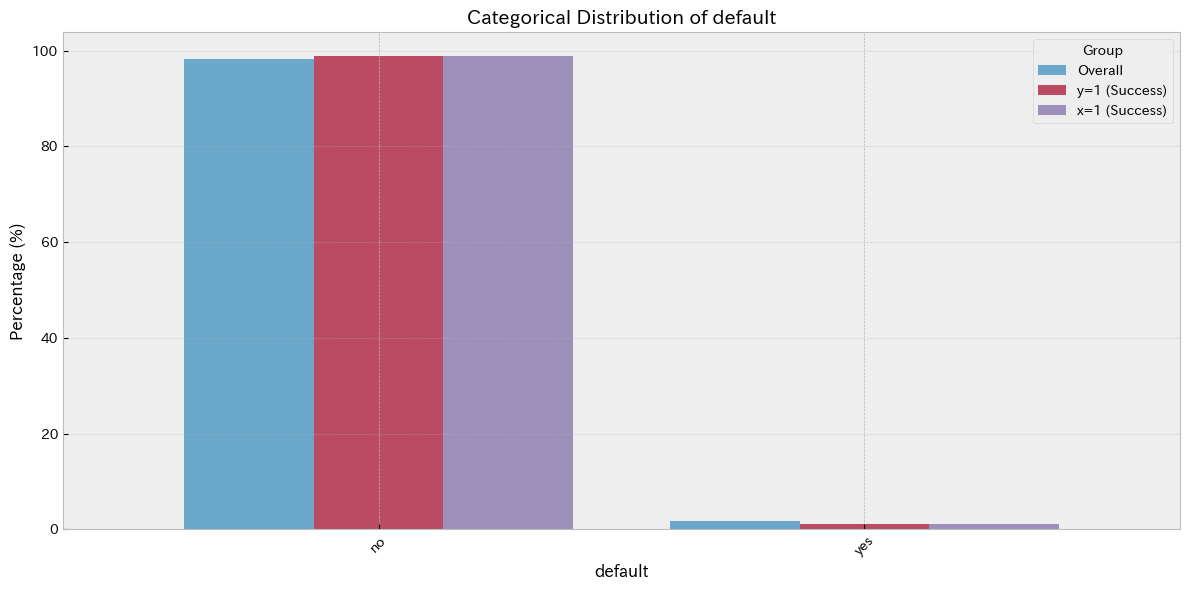

<Figure size 1200x600 with 0 Axes>

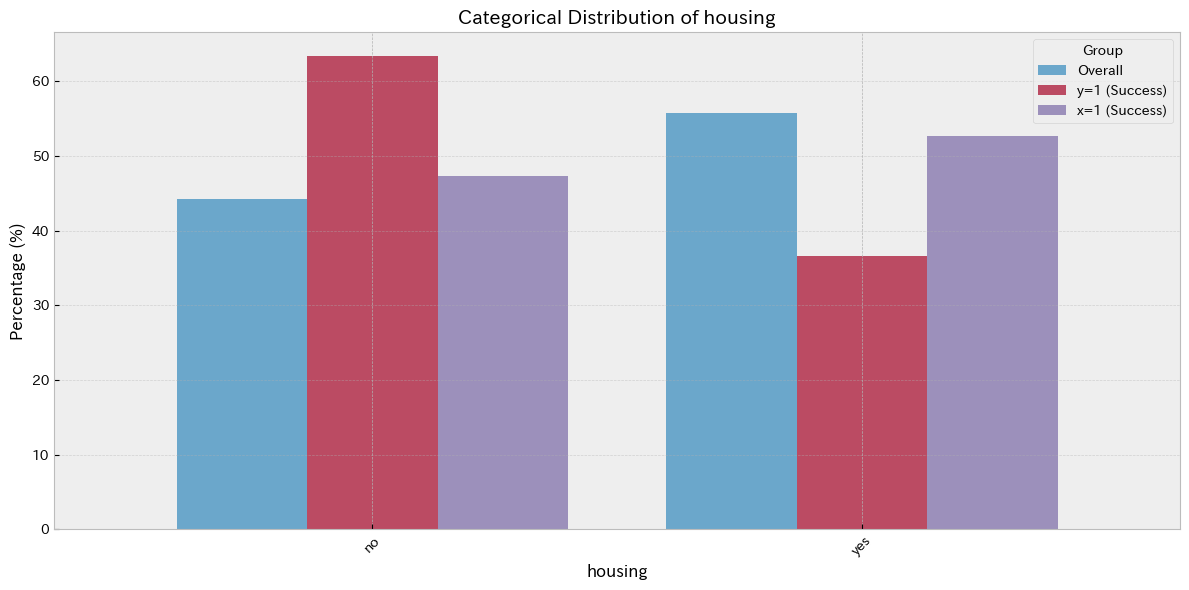

<Figure size 1200x600 with 0 Axes>

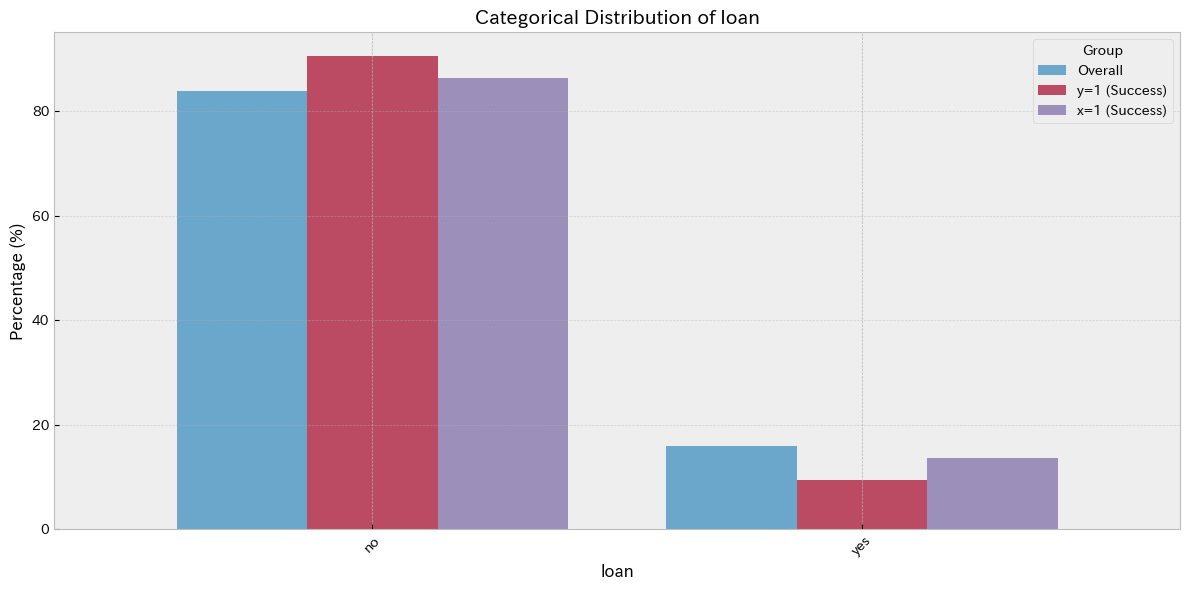

<Figure size 1200x600 with 0 Axes>

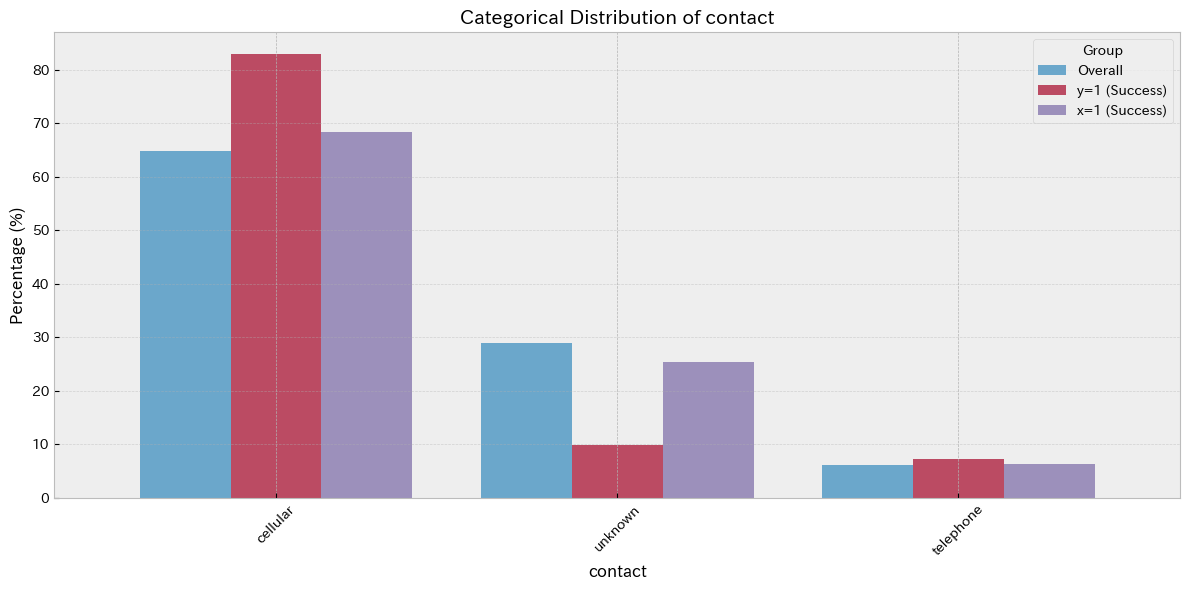

<Figure size 1200x600 with 0 Axes>

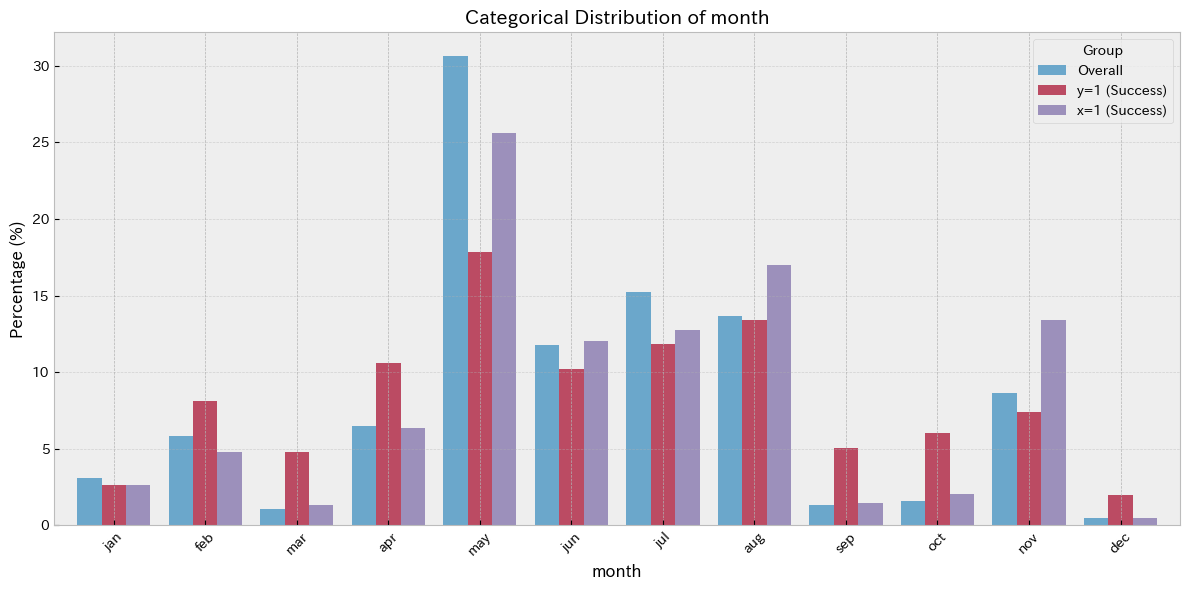

<Figure size 1200x600 with 0 Axes>

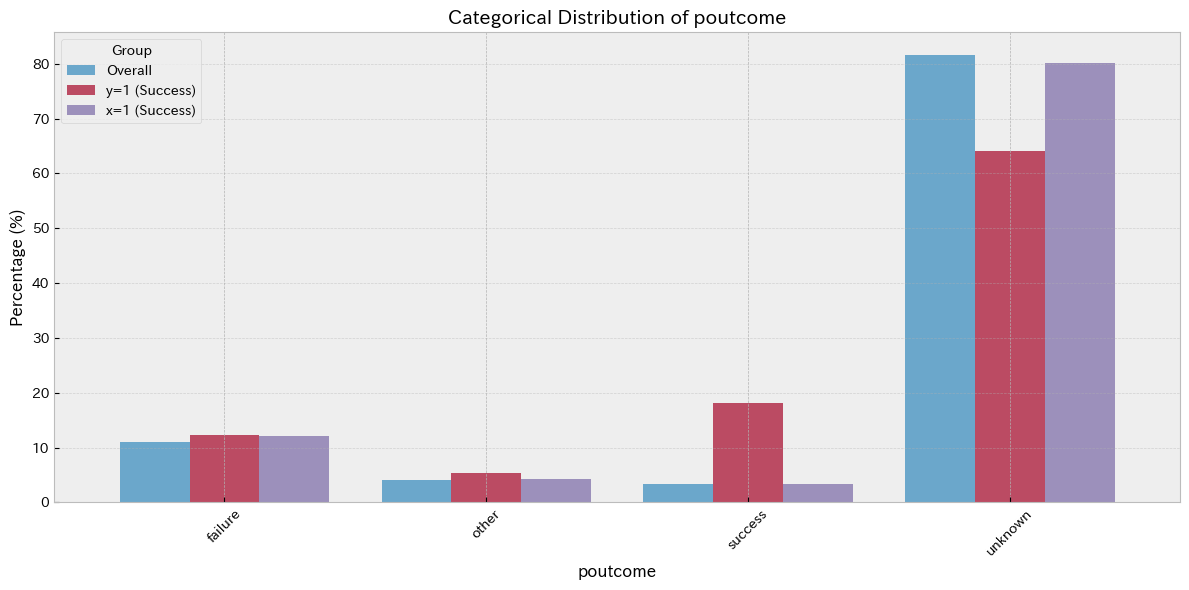

In [ ]:
# オブジェクト型変数のヒストグラムを作成する関数
def plot_categorical_histograms(columns, df, y_success, x_success):
    for column in columns:
        plt.figure(figsize=(12, 6))

        # 各カテゴリの分布を計算
        overall_counts = df[column].value_counts(normalize=True) * 100
        y_counts = y_success[column].value_counts(normalize=True) * 100
        x_counts = x_success[column].value_counts(normalize=True) * 100

        # データフレームにまとめてカテゴリ順に並べ替え
        data = pd.DataFrame({
            'Overall': overall_counts,
            'y=1 (Success)': y_counts,
            'x=1 (Success)': x_counts
        }).fillna(0)

        # month の場合、月の順序で並べ替え
        if column == 'month':
            month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
                           'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
            data = data.reindex(month_order)

        # ヒストグラムを描画
        data.plot(kind='bar', figsize=(12, 6), width=0.8, alpha=0.7)
        plt.title(f'Categorical Distribution of {column}', fontsize=14)
        plt.ylabel('Percentage (%)', fontsize=12)
        plt.xlabel(column, fontsize=12)
        plt.grid(axis='y', alpha=0.5)
        plt.xticks(rotation=45)
        plt.legend(title='Group')
        plt.tight_layout()
        plt.show()

# オブジェクト型変数のリストを取得
object_columns = df.select_dtypes(include=['object']).columns

# オブジェクト型変数のヒストグラムを作成
plot_categorical_histograms(object_columns, df, y_success, x_success)


- job（職業）
  - 全体: blue-collar（労働者）が最多で、次にmanagement（管理職）やtechnician（技術職）が多い。
  - y=1: management（管理職）とtechnician（技術職）の割合が増加、blue-collarの割合が減少。
  - x=1:  y=1と同様にmanagement（管理職）とtechnician（技術職）の割合が増加、blue-collarの割合が減少。
  - 傾向: 職業別で成功傾向が異なり、特にmanagementがyとxの両方で高い成功率を示す。また、よりxのほうが分布の偏りが顕著に表れている。

- marital（婚姻状況）
  - 全体: married（既婚）が過半数を占め、次にsingle（未婚）、divorced（離婚）が続く。
  - y=1: single（未婚）の割合が増加し、married（既婚）の割合が減少。
  - x=1: 分布が全体とほぼ一致し、婚姻状況による顕著な偏りは少ない。
  - 傾向: yでは未婚者の成功率が高いが、xでは婚姻状況の影響は小さい。

- education（学歴）
  - 全体: secondary（中等教育）が半数以上で、次にtertiary（高等教育）が多い。
  - y=1: tertiary（高等教育）の割合が増加し、primary（初等教育）の割合が減少。
  - x=1: tertiary（高等教育）が過半数を占め、secondary（中等教育）が次に多い。
  - 傾向: 学歴が高いほど成功率が高い傾向があり、特にxは高等教育の顧客に偏る。

- default（債務不履行の有無）
  - 全体: ほとんどがno（債務不履行なし）。他の分類も同様
  - 傾向: 債務不履行が成功率に与える影響は非常に小さいと想定。

- housing（住宅ローンの有無）
 - 全体: yes（あり）が過半数で、no（なし）が続く。
 - y=1: no（なし）の割合が増加し、yes（あり）の割合が減少。
 - x=1: 全体とほぼ一致し、住宅ローンの有無による偏りは少ない。
 - 傾向: yでは住宅ローンなしの顧客の成功率がやや高いが、xでは影響が小さい。

- loan（個人ローンの有無）
  - 全体: no（なし）が大半を占める。
  - y=1: no（なし）の割合がさらに増加。
  - x=1: no（なし）の割合が最も高く、yes（あり）はごくわずか。
  - 傾向: 個人ローンなしの顧客がx、yの両方で成功率が高い。

- contact（連絡方法）
  - 全体: cellular（携帯電話）が主流で、次にunknownが多い。
  - y=1: cellular（携帯電話）の割合がさらに増加し、unknownの割合が減少。
  - x=1: 全体での傾向と類似。
  - 傾向: 携帯電話での連絡が成功率を大きく押し上げる要因。特にyにおいて傾向が強い。

- month（最後の接触月）
  - 全体: may（5月）が最も多く、次にjul（7月）とaug（8月）が続く
  - y=1: mayの割合がやや減少し、aug（8月）が増加。
  - x=1: 分布は全体に近く、特定の月の顕著な偏りは少ない。
  - 傾向: yでは8月が成功に寄与している可能性あり。yは月別の影響が小さいと想定。
    - y=1はキャンペーン成功者であり、全体の傾向が5月に偏っていることから、5月に接触し、1～3か月後に再度接触を持つことで成功した可能性があると想定。

- poutcome（過去のキャンペーン結果）
  - 全体: unknownが大半を占めるが、failureとotherも一定割合を占める。
  - y=1: success（過去成功）が増加し、unknownの割合が減少。
  - x=1: 全体の傾向と類似。
  - 傾向: yにおいては、過去の成功経験が現在の成功率に大きく影響を与える。

### オブジェクト型の傾向まとめ
-  定額預金（y=1）が成功しやすい傾向
  - 職業: management（管理職）、technician（技術職）
  - 学歴: tertiary（高等教育）、secondary（中等教育）
  - 婚姻状況: single（未婚）の割合が高い
  - 住宅ローン: no（住宅ローンなし）の割合がやや高い
  - 個人ローン: no（個人ローンなし）の顧客が多い
  - 連絡方法: cellular（携帯電話）が中心
  - 月: aug（8月）で成功率がやや高い
  - 過去のキャンペーン結果: success（過去成功）の顧客が多い

- NISA口座（x=1）が成功しやすい傾向
  - 職業: management（管理職）が圧倒的に多い
  - 学歴: tertiary（高等教育）が大半を占める
  - 婚姻状況: 婚姻状況による顕著な影響は少ない
  - 住宅ローン: 住宅ローンの有無による影響は小さい
  - 個人ローン: no（個人ローンなし）の顧客が中心
  - 連絡方法: cellular（携帯電話）が圧倒的に多い
  - 月: 月別の顕著な偏りは見られない
  - 過去のキャンペーン結果: success（過去成功）の顧客が非常に多い

# 2.特徴量重要度分析
- どの変数が有効であるかの確認を行う

## 2-1: 前処理

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 1. 数値型とカテゴリ型の分離
# 数値型の列から目的変数とidを除外
numeric_features = [col for col in df.select_dtypes(include=['number']).columns
                    if col not in ['y', 'x', 'id']]
# カテゴリ型の列を取得
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# 2. 特徴量と目的変数の分離
# 特徴量（features）と目的変数（y, x）を分離
if 'y' in df.columns and 'x' in df.columns:
    features = df.drop(columns=['y', 'x', 'id'])  # 特徴量
    y = df['y']  # 定額預金申し込み
    x = df['x']  # NISA口座開設
else:
    raise ValueError("The columns 'y', 'x', and 'id' are not found in the dataframe.")

# 3. データ分割（訓練用とテスト用に分割）
# 定額預金申し込み（y）をターゲットに分割
features_train_y, features_test_y, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=42)
# NISA口座（x）をターゲットに分割
features_train_x, features_test_x, x_train, x_test = train_test_split(features, x, test_size=0.3, random_state=42)

# 4. 前処理の構築
# 数値型データを標準化、カテゴリ型データをワンホットエンコード
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # 数値型の標準化
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # カテゴリ型のワンホットエンコード
    ])


In [ ]:
# 前処理の状況を確認
# 訓練データに前処理を適用
sample_transformed = preprocessor.fit_transform(features_train_y)

# データの形状を確認
print(sample_transformed.shape)

# サンプル変換結果を表示（部分的に）
print(sample_transformed[:5])


(18989, 51)
[[-0.94154982 -0.14016027 -0.21937745  0.7968465  -0.56274352  3.4170512
   0.87205521  0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.          0.          0.
   1.          0.          1.          0.          1.          0.
   1.          0.          1.          0.          0.          0.
   0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [-0.2794524  -0.39916878 -0.09953744 -0.77645165  2.64143541  3.23786127
   0.14790712  0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          1.          0.          0.          1.
   0.          0.          1.          0.          1.          0.
   0.          1.          1.          0.          0.          0.
   0.     

## 2-2: ランダムフォレストによる特徴量重要度の計算

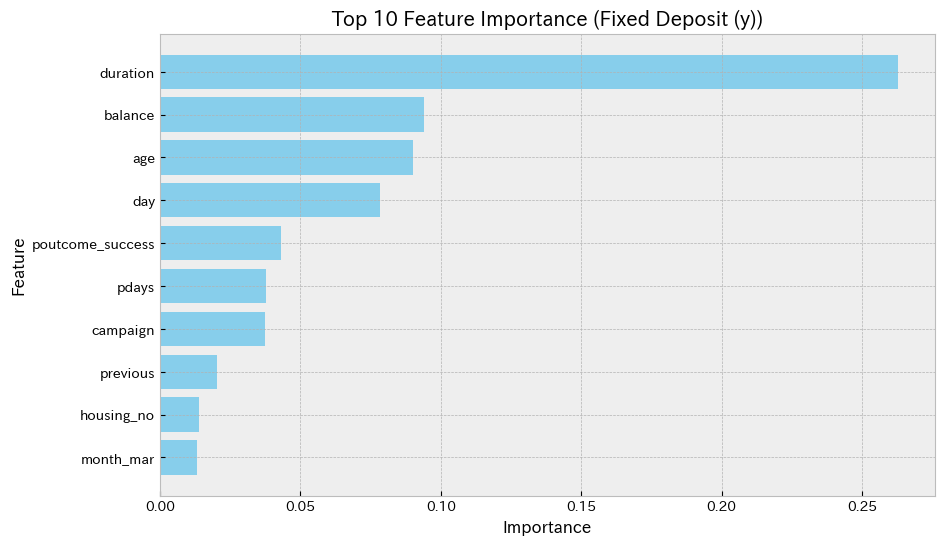

Top 10 Most Important Features for Fixed Deposit (y):
             Feature  Importance
3           duration    0.262821
1            balance    0.093870
0                age    0.090131
2                day    0.078399
49  poutcome_success    0.043150
5              pdays    0.037826
4           campaign    0.037406
6           previous    0.020426
28        housing_no    0.014058
42         month_mar    0.013090


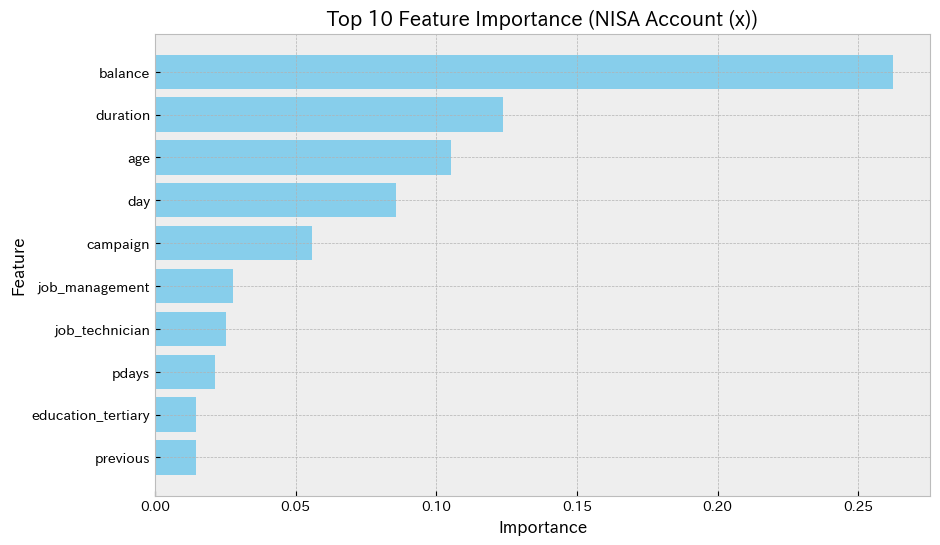

Top 10 Most Important Features for NISA Account (x):
               Feature  Importance
1              balance    0.262399
3             duration    0.123729
0                  age    0.105359
2                  day    0.085505
4             campaign    0.055924
11      job_management    0.027775
16      job_technician    0.025275
5                pdays    0.021432
24  education_tertiary    0.014736
6             previous    0.014689


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt

def compute_feature_importance(features_train, target_train, target_name):
    # ランダムフォレストのパイプラインを構築
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),  # 前処理
        ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
    ])

    # モデルの学習
    model.fit(features_train, target_train)

    # 特徴量重要度の取得
    feature_importances = model.named_steps['classifier'].feature_importances_

    # ワンホットエンコーディングされたカテゴリ型列の名前を取得
    if categorical_features:
        encoded_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    else:
        encoded_features = []

    # 数値型とワンホットエンコード列の名前を結合
    all_features = numeric_features + list(encoded_features)

    # 特徴量重要度のデータフレームを作成
    importance_df = pd.DataFrame({
        'Feature': all_features,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # 上位10個の特徴量を抽出
    top_10 = importance_df.head(10)

    # 特徴量重要度の可視化（上位10個のみ）
    plt.figure(figsize=(10, 6))
    plt.barh(top_10['Feature'], top_10['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top 10 Feature Importance ({target_name})')
    plt.gca().invert_yaxis()
    plt.show()

    # 上位10個の特徴量を表示
    print(f"Top 10 Most Important Features for {target_name}:")
    print(top_10)

# 定額預金（y）の特徴量重要度を計算
compute_feature_importance(features_train_y, y_train, 'Fixed Deposit (y)')

# NISA口座（x）の特徴量重要度を計算
compute_feature_importance(features_train_x, x_train, 'NISA Account (x)')


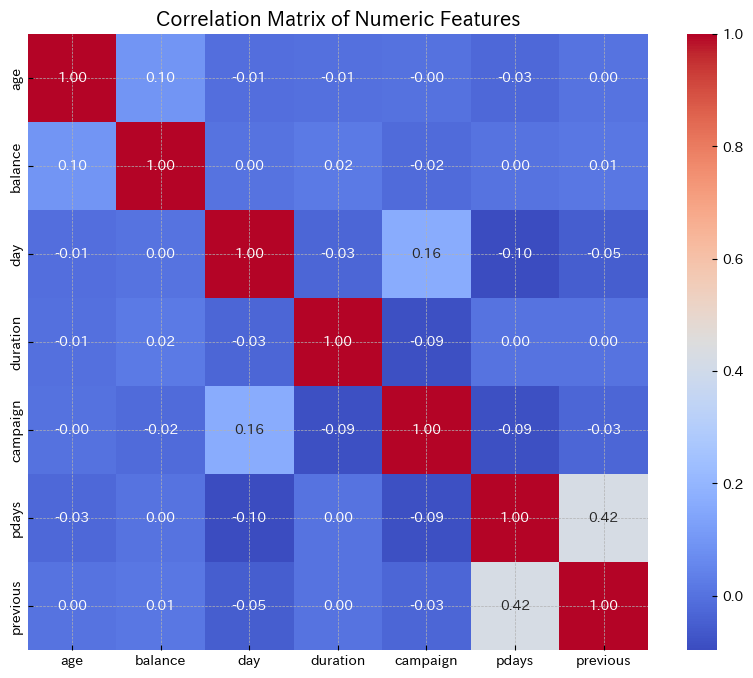

Correlation with 'age':
age         1.000000
balance     0.095343
previous    0.002946
campaign   -0.001340
duration   -0.005309
day        -0.008518
pdays      -0.025272
Name: age, dtype: float64

Highly correlated features with 'age':
['age']


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 数値型変数の相関行列を計算
numeric_data = df[numeric_features]
correlation_matrix = numeric_data.corr()

# `age` と他の変数の相関を抽出
age_correlation = correlation_matrix['age'].sort_values(ascending=False)

# 相関が高い変数をリストアップ（絶対値で 0.5 以上）
high_correlation_features = age_correlation[abs(age_correlation) >= 0.5].index.tolist()

# 相関行列をヒートマップで可視化
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# `age` と他の変数の相関を出力
print("Correlation with 'age':")
print(age_correlation)
print("\nHighly correlated features with 'age':")
print(high_correlation_features)


## 2-3: ロジスティック回帰モデルで補足分析

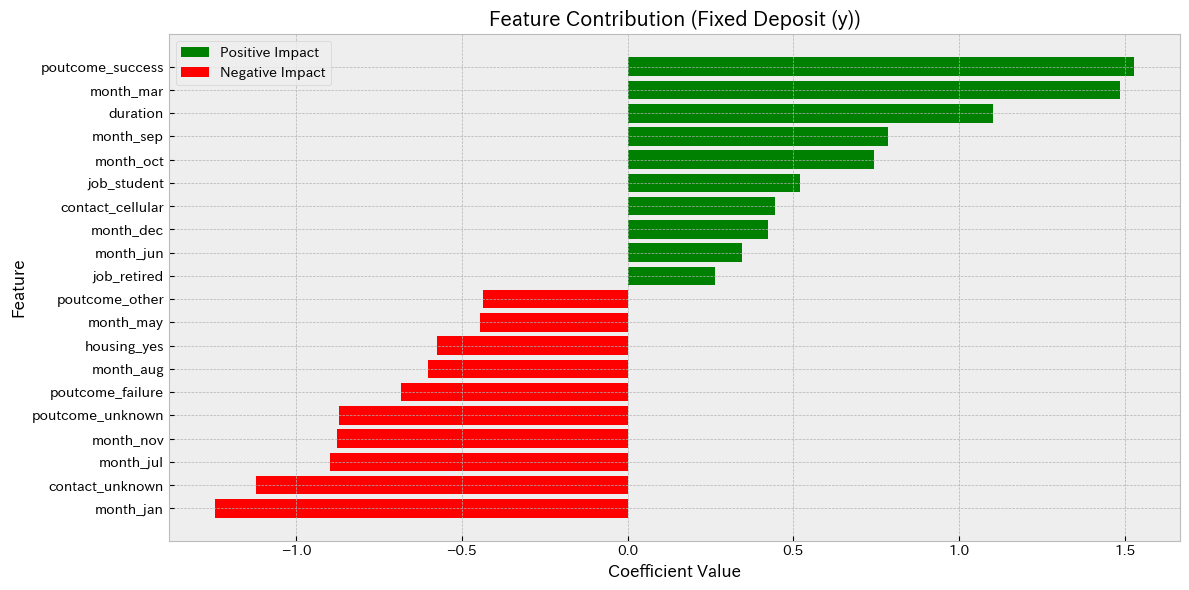

Top 10 Most Positive Features for Fixed Deposit (y):
             Feature  Coefficient
49  poutcome_success     1.527970
42         month_mar     1.485630
3           duration     1.102351
46         month_sep     0.786992
45         month_oct     0.743735
15       job_student     0.521242
32  contact_cellular     0.446287
37         month_dec     0.425121
41         month_jun     0.345468
12       job_retired     0.265190

Top 10 Most Negative Features for Fixed Deposit (y):
             Feature  Coefficient
48    poutcome_other    -0.437612
43         month_may    -0.445282
29       housing_yes    -0.573564
36         month_aug    -0.601684
47  poutcome_failure    -0.683220
50  poutcome_unknown    -0.870679
44         month_nov    -0.876060
40         month_jul    -0.897695
34   contact_unknown    -1.121665
39         month_jan    -1.245002


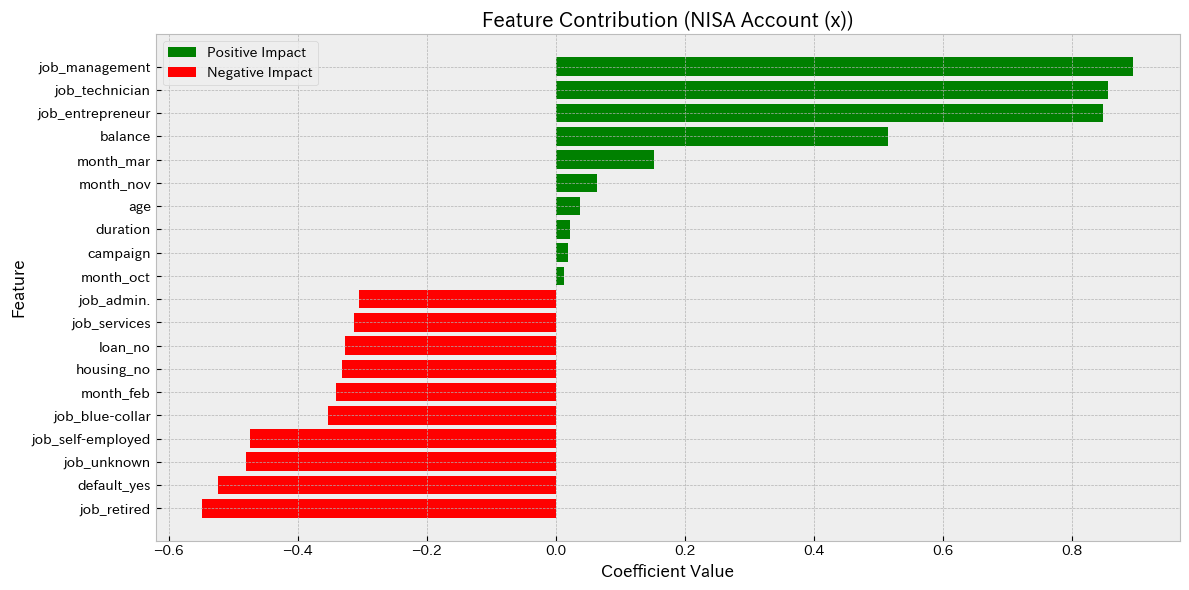

Top 10 Most Positive Features for NISA Account (x):
             Feature  Coefficient
11    job_management     0.895079
16    job_technician     0.855078
9   job_entrepreneur     0.848420
1            balance     0.515032
42         month_mar     0.152688
44         month_nov     0.064339
0                age     0.037402
3           duration     0.022400
4           campaign     0.018177
45         month_oct     0.013114

Top 10 Most Negative Features for NISA Account (x):
              Feature  Coefficient
7          job_admin.    -0.305398
14       job_services    -0.312006
30            loan_no    -0.327273
28         housing_no    -0.330850
38          month_feb    -0.339857
8     job_blue-collar    -0.353340
13  job_self-employed    -0.474532
18        job_unknown    -0.480737
27        default_yes    -0.523989
12        job_retired    -0.547720


In [ ]:
from sklearn.linear_model import LogisticRegression

def logistic_regression_analysis(features_train, target_train, target_name):
    # 既存の前処理を再利用し、ロジスティック回帰を追加したパイプラインを構築
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),  # ステップ2で構築済みの前処理を再利用
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])

    # モデルの学習
    model.fit(features_train, target_train)

    # ロジスティック回帰の係数を取得
    coefficients = model.named_steps['classifier'].coef_[0]

    # ワンホットエンコードされたカテゴリ型列の名前を取得
    if categorical_features:
        encoded_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    else:
        encoded_features = []

    # 数値型とワンホットエンコード列の名前を結合
    all_features = numeric_features + list(encoded_features)

    # 係数をデータフレームにまとめる
    importance_df = pd.DataFrame({
        'Feature': all_features,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', ascending=False)

    # 寄与の可視化（上位10個）
    top_10_positive = importance_df.head(10)
    top_10_negative = importance_df.tail(10)

    plt.figure(figsize=(12, 6))
    plt.barh(top_10_positive['Feature'], top_10_positive['Coefficient'], color='green', label='Positive Impact')
    plt.barh(top_10_negative['Feature'], top_10_negative['Coefficient'], color='red', label='Negative Impact')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title(f'Feature Contribution ({target_name})')
    plt.legend()
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # 上位10個の特徴量を表示
    print(f"Top 10 Most Positive Features for {target_name}:")
    print(top_10_positive)
    print(f"\nTop 10 Most Negative Features for {target_name}:")
    print(top_10_negative)

# 定額預金（y）のロジスティック回帰分析
logistic_regression_analysis(features_train_y, y_train, 'Fixed Deposit (y)')

# NISA口座（x）のロジスティック回帰分析
logistic_regression_analysis(features_train_x, x_train, 'NISA Account (x)')


# 3.クラスタリング分析

##　3-1：前処理

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 数値型とカテゴリ型の分離
numeric_features = [col for col in df.select_dtypes(include=['number']).columns if col not in ['y', 'x', 'id']]
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# 前処理のパイプライン
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # 数値型の標準化
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # カテゴリ型のワンホットエンコード
    ])

# 特徴量の前処理
features_processed = preprocessor.fit_transform(features)

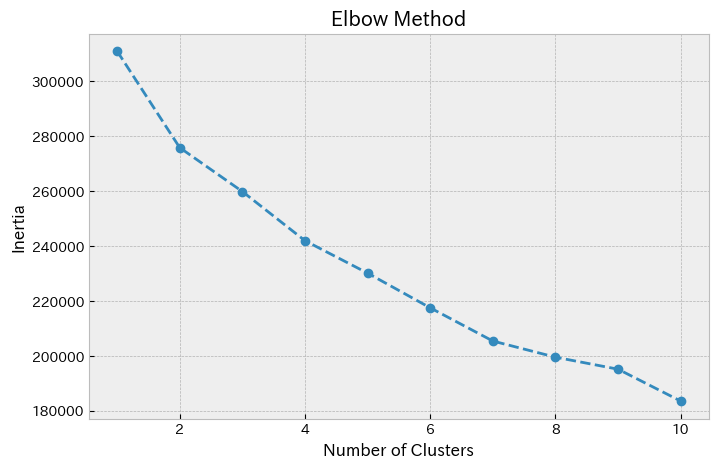

In [ ]:
# エルボー法で最適なクラスター数を確認
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_processed)
    inertia.append(kmeans.inertia_)

# エルボー法のプロット
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# 最適なクラスター数（例: 3）でK-meansを実行
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(features_processed)

# クラスター結果をデータフレームに追加
df['Cluster'] = clusters


クラスター数2が候補

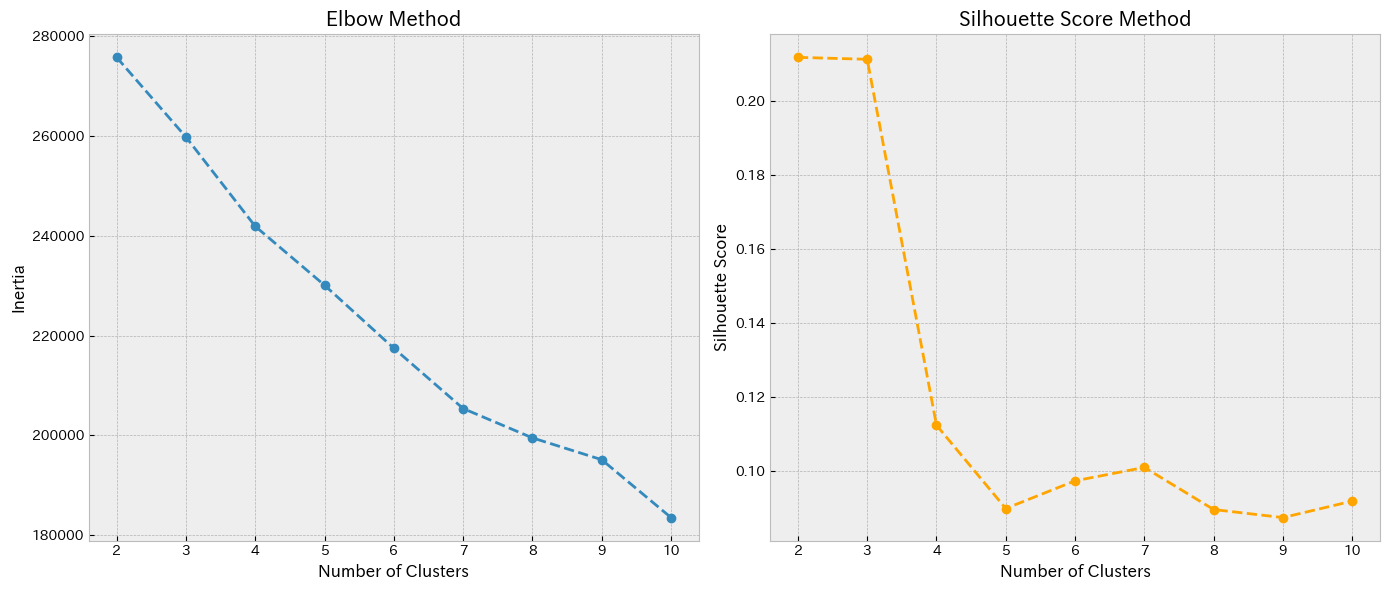

Optimal number of clusters based on silhouette score: 2


In [ ]:
# 最適なクラスター数の再確認（シルエットスコアによる）
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# エルボー法とシルエットスコアの計算
inertia = []
silhouette_scores = []
cluster_range = range(2, 11)  # クラスター数を2から10まで試す

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_processed)
    inertia.append(kmeans.inertia_)  # エルボー法のためのinertia
    silhouette_scores.append(silhouette_score(features_processed, kmeans.labels_))  # シルエットスコア

# エルボー法のプロット
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# シルエットスコアのプロット
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.tight_layout()
plt.show()

# 最適なクラスター数の選択（シルエットスコアが最大のクラスター数）
optimal_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters based on silhouette score: {optimal_clusters}")

## 3-2：クラスタリングの実行

In [ ]:
# 最適なクラスター数でK-meansを実行
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(features_processed)

# クラスター結果をデータフレームに追加
df['Cluster'] = clusters

## 3-3. クラスター別の成功率分析と可視化

         y_success_rate  x_success_rate
Cluster                                
0              0.217260        0.127077
1              0.096341        0.114925


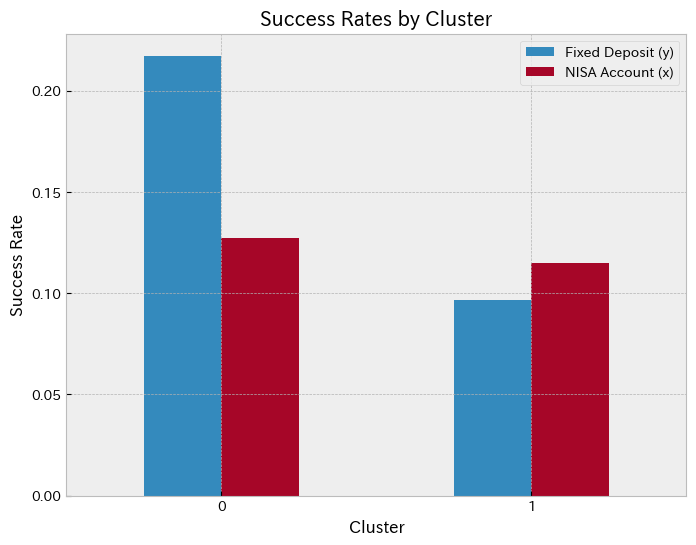

In [ ]:
# クラスターごとに定額預金（y）の成功率を計算
y_success_rate = df.groupby('Cluster')['y'].mean()

# クラスターごとにNISA口座（x）の成功率を計算
x_success_rate = df.groupby('Cluster')['x'].mean()

# 成功率のデータフレーム
success_rates = pd.DataFrame({'y_success_rate': y_success_rate, 'x_success_rate': x_success_rate})
print(success_rates)

# 成功率の棒グラフを表示
success_rates.plot(kind='bar', figsize=(8, 6), rot=0)
plt.title('Success Rates by Cluster')
plt.ylabel('Success Rate')
plt.xlabel('Cluster')
plt.legend(['Fixed Deposit (y)', 'NISA Account (x)'])
plt.show()

In [ ]:
# 各クラスターの分布をカウント
cluster_counts = df['Cluster'].value_counts()

# 各クラスターの割合を計算
cluster_proportions = df['Cluster'].value_counts(normalize=True) * 100

# 結果を表示
print("Cluster counts:")
print(cluster_counts)

print("\nCluster proportions (%):")
print(cluster_proportions)


Cluster counts:
Cluster
1    22493
0     4635
Name: count, dtype: int64

Cluster proportions (%):
Cluster
1    82.914332
0    17.085668
Name: proportion, dtype: float64


         Count  y_success_rate (%)  x_success_rate (%)
Cluster                                               
1        22493           21.725998           12.707659
0         4635            9.634108           11.492464


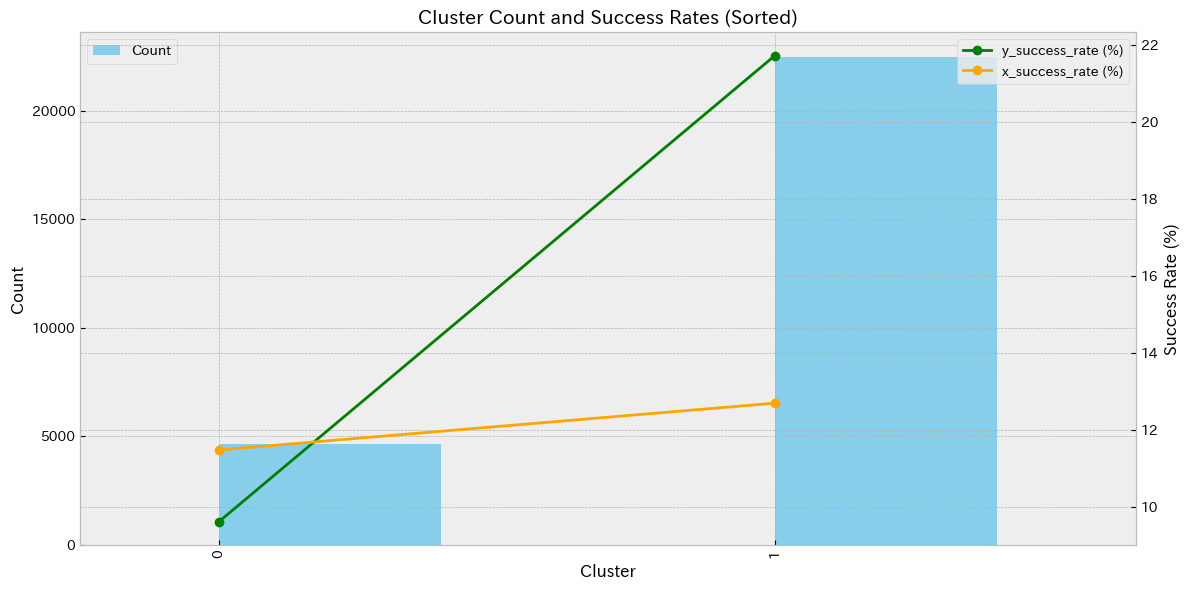

In [ ]:
# クラスターごとの成功率を計算
y_success_rate = df.groupby('Cluster')['y'].mean() * 100  # 成功率をパーセント表記に変換
x_success_rate = df.groupby('Cluster')['x'].mean() * 100  # 成功率をパーセント表記に変換

# クラスター構成の実数を使用してデータフレームを作成
cluster_summary = pd.DataFrame({
    'Count': cluster_counts.values,  # クラスター構成の実数
    'y_success_rate (%)': y_success_rate.values,  # 定額預金の成功率
    'x_success_rate (%)': x_success_rate.values  # NISA口座の成功率
}, index=cluster_counts.index)

# データフレームを確認
print(cluster_summary)

# クラスター構成をソート（クラスター0が左、クラスター1が右になるように設定）
cluster_summary_sorted = cluster_summary.sort_index()

# 可視化
fig, ax1 = plt.subplots(figsize=(12, 6))

# 実数でクラスター数を棒グラフで表示（左側がクラスター0、右がクラスター1）
cluster_summary_sorted['Count'].plot(kind='bar', ax=ax1, color='skyblue', width=0.4, position=0, label='Count')

# 成功率を折れ線グラフで表示
ax2 = ax1.twinx()
cluster_summary_sorted['y_success_rate (%)'].plot(kind='line', ax=ax2, marker='o', color='green', label='y_success_rate (%)')
cluster_summary_sorted['x_success_rate (%)'].plot(kind='line', ax=ax2, marker='o', color='orange', label='x_success_rate (%)')

# グラフの装飾
ax1.set_ylabel('Count', fontsize=12)
ax2.set_ylabel('Success Rate (%)', fontsize=12)
ax1.set_xlabel('Cluster', fontsize=12)
ax1.set_title('Cluster Count and Success Rates (Sorted)', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# 数値型変数の平均値をクラスターごとに計算
numeric_cluster_summary = df.groupby('Cluster')[numeric_features].mean()

# 結果を確認
print("Numeric Feature Averages by Cluster:")
print(numeric_cluster_summary)

Numeric Feature Averages by Cluster:
               age      balance        day    duration  campaign       pdays  \
Cluster                                                                        
0        40.992017  1552.545631  14.064725  264.803883  2.068393  237.171521   
1        40.942560  1315.258836  16.165074  259.867959  2.892589    0.006891   

         previous  
Cluster            
0        3.278317  
1        0.023652  


In [ ]:
# カテゴリ型変数の割合をクラスターごとに計算
categorical_cluster_summary = {}
for col in categorical_features:
    categorical_cluster_summary[col] = df.groupby('Cluster')[col].value_counts(normalize=True).unstack()

# 結果を確認
for col, summary in categorical_cluster_summary.items():
    print(f"\nCategory Distribution for {col}:")
    print(summary)


Category Distribution for job:
job        admin.  blue-collar  entrepreneur  housemaid  management   retired  \
Cluster                                                                         
0        0.134412     0.203020      0.028047   0.019849    0.208414  0.056526   
1        0.109456     0.219846      0.034855   0.029920    0.206909  0.050193   

job      self-employed  services   student  technician  unemployed   unknown  
Cluster                                                                       
0             0.035167  0.089536  0.031068    0.163754    0.025890  0.004315  
1             0.034766  0.092962  0.018361    0.165918    0.029787  0.007024  

Category Distribution for marital:
marital  divorced   married    single
Cluster                              
0        0.112406  0.584466  0.303128
1        0.112657  0.609167  0.278175

Category Distribution for education:
education   primary  secondary  tertiary   unknown
Cluster                                           

In [ ]:
import pandas as pd

# 数値型変数の平均値をまとめる
numeric_summary = numeric_cluster_summary.copy()

# カテゴリ型変数の主要な割合（例: 上位3つ）を追加
for col, summary in categorical_cluster_summary.items():
    top_categories = summary.columns[:3]  # 上位3カテゴリ
    for category in top_categories:
        numeric_summary[f"{col}_{category}"] = summary[category]

# 比較表を表示
print("Combined Cluster Summary:")
print(numeric_summary)


Combined Cluster Summary:
               age      balance        day    duration  campaign       pdays  \
Cluster                                                                        
0        40.992017  1552.545631  14.064725  264.803883  2.068393  237.171521   
1        40.942560  1315.258836  16.165074  259.867959  2.892589    0.006891   

         previous  job_admin.  job_blue-collar  job_entrepreneur  ...  \
Cluster                                                           ...   
0        3.278317    0.134412         0.203020          0.028047  ...   
1        0.023652    0.109456         0.219846          0.034855  ...   

         loan_yes  contact_cellular  contact_telephone  contact_unknown  \
Cluster                                                                   
0        0.143042          0.921683           0.069687         0.008630   
1        0.163473          0.591651           0.060641         0.347708   

         month_apr  month_aug  month_dec  poutcome_failure 

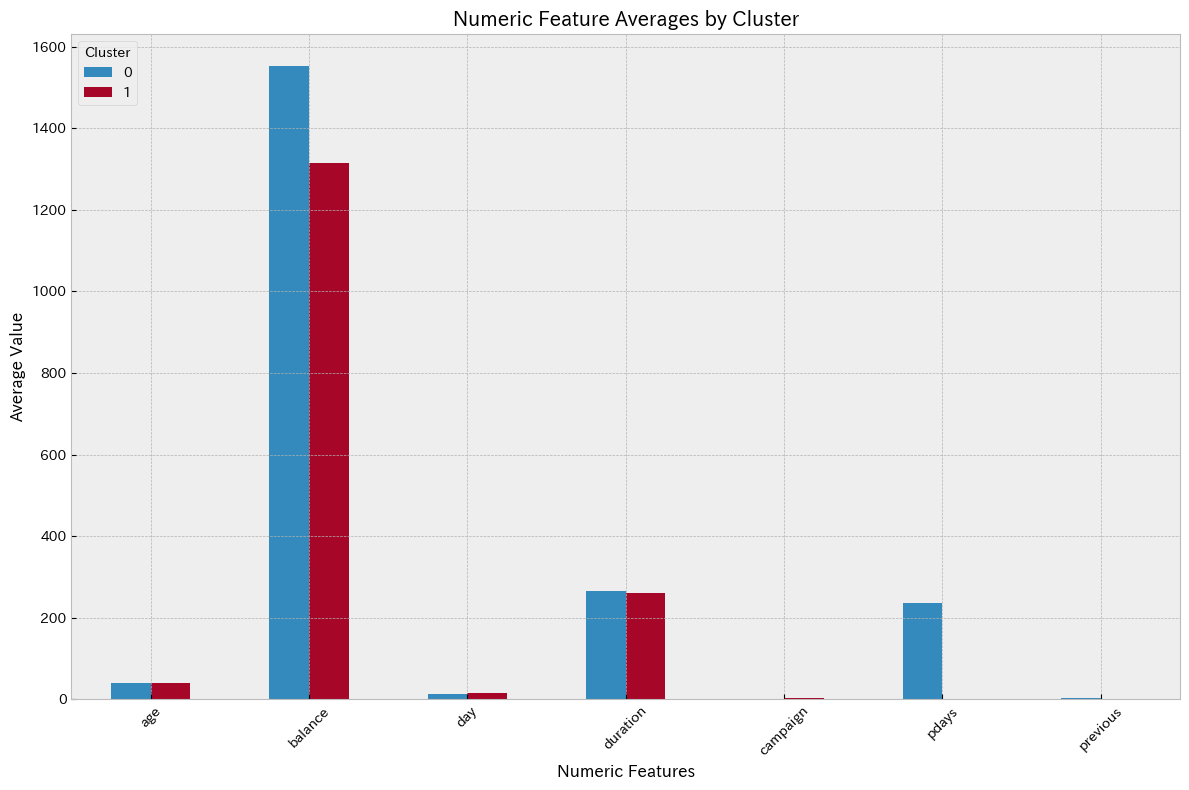

In [ ]:
# 数値型変数の平均値をクラスターごとに計算
numeric_cluster_summary = df.groupby('Cluster')[numeric_features].mean()

# 数値型変数の平均値を棒グラフでプロット
numeric_cluster_summary.T.plot(kind='bar', figsize=(12, 8), legend=True)
plt.title('Numeric Feature Averages by Cluster')
plt.ylabel('Average Value')
plt.xlabel('Numeric Features')
plt.xticks(rotation=45)
plt.legend(title='Cluster', loc='upper left')
plt.tight_layout()
plt.show()


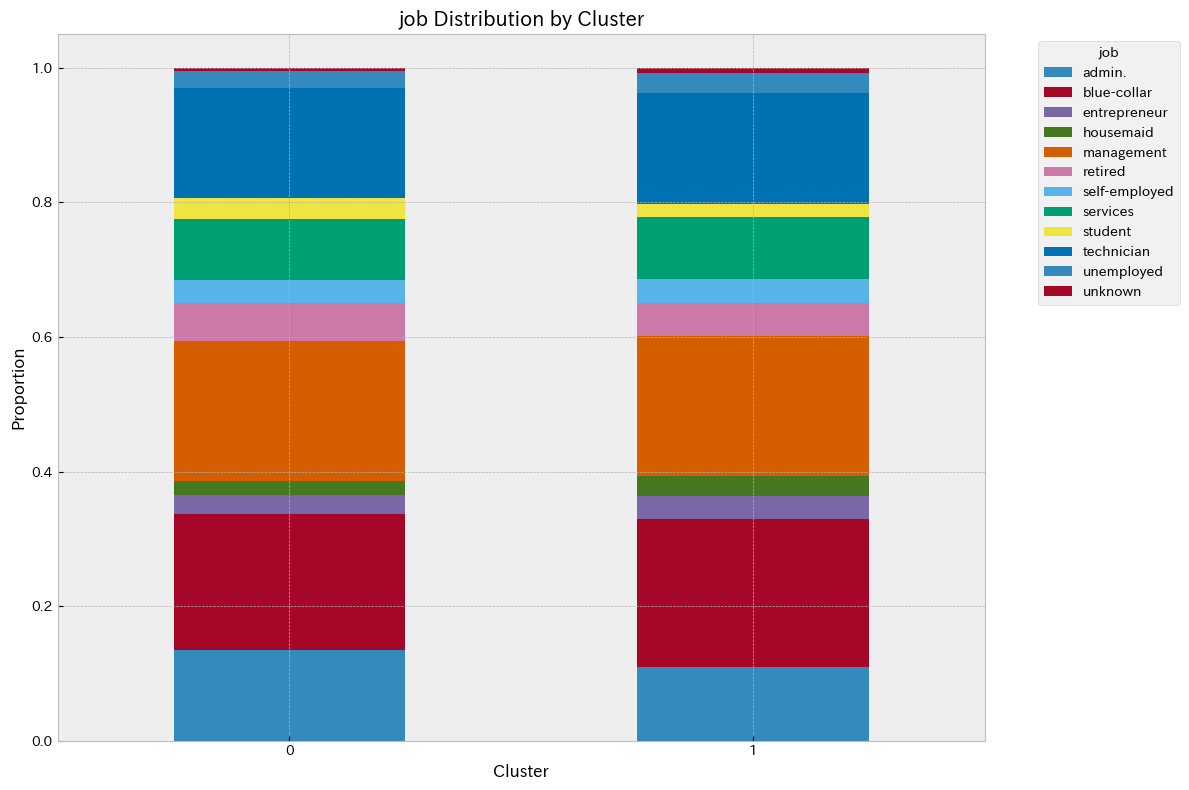

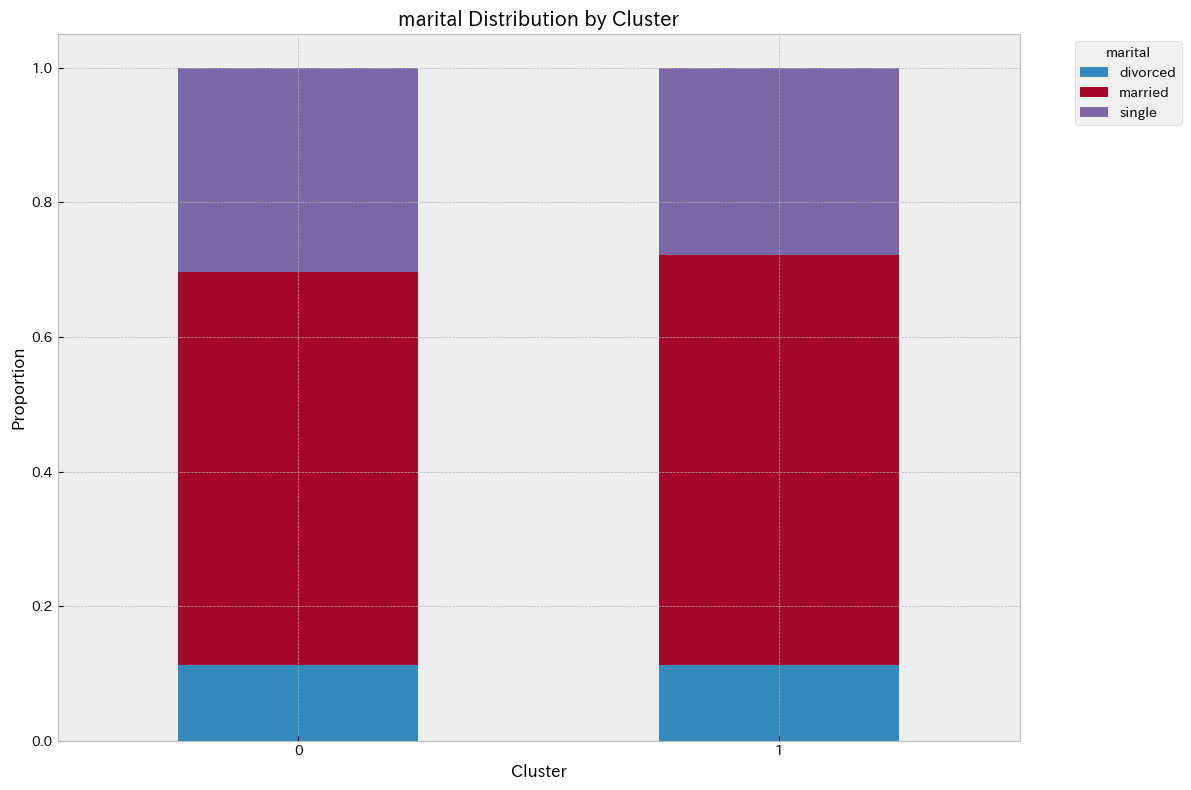

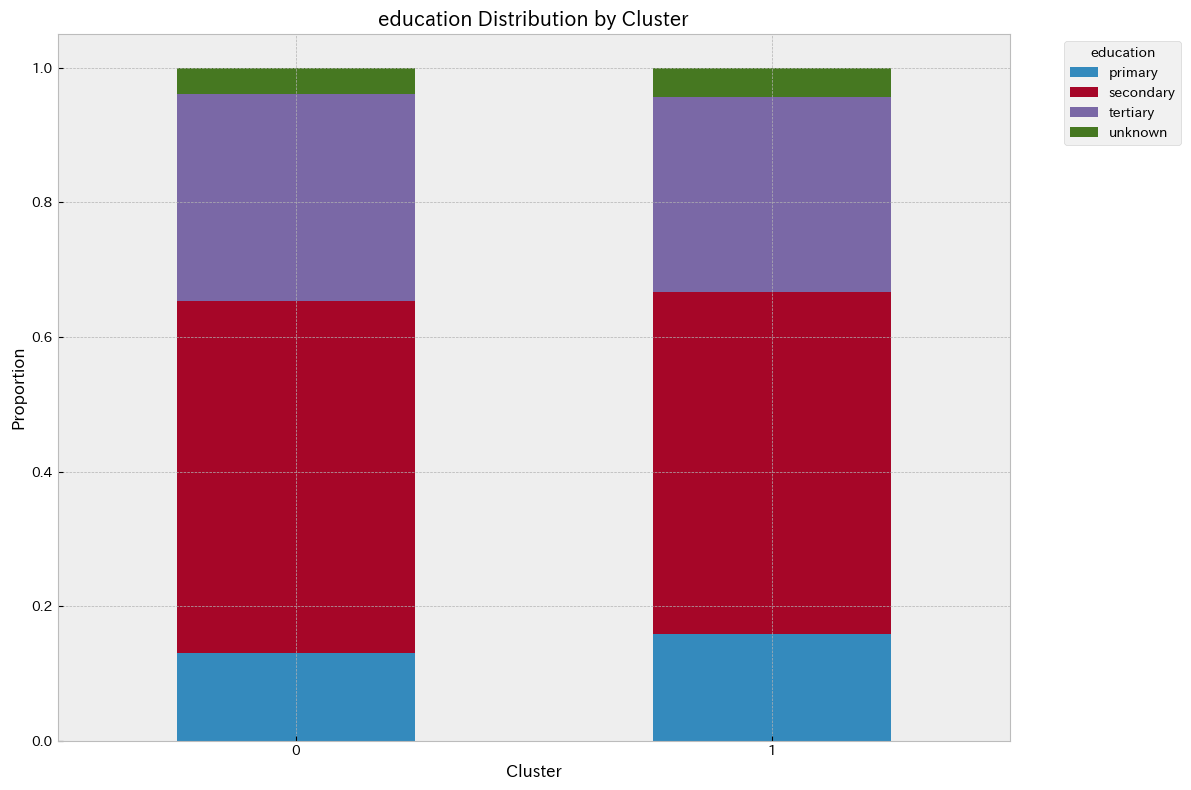

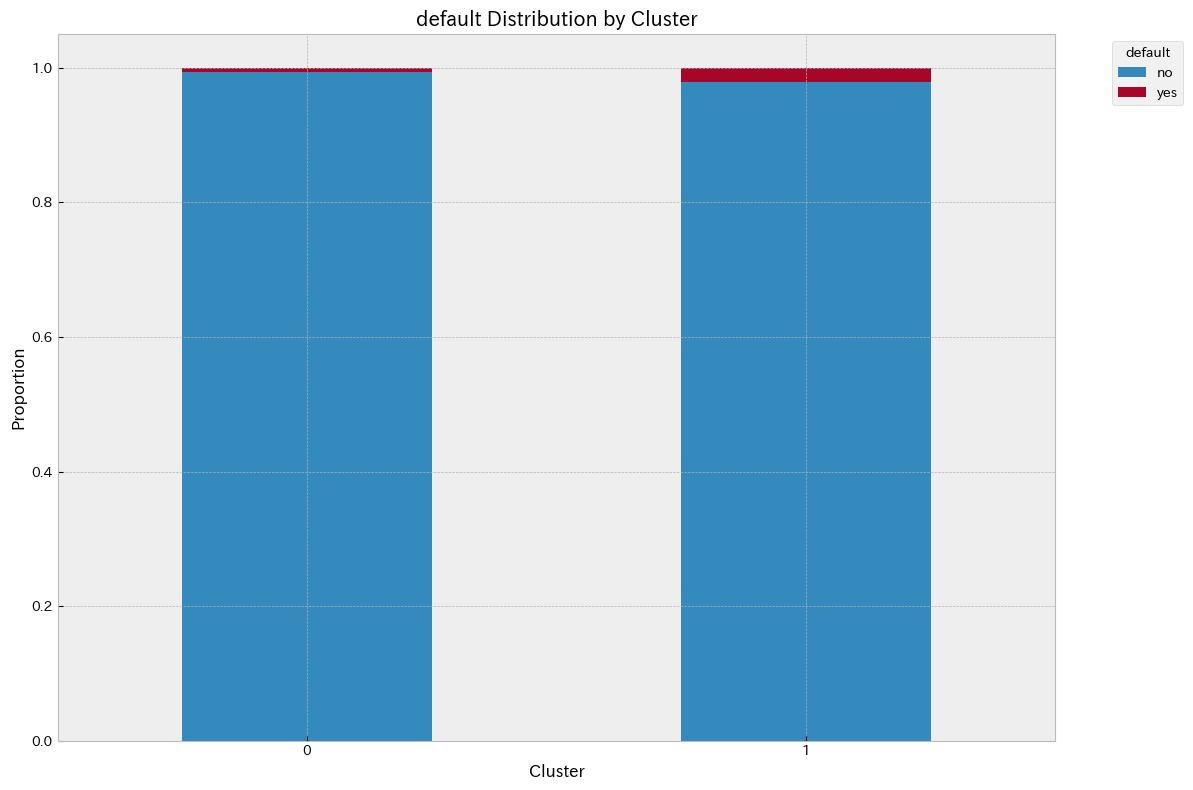

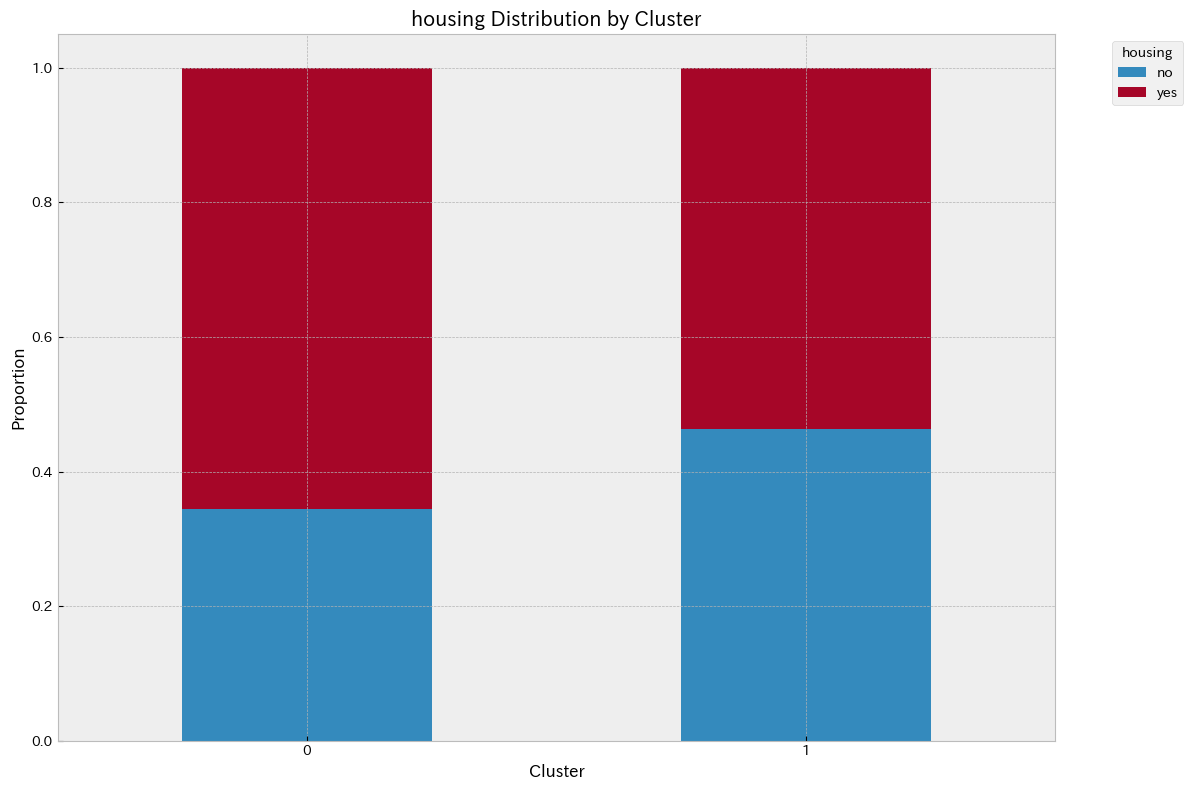

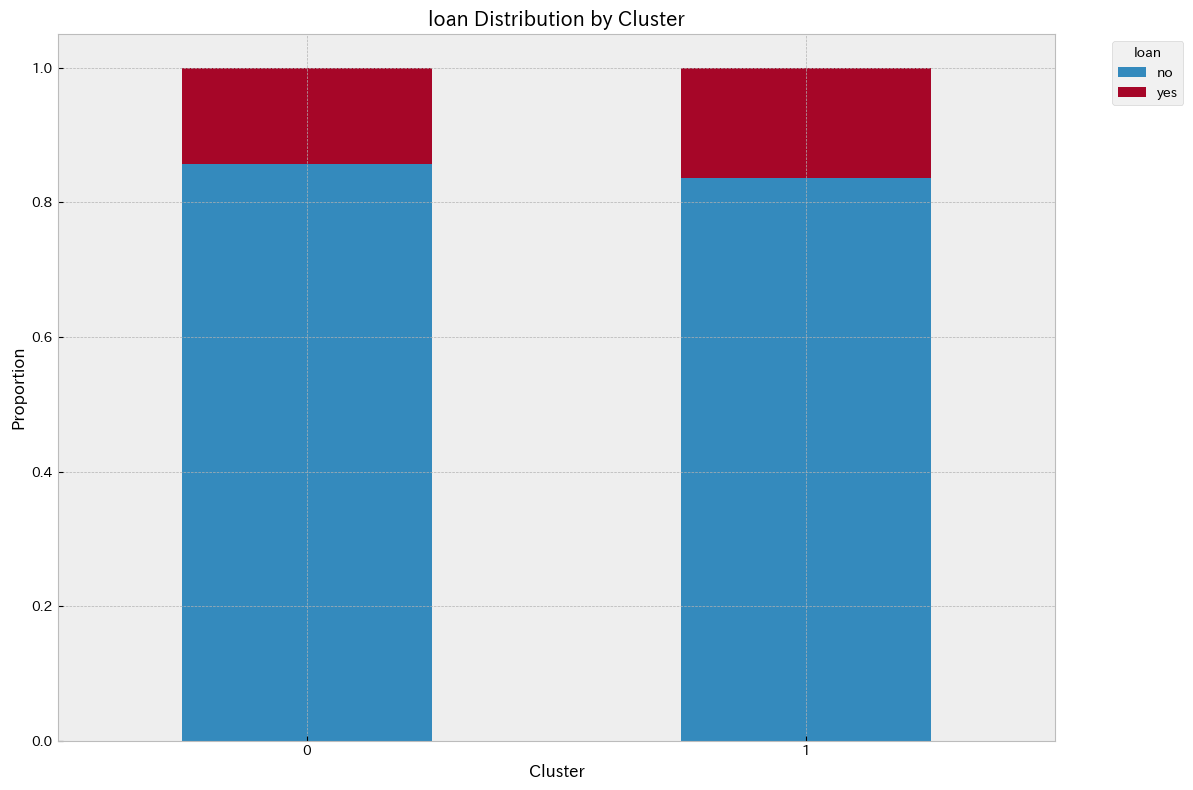

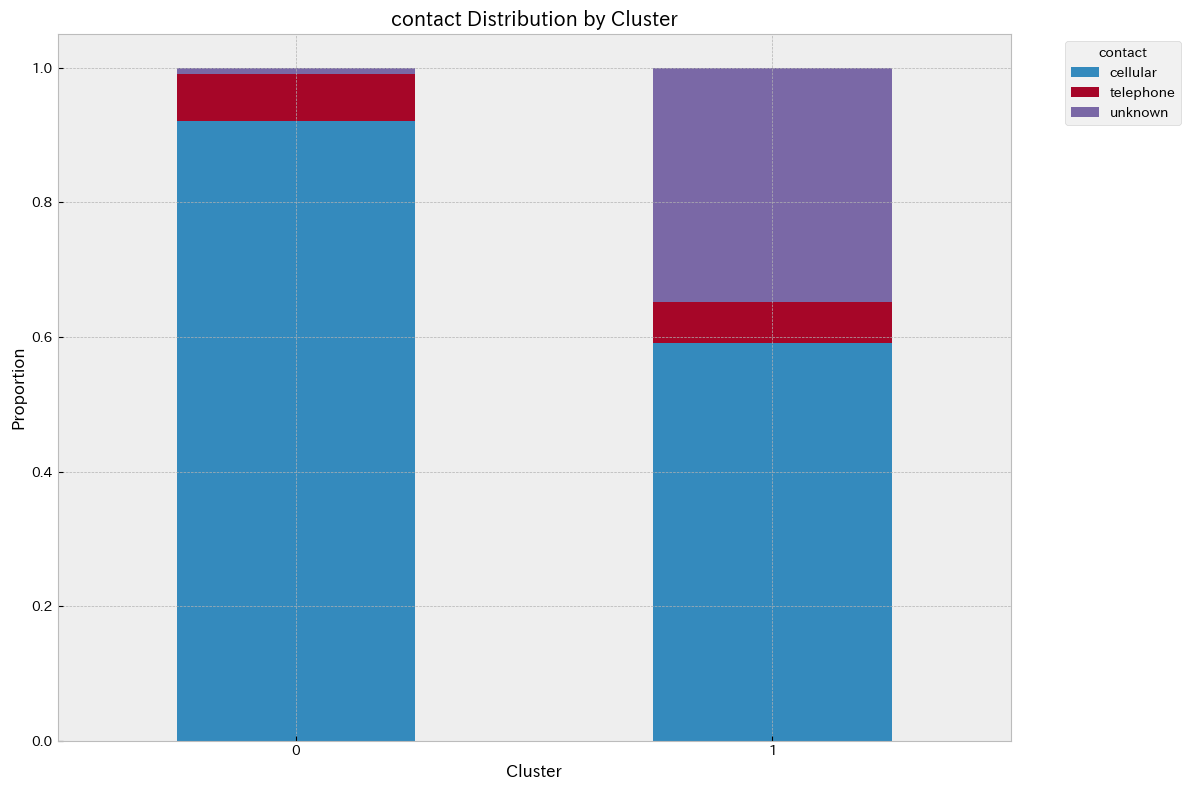

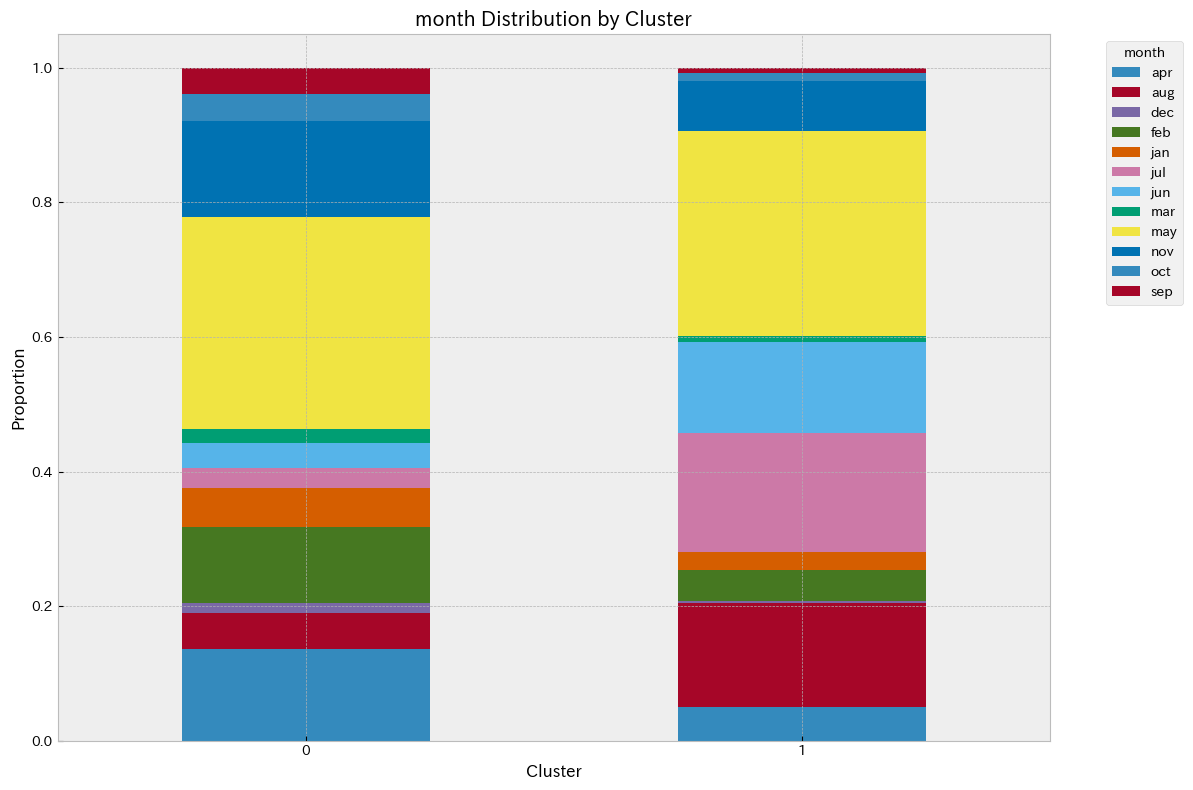

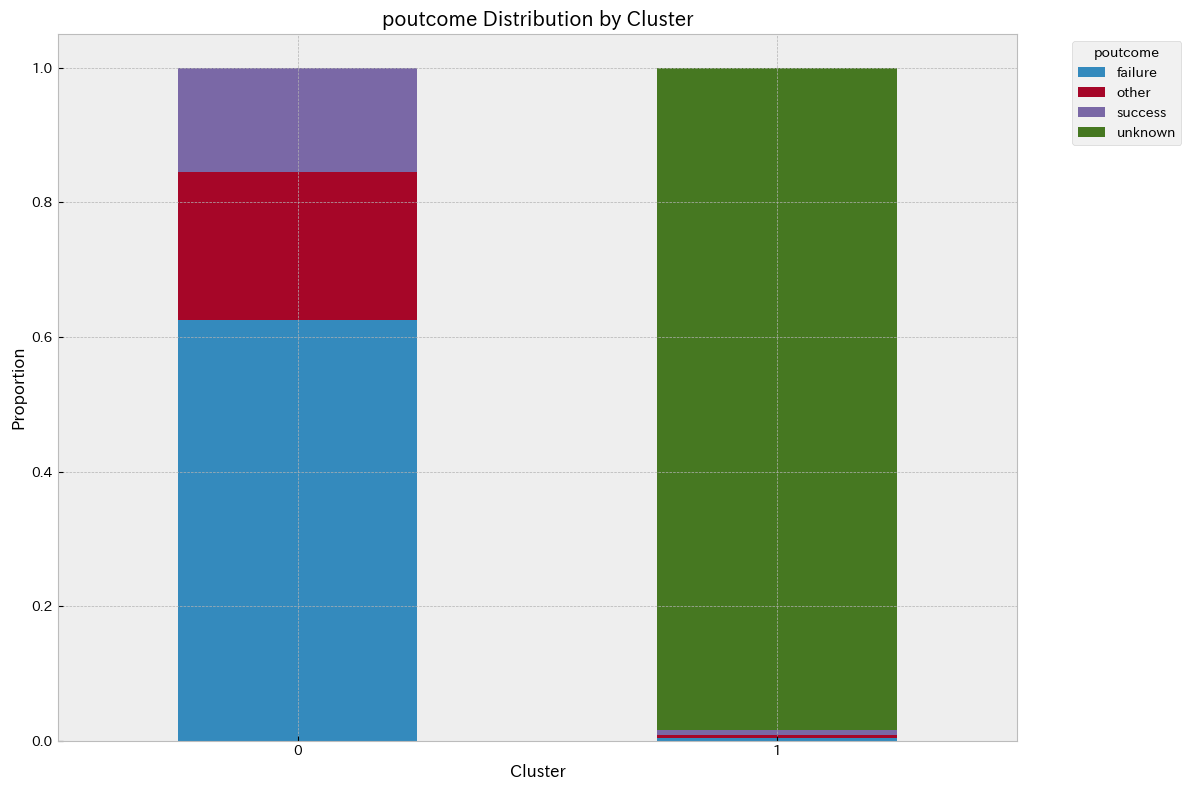

In [ ]:
# カテゴリ型変数の割合をクラスターごとに計算
for col in categorical_features:
    category_distribution = df.groupby('Cluster')[col].value_counts(normalize=True).unstack()

    # 積み上げ棒グラフで可視化
    category_distribution.plot(kind='bar', stacked=True, figsize=(12, 8))
    plt.title(f'{col} Distribution by Cluster')
    plt.ylabel('Proportion')
    plt.xlabel('Cluster')
    plt.xticks(rotation=0)
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


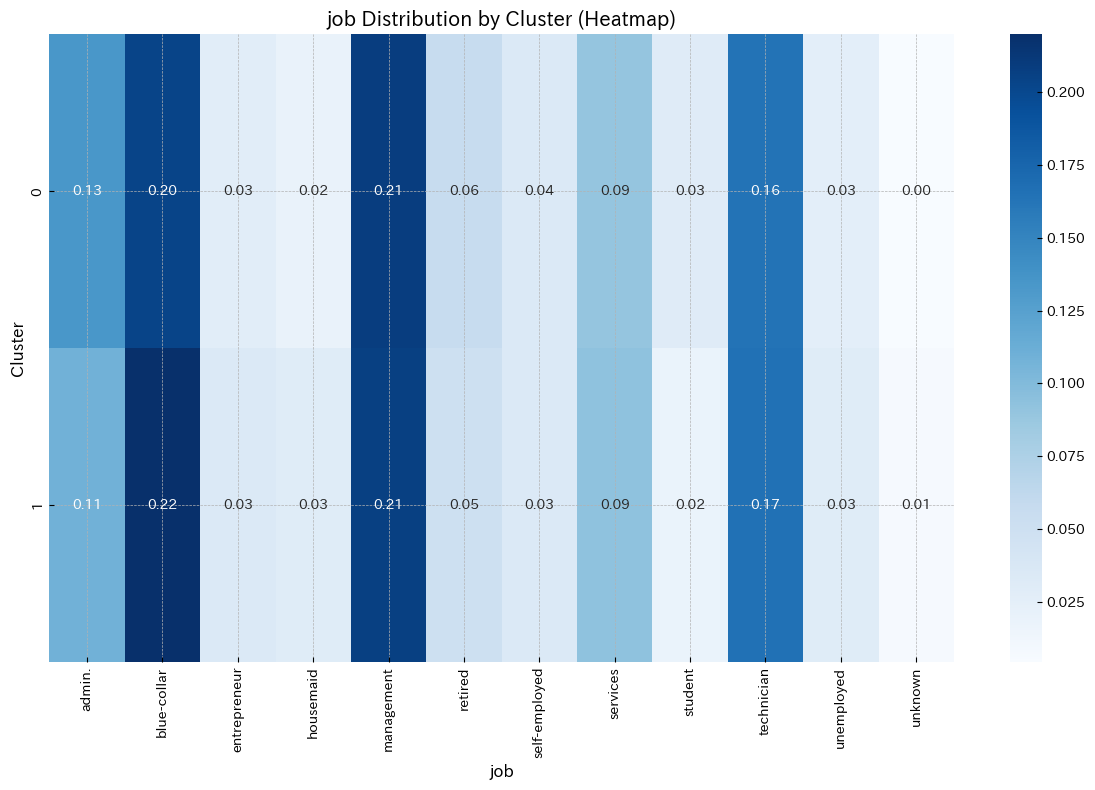

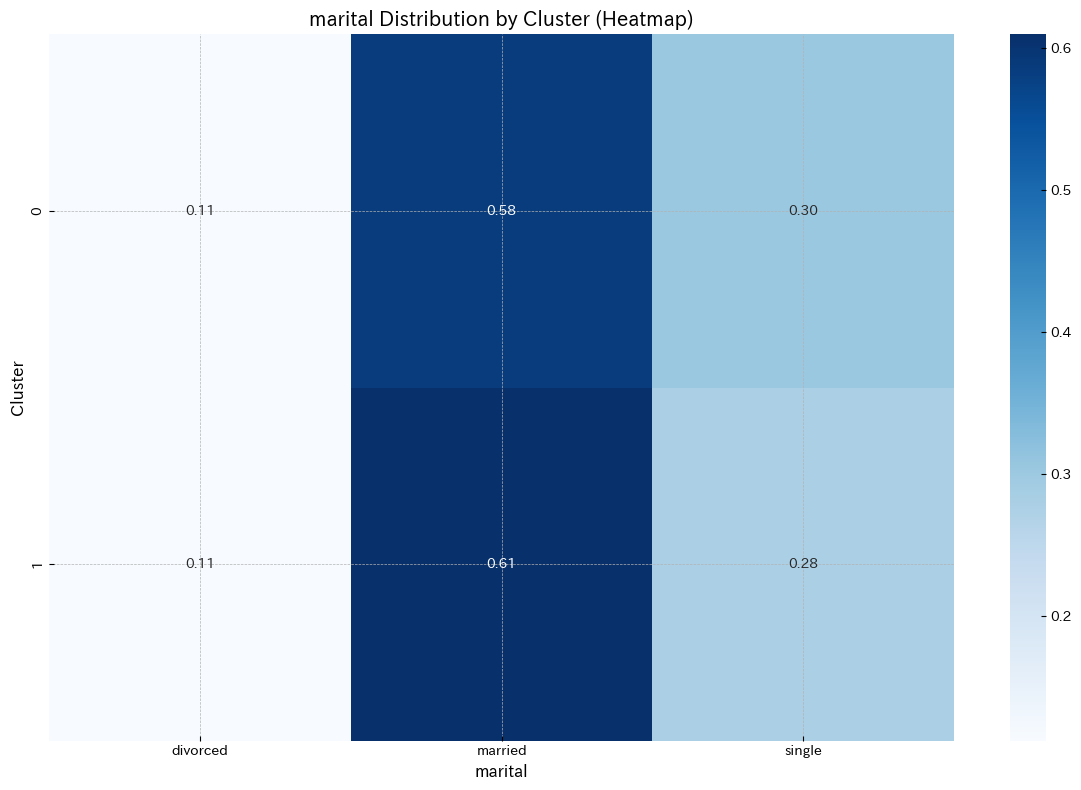

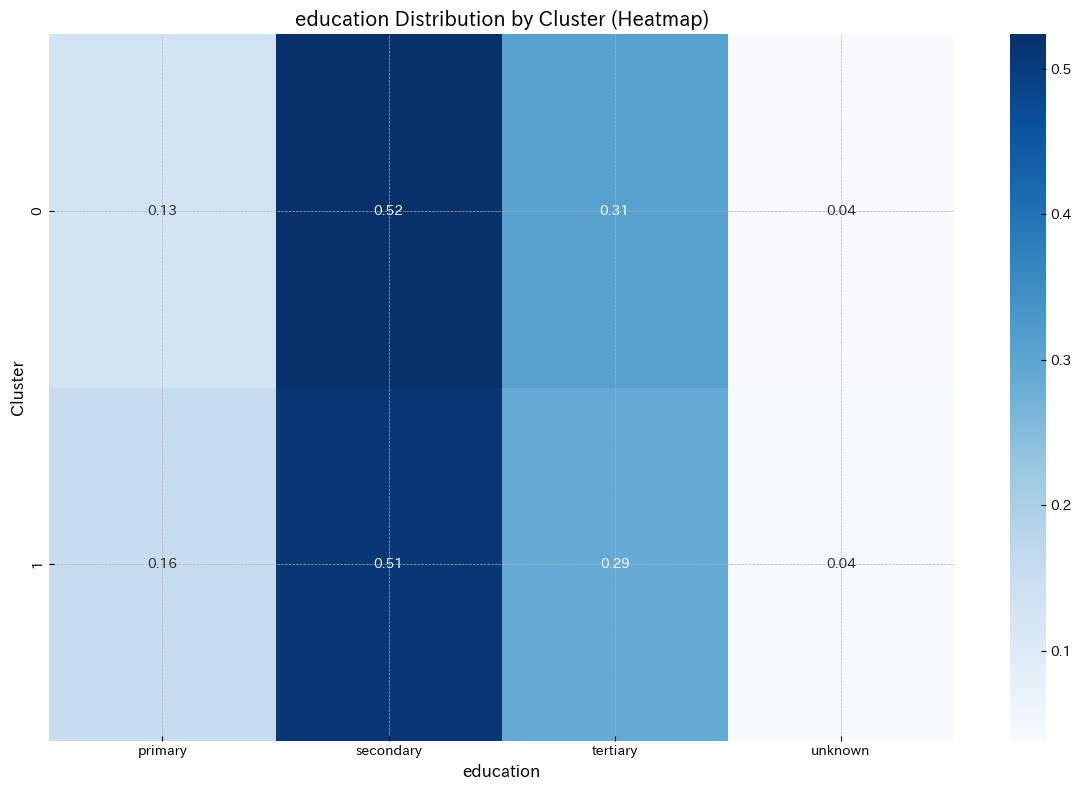

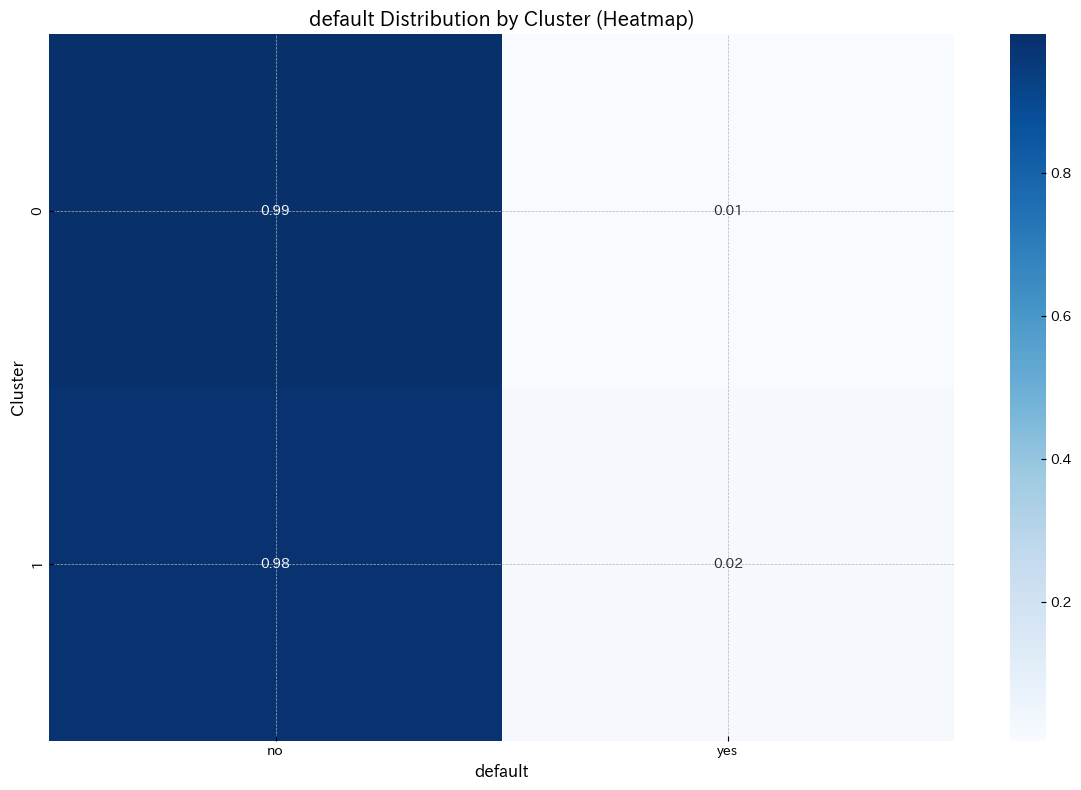

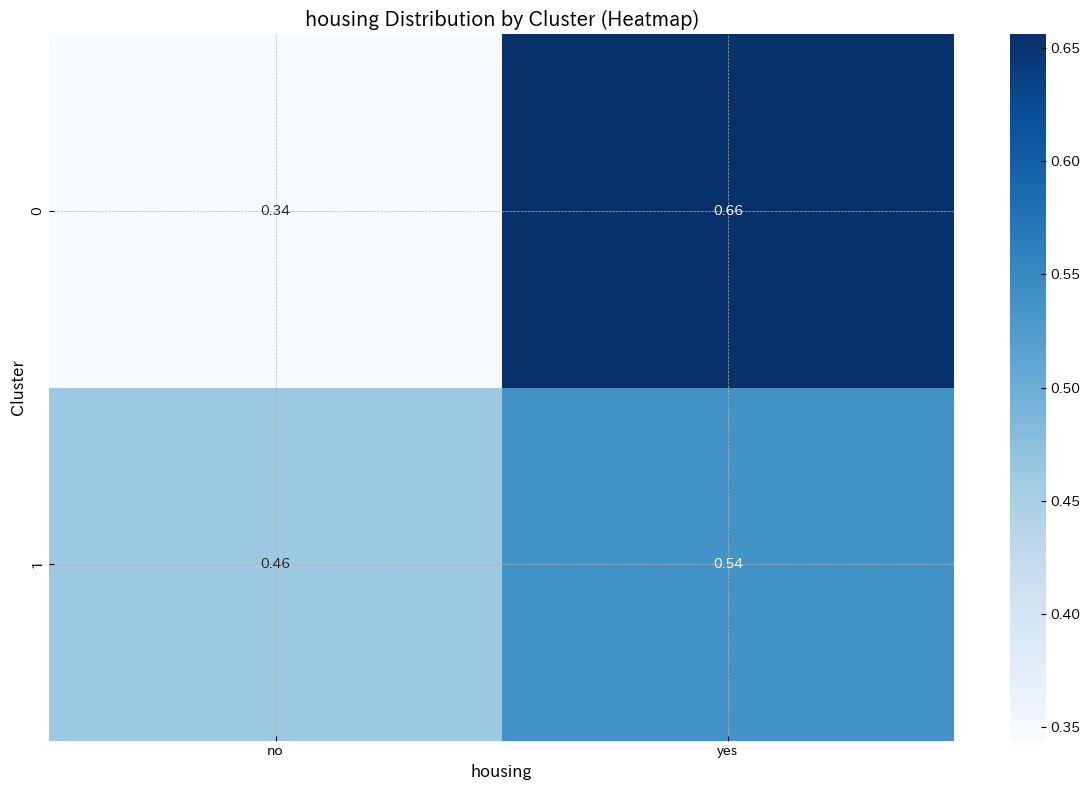

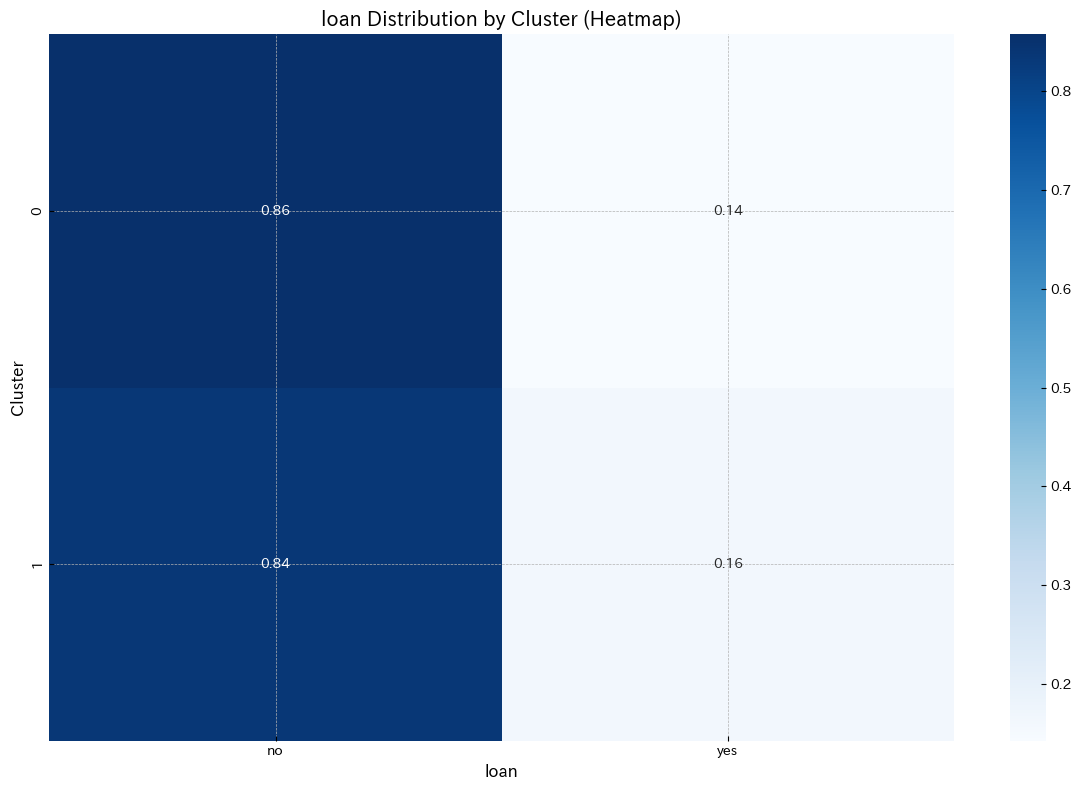

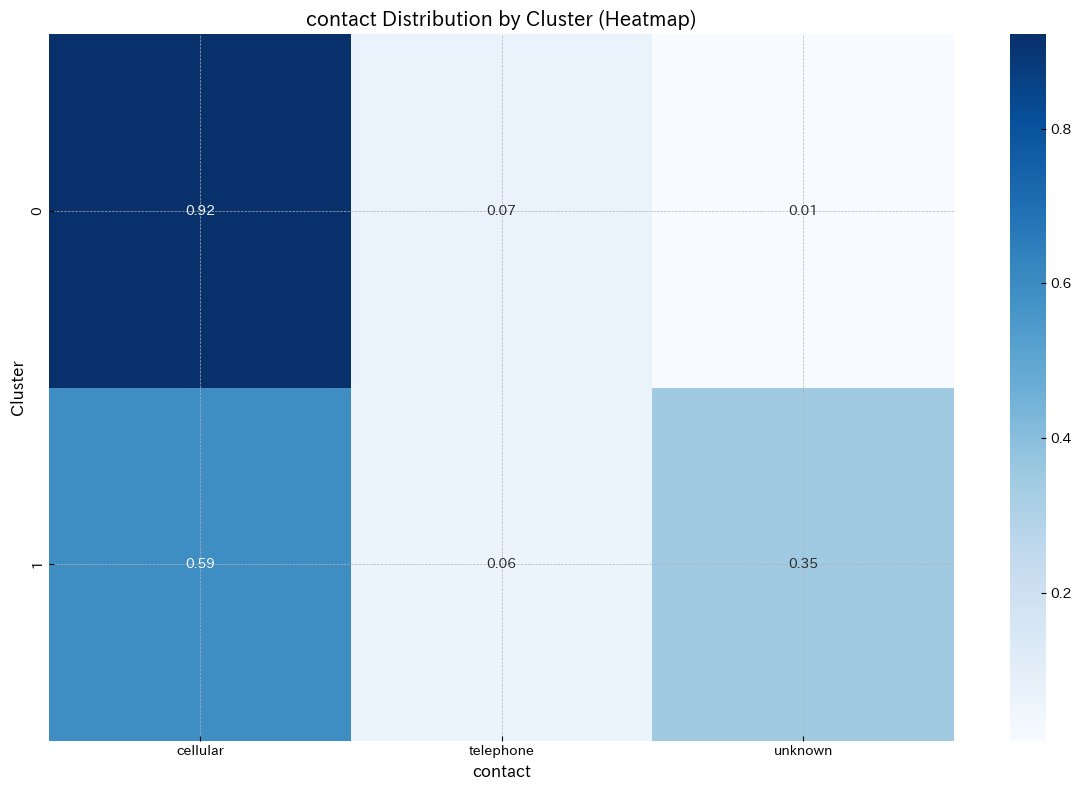

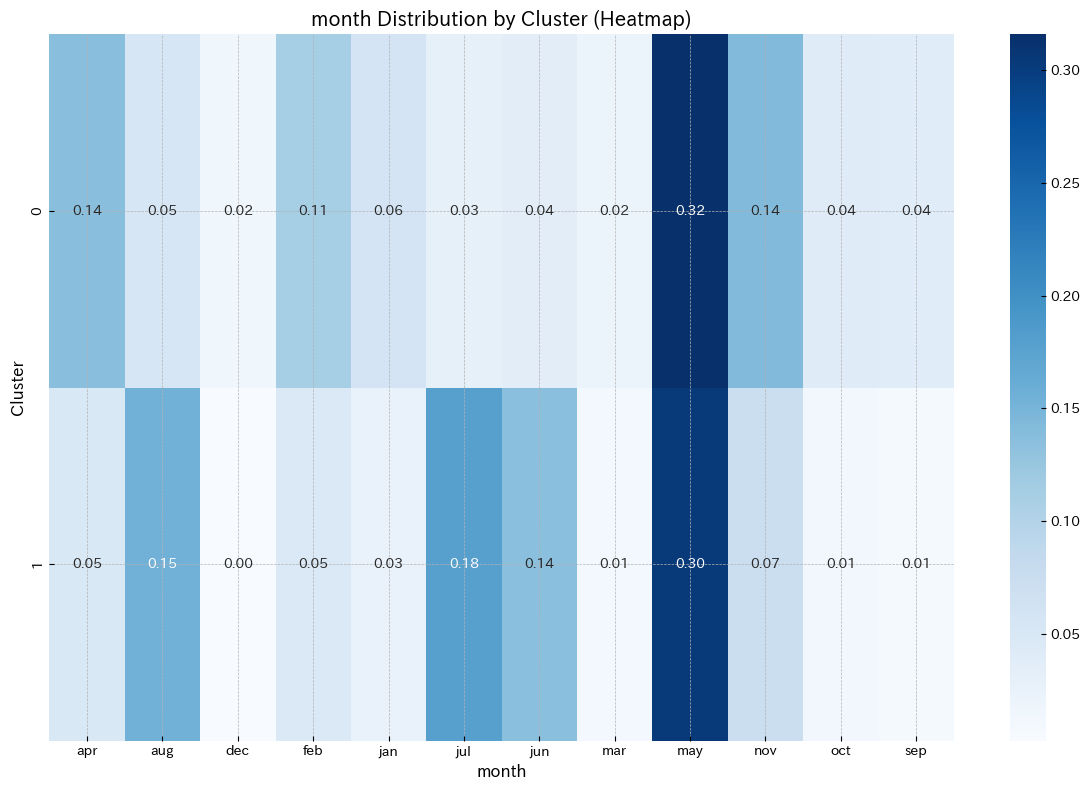

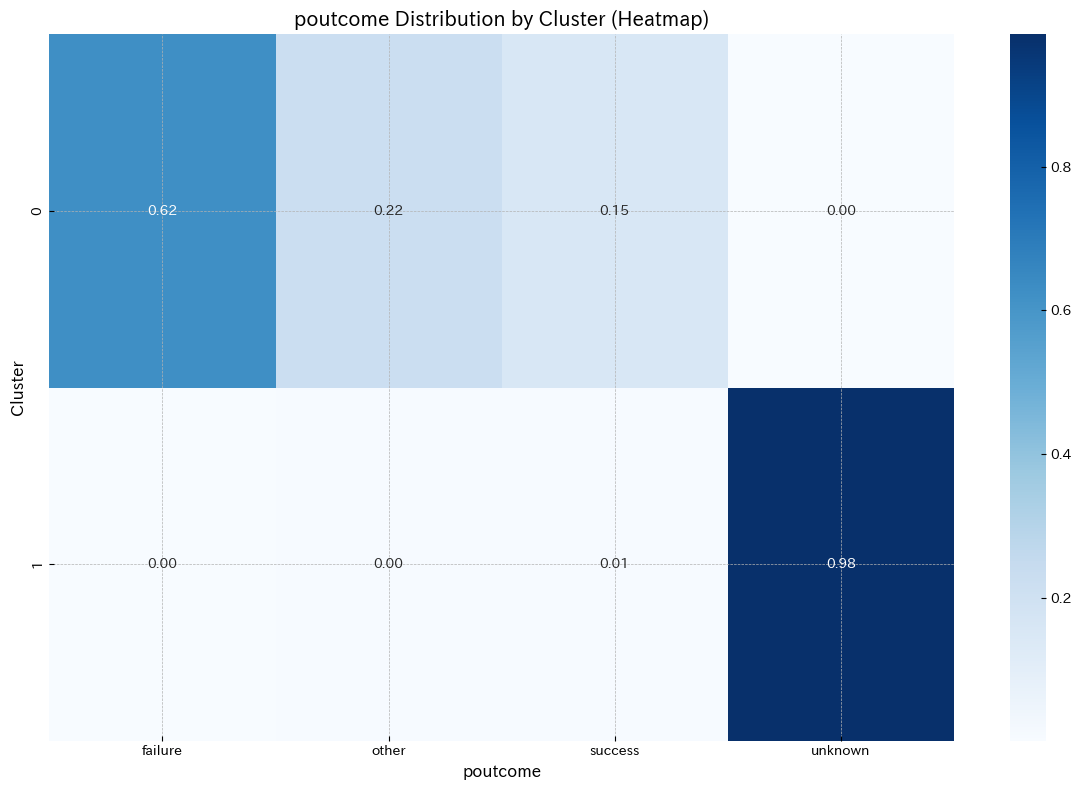

In [ ]:
import seaborn as sns

# カテゴリ型変数の割合をヒートマップで表示
for col in categorical_features:
    category_distribution = df.groupby('Cluster')[col].value_counts(normalize=True).unstack()

    # ヒートマップのプロット
    plt.figure(figsize=(12, 8))
    sns.heatmap(category_distribution, annot=True, cmap='Blues', fmt='.2f')
    plt.title(f'{col} Distribution by Cluster (Heatmap)')
    plt.ylabel('Cluster')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


# 4.商材別のキャンペーン成功確率の試算

## 4-1 モデル作成

In [ ]:
RANDOM_STATE = 42

# 特徴量テーブル（目的変数・idは除外）
features = df.drop(columns=[c for c in ['y', 'x', 'id'] if c in df.columns])

# 目的変数（0/1の整数型に明示）
y = df['y'].astype(int)  # 定期預金
x = df['x'].astype(int)  # NISA

# ---------- 2) 3分割（70%:10%:20% の目安） ----------
# まず 80%:20% で train_eval / test に分割
X_train_eval, X_test, y_train_eval, y_test, x_train_eval, x_test = train_test_split(
    features, y, x, test_size=0.20, random_state=RANDOM_STATE, stratify=y  # 層化は代表で y に合わせる（必要に応じて調整）
)

# 次に train_eval の中から 12.5% を val に（= 全体の約 10%）
X_train, X_val, y_train, y_val, x_train, x_val = train_test_split(
    X_train_eval, y_train_eval, x_train_eval, test_size=0.125, random_state=RANDOM_STATE, stratify=y_train_eval
)

In [ ]:
# 確認（行数が対応しているか確認）
assert len(X_train) == len(y_train) == len(x_train)
assert len(X_val) == len(y_val) == len(x_val)
assert len(X_test) == len(y_test) == len(x_test)

In [ ]:
len(X_train),len(X_val),len(X_test)

(18989, 2713, 5426)

In [ ]:
X_test.head()

age         job   marital  education default  balance housing loan  \
7508    46  technician   married  secondary      no     1465     yes   no   
1390    53  unemployed   married    primary      no       49      no   no   
8383    60     retired  divorced  secondary      no      216     yes   no   
11505   57     retired   married  secondary      no      427      no   no   
20499   35    services   married  secondary      no      372     yes   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
7508    unknown   14   may        86         2     -1         0  unknown   
1390   cellular   27   aug       254         8     -1         0  unknown   
8383    unknown    5   may       238         1     -1         0  unknown   
11505  cellular   29   jan       246         1     -1         0  unknown   
20499  cellular   17   apr       202         2    280         1  failure   

       Cluster  
7508         1  
1390         1  
8383         1  
11505        1  
20499        0

In [ ]:
y_test.head()

7508     0
1390     0
8383     0
11505    0
20499    0
Name: y, dtype: int64

In [ ]:
x_test.head()

7508     0
1390     0
8383     0
11505    0
20499    0
Name: x, dtype: int64

In [ ]:
# ベース学習器（ランダムフォレスト）
def make_base_pipeline():
    # ランダムフォレスト
    rf = RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight='balanced'
    )
    # 前処理＋RF をひとまとめ
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('rf', rf)
    ])

In [ ]:
#  学習（train で学習 → val で確率較正）

from sklearn.calibration import CalibratedClassifierCV

# Yモデル
base_y = make_base_pipeline()
base_y.fit(X_train, y_train)  # 前処理は train の統計量で fit
# 確率較正（val を用いるため prefit 指定）※ sklearn>=1.2 は estimator=
model_y = CalibratedClassifierCV(estimator=base_y, method='sigmoid', cv='prefit')
model_y.fit(X_val, y_val)  # ここで較正（train の学習済み器を val でキャリブレーション）

# Xモデル
base_x = make_base_pipeline()
base_x.fit(X_train, x_train)
model_x = CalibratedClassifierCV(estimator=base_x, method='sigmoid', cv='prefit')
model_x.fit(X_val, x_val)

CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('preprocessor',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   StandardScaler(),
                                                                                   ['age',
                                                                                    'balance',
                                                                                    'day',
                                                                                    'duration',
                                                                                    'campaign',
                                                                                    'pdays',
                                                                                    'previous']),
                                                                                  ('cat',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['job',
                                                                                    'marital',
                                                                                    'education',
                                                                                    'default',
                                                                                    'housing',
                                                                                    'loan',
                                                                                    'contact',
                                                                                    'month',
                                                                                    'poutcome'])])),
                                                 ('rf',
                                                  RandomForestClassifier(class_weight='balanced',
                                                                         n_estimators=300,
                                                                         n_jobs=-1,
                                                                         random_state=42))]))

## 4-2 モデルに基づく予測実績の確認

In [ ]:
# テストデータで確率算出（学習・較正に未使用の集合：X_testに対して）
y_success_prob = model_y.predict_proba(X_test)[:, 1]  # Yの成功確率（定期預金）
x_success_prob = model_x.predict_proba(X_test)[:, 1]  # Xの成功確率（NISA）

# 確率比較と採択（同一対象で比較）
best_prob = np.maximum(y_success_prob, x_success_prob)
choice = np.where(y_success_prob >= x_success_prob, 'Y', 'X')  # 同点は Y 優先（必要に応じて変更）

# レポート整形
report = pd.DataFrame({
    'choice': choice,
    'y_prob_test': y_success_prob,
    'x_prob_test': x_success_prob,
    'best_prob_test': best_prob,
}, index=X_test.index)

# id があれば付与
if 'id' in df.columns:
    report.insert(0, 'id', df.loc[report.index, 'id'].values)

# --- 追加：実際の結果（0/1フラグ）を列として付与 ---
# y_test, x_test が pandas Series なら index で安全に合わせる
y_actual_aligned = y_test.reindex(report.index) if hasattr(y_test, 'reindex') else y_test
x_actual_aligned = x_test.reindex(report.index) if hasattr(x_test, 'reindex') else x_test

report['y_actual'] = pd.Series(y_actual_aligned, index=report.index).astype(int).values
report['x_actual'] = pd.Series(x_actual_aligned, index=report.index).astype(int).values

# 選択側の実現成功（選んだ側の実フラグ）
report['realized_success'] = np.where(report['choice'] == 'Y', report['y_actual'], report['x_actual']).astype(int)

# 確認（先頭表示）
# display(report.head())

In [ ]:
report

id choice  y_prob_test  x_prob_test  best_prob_test  y_actual  \
7508    7509      X     0.026359     0.055179        0.055179         0   
1390    1391      X     0.040060     0.064131        0.064131         0   
8383    8384      X     0.041113     0.056381        0.056381         0   
11505  11506      X     0.050543     0.060139        0.060139         0   
20499  20500      X     0.027783     0.052845        0.052845         0   
...      ...    ...          ...          ...             ...       ...   
229      230      X     0.036101     0.061443        0.061443         0   
10859  10860      X     0.027062     0.049519        0.049519         0   
23591  23592      Y     0.065217     0.049519        0.065217         0   
6083    6084      Y     0.051857     0.048455        0.051857         0   
13910  13911      X     0.042193     0.084429        0.084429         0   

       x_actual  realized_success  
7508          0                 0  
1390          0                 0  
8383          0                 0  
11505         0                 0  
20499         0                 0  
...         ...               ...  
229           0                 0  
10859         0                 0  
23591         0                 0  
6083          0                 0  
13910         0                 0  

[5426 rows x 8 columns]

In [ ]:
# ---------- テストデータにおける Y・X の件数集計（モデル別合計付き） ----------

count_table = pd.DataFrame({
    'Yモデル（定期預金）': report['y_actual'].value_counts().rename({0: '失敗(0)', 1: '成功(1)'}),
    'Xモデル（NISA）': report['x_actual'].value_counts().rename({0: '失敗(0)', 1: '成功(1)'})
}).T.fillna(0).astype(int)

# 各モデル別の合計列（成功＋失敗）
count_table['合計'] = count_table['失敗(0)'] + count_table['成功(1)']

# 結果を表示
display(count_table)

失敗(0)  成功(1)    合計
Yモデル（定期預金）   4791    635  5426
Xモデル（NISA）   4789    637  5426

- テスト対象5426件のうち、Y（定期預金）のキャンペーン成功者は635件、X(NISA口座）の成功者は637件存在している

In [ ]:
# ---------- choice別件数・割合・実際の成功数・成功率 ----------

# choice別の件数・割合
summary = report['choice'].value_counts().to_frame(name='選択件数')
summary['割合(%)'] = (report['choice'].value_counts(normalize=True) * 100).round(2)

# choice別に「実際に成功した件数」を集計
# Yを選んだ場合 → y_actualを参照、Xを選んだ場合 → x_actualを参照
success_by_choice = report.groupby('choice').apply(
    lambda g: (g['y_actual'] if g.name == 'Y' else g['x_actual']).sum()
).to_frame(name='実際の成功件数')

# 合体
summary = summary.merge(success_by_choice, left_index=True, right_index=True)

# 実際の成功率を計算
summary['実際の成功率(%)'] = (
    summary['実際の成功件数'] / summary['選択件数'] * 100
).round(2)

# 結果表示
display(summary)

選択件数  割合(%)  実際の成功件数  実際の成功率(%)
choice                                 
X       4074  75.08      541      13.28
Y       1352  24.92      522      38.61

- モデルは全体の**約75%をNISA（X）**として選択しており、**定期預金（Y）は約25%**と少数。

- しかし、実際の成功率はY（38.6%）がX（13.3%）を大きく上回っている。

- つまり、Yモデルは少数ながら高精度で成果を上げている一方、Xモデルは選択件数が多い割に効果が低い。

- 今後は、Y側の選択を増やす方向で方針を再調整することで、全体成果の向上が期待できる。

## 4-3 モデルの評価

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss

# 確率
p_y = model_y.predict_proba(X_test)[:, 1]  # Y成功確率
p_x = model_x.predict_proba(X_test)[:, 1]  # X成功確率

# ---------- ① 各モデル単体の識別力 ----------
metrics = {
    'ROC-AUC': [roc_auc_score(y_test, p_y), roc_auc_score(x_test, p_x)],
    'PR-AUC': [average_precision_score(y_test, p_y), average_precision_score(x_test, p_x)],
    'LogLoss': [log_loss(y_test, p_y), log_loss(x_test, p_x)]
}

# DataFrame化して表で見やすく
metrics_df = pd.DataFrame(metrics, index=['Yモデル（定期預金）', 'Xモデル（NISA）']).round(4)
display(metrics_df)

ROC-AUC  PR-AUC  LogLoss
Yモデル（定期預金）   0.9225  0.5934   0.2296
Xモデル（NISA）   0.7157  0.4232   0.2896

【評価指標の意味】
 - ROC-AUC（識別力）：0～1で表され、1に近いほど「成功と失敗を正確に区別できる」モデル。
 - PR-AUC（陽性検出力）：陽性（成功）の割合が少ない場合でも、どれだけ正しく当てられているかを示す。
 - LogLoss（確率の信頼性）：小さいほど、予測確率が実際の結果に近い（＝確率の出し方が適切）。

【結果の解釈】
- Yモデル（定期預金）
  - ROC-AUC：0.9225 → 成功／失敗の識別性能が非常に高い。
  - PR-AUC：0.5934 → 成功者を精度良く検出できている。
  - LogLoss：0.2296 → 出力する確率の信頼性も高い。

- Xモデル（NISA）
  - ROC-AUC：0.7157 → 識別力は一定あるが、Yモデルより弱い。
  - PR-AUC：0.4232 → 成功者を見つける精度はやや低い。
  - LogLoss：0.2896 → 確率出力の精度は改善余地あり。

【総評】
- Yモデルは識別力・検出力・確率の安定性いずれもXモデルを上回っており、より実務的に信頼できるモデルといえる。

Brierスコア
モデル                 
Yモデル（定期預金）    0.0691
Xモデル（NISA）    0.0790

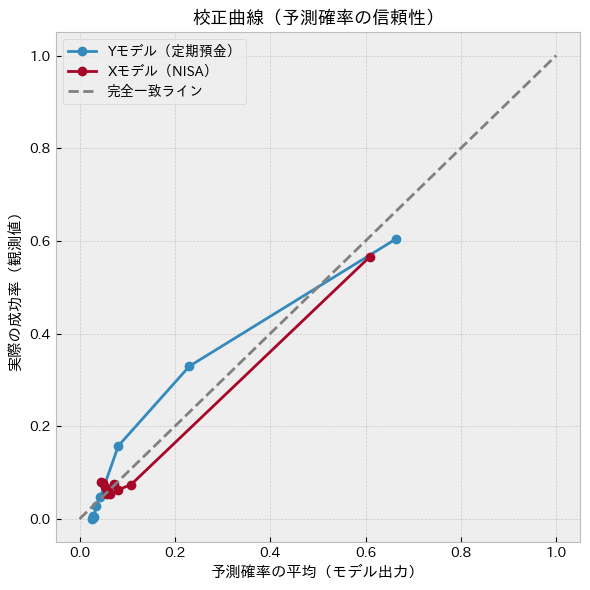


※ 校正曲線では、点が45度線（完全一致）に近いほど“確率の出し方が現実に即している”ことを示します。


In [ ]:
# ---------- ② 確率の信頼性（Brierスコア） ----------
y_brier = brier_score_loss(y_test, p_y)
x_brier = brier_score_loss(x_test, p_x)

# 表形式で出力
brier_df = pd.DataFrame({
    'モデル': ['Yモデル（定期預金）', 'Xモデル（NISA）'],
    'Brierスコア': [y_brier, x_brier]
}).set_index('モデル').round(4)

display(brier_df)

# ---------- 2) 校正曲線（Calibration Curve） ----------
# quantile方式：各ビンに均等にサンプルを入れる
prob_true_y, prob_pred_y = calibration_curve(y_test, p_y, n_bins=10, strategy='quantile')
prob_true_x, prob_pred_x = calibration_curve(x_test, p_x, n_bins=10, strategy='quantile')

# ---------- 3) 可視化 ----------
plt.figure(figsize=(6,6))
plt.plot(prob_pred_y, prob_true_y, marker='o', label='Yモデル（定期預金）')
plt.plot(prob_pred_x, prob_true_x, marker='o', label='Xモデル（NISA）')

# 完全一致ライン（理想線）
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='完全一致ライン')

plt.xlabel('予測確率の平均（モデル出力）', fontsize=11)
plt.ylabel('実際の成功率（観測値）', fontsize=11)
plt.title('校正曲線（予測確率の信頼性）', fontsize=13)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
print("\n※ 校正曲線では、点が45度線（完全一致）に近いほど“確率の出し方が現実に即している”ことを示します。")

- Brierスコアが低いほど確率の信頼性が高い（予測確率と実際が一致）
- 今回はYモデル(0.069) < Xモデル(0.079) なので、Yモデルの方が「確率の出し方が現実に近く、信頼性が高い」といえる。

In [ ]:
# ---------- ③ 方針（X/Yの採択）の有効性 ----------
# 予測ベースの選択（同点はY優先：>=）
choose_Y = p_y >= p_x
choose_X = ~choose_Y

# 実現成功（選択側の真値で評価）
# ・Yを選んだ行は y_test を採用
# ・Xを選んだ行は x_test を採用
realized_success = np.where(choose_Y, y_test.values, x_test.values)
policy_success_rate = realized_success.mean()

# ベースライン比較
always_y_rate = y_test.mean()
always_x_rate = x_test.mean()
random_rate = 0.5 * y_test.mean() + 0.5 * x_test.mean()

# “正しい選択”率（ビジネス価値が同等の場合）
# 真に優先すべき側：y_test > x_test → Y、x_test > y_test → X、同点は除外 or 引き分け
true_pref_y = y_test.values > x_test.values
true_pref_x = x_test.values > y_test.values
mask_decidable = true_pref_y | true_pref_x  # 同点を除外

pred_pref_y = choose_Y
pred_pref_x = choose_X

decision_accuracy = ( (pred_pref_y & true_pref_y) | (pred_pref_x & true_pref_x) )[mask_decidable].mean()

# （任意）重み付き利得：例えば Y=¥1.0, X=¥0.8 の価値と仮定
val_y, val_x = 1.0, 0.8
realized_value = np.where(choose_Y, y_test.values * val_y, x_test.values * val_x)
expected_value = realized_value.mean()
baseline_value_y = y_test.values.mean() * val_y
baseline_value_x = x_test.values.mean() * val_x

# （任意）Top-N分析：上位N件だけ配信する場合の精度
N = 1000  # 例：上位1000件
best_prob = np.maximum(p_y, p_x)
top_idx = np.argsort(-best_prob)[:N]
top_realized = realized_success[top_idx].mean()

# --- ここから表整形 ---
summary = pd.DataFrame({
    "値": [
        policy_success_rate,
        always_y_rate,
        always_x_rate,
        random_rate,
        policy_success_rate - max(always_y_rate, always_x_rate),
        decision_accuracy,
        expected_value,
        baseline_value_y,
        baseline_value_x,
        N,
        top_realized
    ]
}, index=[
    "Policy成功率（確率高い方採択）",
    "Baseline：Always Y",
    "Baseline：Always X",
    "Baseline：Random 50/50",
    "Lift（vs ベストBaseline）",
    "“正しい選択”率（同点除外）",
    "期待値：Policy（Y=1.0, X=0.8）",
    "期待値：Always Y",
    "期待値：Always X",
    "TopN（件数）",
    "TopN成功率"
])

percent_rows = [
    "Policy成功率（確率高い方採択）",
    "Baseline：Always Y",
    "Baseline：Always X",
    "Baseline：Random 50/50",
    "Lift（vs ベストBaseline）",
    "“正しい選択”率（同点除外）",
    "TopN成功率"
]
summary_pct = summary_display.copy()
summary_pct.loc[percent_rows, "値"] = (summary_pct.loc[percent_rows, "値"].astype(float) * 100).round(2).astype(str) + "%"
display(summary_pct)

値
Policy成功率（確率高い方採択）          19.59%
Baseline：Always Y            11.7%
Baseline：Always X           11.74%
Baseline：Random 50/50       11.72%
Lift（vs ベストBaseline）         7.85%
“正しい選択”率（同点除外）              87.99%
期待値：Policy（Y=1.0, X=0.8）  0.175968
期待値：Always Y              0.117029
期待値：Always X              0.093918
TopN（件数）                    1000.0
TopN成功率                      61.6%

- モデル方針（確率の高い方を採択）は、成功率で約8ポイント改善しており有効。
- 選択精度も約88%と高く、確率ベースの判断が現実的に当たっている。
- TopN分析でも成功率61.6%と高く、優先顧客リストの抽出にも有用。
- → 総じて、Y/Xモデルの組み合わせによる統合施策は高い実用性を示している。

In [ ]:
# ===========================================
# 有用性を図示：ROC/PR/キャリブレーション/方針比較/累積成功率/Top-N
# ===========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    brier_score_loss, log_loss
)
from sklearn.calibration import calibration_curve

def visualize_policy_usefulness(X_test, y_test, x_test, model_y, model_x, topN_list=(200, 500, 1000, 2000)):
    # ---------- 0) 安全チェック ----------
    # 必要なオブジェクトが揃っているか確認
    if any(obj is None for obj in [X_test, y_test, x_test, model_y, model_x]):
        raise ValueError("X_test, y_test, x_test, model_y, model_x のいずれかが未定義です。")

    # ---------- 1) 予測確率 ----------
    # 各モデルのテスト集合に対する成功確率
    p_y = model_y.predict_proba(X_test)[:, 1]
    p_x = model_x.predict_proba(X_test)[:, 1]

    # 採択ルール（確率の高い方を採択）
    choose_Y = p_y >= p_x
    choose_X = ~choose_Y
    realized_success = np.where(choose_Y, y_test.values, x_test.values)  # 実現成功
    best_prob = np.maximum(p_y, p_x)

    # ---------- 2) 主要メトリクス ----------
    # ROC
    fpr_y, tpr_y, _ = roc_curve(y_test, p_y)
    roc_auc_y = auc(fpr_y, tpr_y)
    fpr_x, tpr_x, _ = roc_curve(x_test, p_x)
    roc_auc_x = auc(fpr_x, tpr_x)

    # PR
    precision_y, recall_y, _ = precision_recall_curve(y_test, p_y)
    ap_y = average_precision_score(y_test, p_y)
    precision_x, recall_x, _ = precision_recall_curve(x_test, p_x)
    ap_x = average_precision_score(x_test, p_x)

    # 信頼性（Brier, LogLoss）
    y_brier = brier_score_loss(y_test, p_y)
    x_brier = brier_score_loss(x_test, p_x)
    y_ll = log_loss(y_test, p_y)
    x_ll = log_loss(x_test, p_x)

    # 方針成功率とベースライン
    policy_success_rate = realized_success.mean()
    always_y = y_test.mean()
    always_x = x_test.mean()
    random_base = 0.5 * always_y + 0.5 * always_x
    lift_vs_best = policy_success_rate - max(always_y, always_x)

    # ---------- 3) 主要指標の表 ----------
    metrics_dict = {
        "y_auc": roc_auc_y,
        "y_pr_auc": ap_y,
        "y_logloss": y_ll,
        "x_auc": roc_auc_x,
        "x_pr_auc": ap_x,
        "x_logloss": x_ll,
        "y_brier": y_brier,
        "x_brier": x_brier,
        "policy_success_rate": policy_success_rate,
        "baseline_always_y": always_y,
        "baseline_always_x": always_x,
        "baseline_random": random_base,
        "lift_vs_best_baseline": lift_vs_best
    }
    metrics_df = pd.DataFrame(metrics_dict, index=["value"]).T.round(6)
    print("主要評価指標（モデル性能・較正・方針の有効性）")
    display(metrics_df)

    # ---------- 4) 図：ROC曲線（YとX） ----------
    plt.figure(figsize=(6, 5))
    # ROCは対角線からの上方乖離が大きいほど良い
    plt.plot(fpr_y, tpr_y, label=f"Y ROC-AUC = {roc_auc_y:.3f}")
    plt.plot(fpr_x, tpr_x, label=f"X ROC-AUC = {roc_auc_x:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", label="ランダム")
    plt.xlabel("偽陽性率 (FPR)")
    plt.ylabel("真陽性率 (TPR)")
    plt.title("ROC曲線（YとXの比較）")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # ---------- 5) 図：PR曲線（YとX） ----------
    plt.figure(figsize=(6, 5))
    plt.plot(recall_y, precision_y, label=f"Y PR-AUC = {ap_y:.3f}")
    plt.plot(recall_x, precision_x, label=f"X PR-AUC = {ap_x:.3f}")
    base_y = y_test.mean()
    plt.hlines(base_y, 0, 1, linestyles="--", label=f"Y陽性比={base_y:.3f}")
    plt.xlabel("再現率 (Recall)")
    plt.ylabel("適合率 (Precision)")
    plt.title("PR曲線（陽性が少ない場合の性能確認）")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    # ---------- 6) 図：キャリブレーションカーブ ----------
    # 予測確率と実際の成功率が一致しているか（対角線に近いほど良い）
    prob_true_y, prob_pred_y = calibration_curve(y_test, p_y, n_bins=10, strategy="quantile")
    prob_true_x, prob_pred_x = calibration_curve(x_test, p_x, n_bins=10, strategy="quantile")

    plt.figure(figsize=(6, 5))
    plt.plot(prob_pred_y, prob_true_y, marker="o", label="Y")
    plt.plot(prob_pred_x, prob_true_x, marker="o", label="X")
    plt.plot([0, 1], [0, 1], linestyle="--", label="完全一致")
    plt.xlabel("予測確率（ビン平均）")
    plt.ylabel("実際の成功率（ビン平均）")
    plt.title("キャリブレーションカーブ（確率の信頼性）")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

    # ---------- 7) 図：方針の有効性（成功率の棒グラフ） ----------
    labels = ["Policy（確率高い方）", "Always Y", "Always X", "Random 50/50"]
    values = [policy_success_rate, always_y, always_x, random_base]

    plt.figure(figsize=(6, 5))
    plt.bar(labels, values)
    plt.ylabel("成功率")
    plt.title("方針の有効性（成功率の比較）")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

    # ---------- 8) 図：累積成功率（Gainsの簡易版） ----------
    # best_probの高い順に並べ、上位から積み上げたときの累積成功率を描く
    order = np.argsort(-best_prob)
    cum_success = np.cumsum(realized_success[order])
    cum_rate = cum_success / np.arange(1, len(cum_success) + 1)

    plt.figure(figsize=(6, 5))
    plt.plot(np.linspace(0, 100, len(cum_rate)), cum_rate, label="Policy（best_prob順）")
    plt.hlines(policy_success_rate, 0, 100, linestyles="--", label=f"全体平均={policy_success_rate:.3f}")
    plt.xlabel("上位%（best_probでソート）")
    plt.ylabel("累積成功率")
    plt.title("累積成功率カーブ（上位ほど当たりが濃いか）")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # ---------- 9) 図：Top-N 成功率 ----------
    # 上位N件だけ配信する場合の実績成功率を比較
    top_rates = []
    for N in topN_list:
        idx = order[:N]
        top_rates.append(realized_success[idx].mean())

    plt.figure(figsize=(6, 5))
    plt.bar([str(n) for n in topN_list], top_rates)
    plt.ylabel("成功率")
    plt.title("Top-N 成功率（best_prob上位のみ配信）")
    plt.tight_layout()
    plt.show()

    # 戻り値：表と一部数値（必要に応じて利用）
    summary = {
        "metrics_df": metrics_df,
        "policy_success_rate": policy_success_rate,
        "topN_list": list(topN_list),
        "topN_rates": top_rates
    }
    return summary

主要評価指標（モデル性能・較正・方針の有効性）


value
y_auc                  0.922517
y_pr_auc               0.593384
y_logloss              0.229615
x_auc                  0.715731
x_pr_auc               0.423244
x_logloss              0.289585
y_brier                0.069129
x_brier                0.079008
policy_success_rate    0.195909
baseline_always_y      0.117029
baseline_always_x      0.117398
baseline_random        0.117213
lift_vs_best_baseline  0.078511

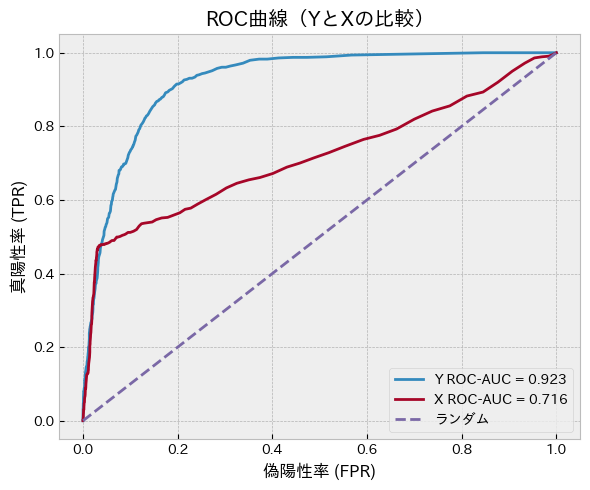

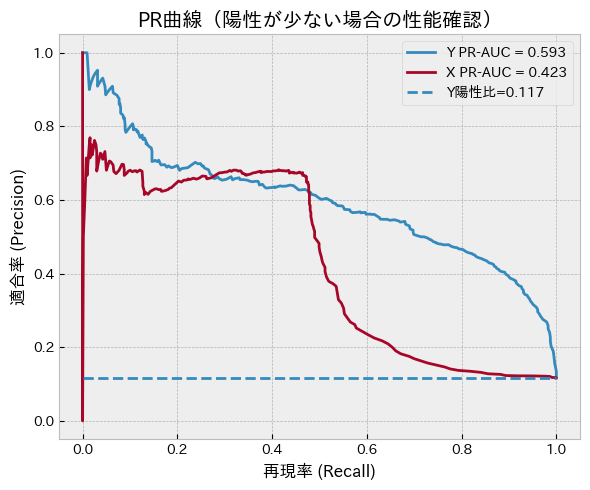

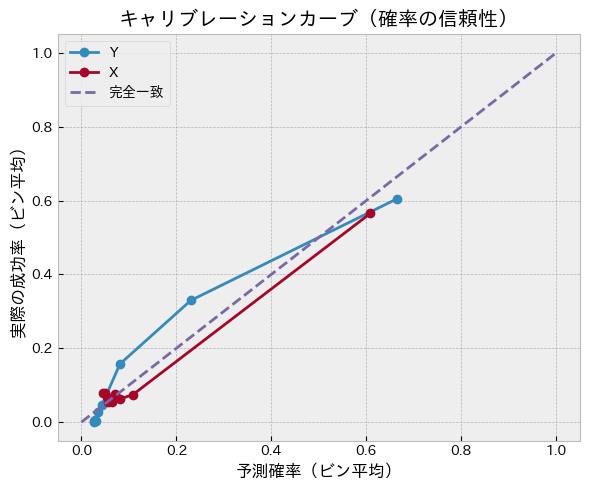

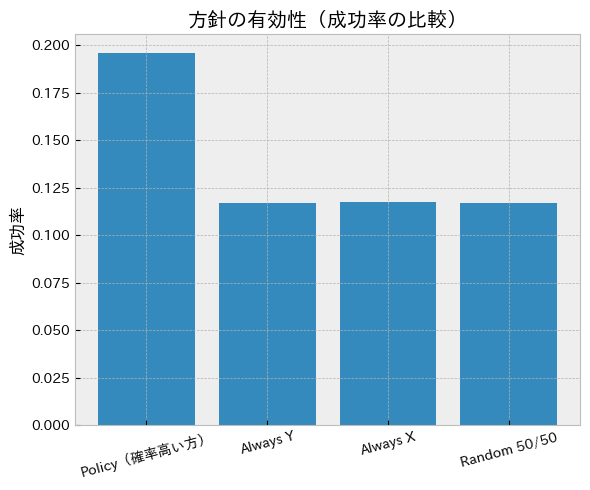

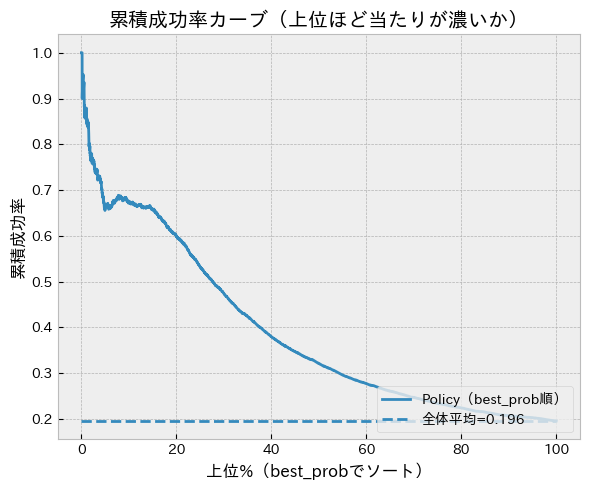

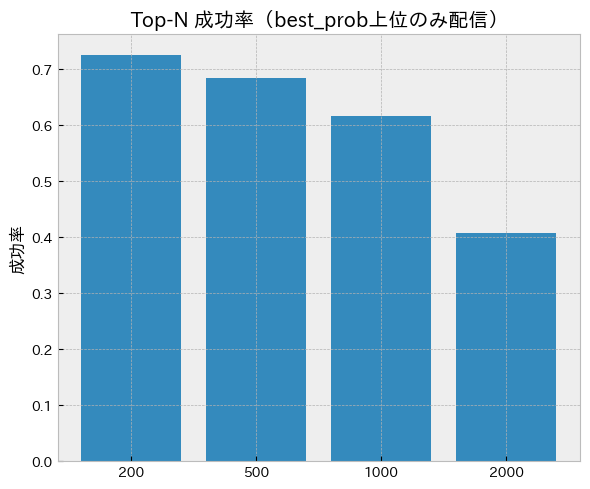

In [ ]:
summary = visualize_policy_usefulness(X_test, y_test, x_test, model_y, model_x)

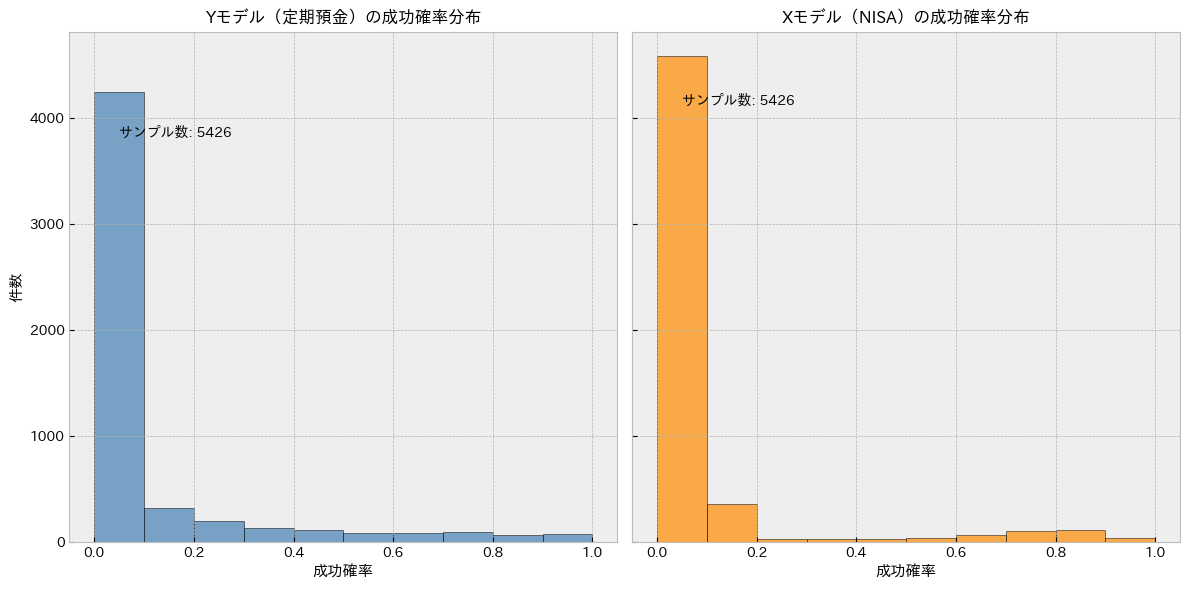

In [ ]:
# モデル別の成功確率分布の確認

# 列名の確認（存在チェック）
assert 'y_prob_test' in report.columns, "reportに 'y_prob_test' が存在しません。"
assert 'x_prob_test' in report.columns, "reportに 'x_prob_test' が存在しません。"

# ---------- 可視化処理 ----------
bins = np.arange(0, 1.1, 0.1)  # 0〜1を10%刻み

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# yモデルの成功確率分布
y_counts, _, _ = axes[0].hist(
    report['y_prob_test'], bins=bins, alpha=0.7,
    color='steelblue', edgecolor='black'
)
axes[0].set_title('Yモデル（定期預金）の成功確率分布', fontsize=12)
axes[0].set_xlabel('成功確率', fontsize=11)
axes[0].set_ylabel('件数', fontsize=11)
axes[0].text(0.05, max(y_counts)*0.9,
             f"サンプル数: {len(report['y_prob_test'])}",
             fontsize=10, color='black')

# xモデルの成功確率分布
x_counts, _, _ = axes[1].hist(
    report['x_prob_test'], bins=bins, alpha=0.7,
    color='darkorange', edgecolor='black'
)
axes[1].set_title('Xモデル（NISA）の成功確率分布', fontsize=12)
axes[1].set_xlabel('成功確率', fontsize=11)
axes[1].text(0.05, max(x_counts)*0.9,
             f"サンプル数: {len(report['x_prob_test'])}",
             fontsize=10, color='black')

plt.tight_layout()
plt.show()

In [ ]:
# 予測確率TOP10対象の確認

# 列存在チェック
assert 'x_prob_test' in report.columns, "reportに 'x_prob_test' が存在しません。"
assert 'y_prob_test' in report.columns, "reportに 'y_prob_test' が存在しません。"
assert len(X_test) == len(x_test) == len(y_test), "X_test, x_test, y_test の行数が一致しません。"

# 実際の結果（0/1）を report に追加
report_with_flags = report.copy()
report_with_flags['x_actual'] = x_test.values
report_with_flags['y_actual'] = y_test.values

# preferred_product がない場合は choice を使う
if 'preferred_product' not in report_with_flags.columns:
    report_with_flags['preferred_product'] = report_with_flags['choice']

# ---------- 上位10件抽出 ----------
top_10_x = report_with_flags.nlargest(10, 'x_prob_test')[
    ['id', 'x_prob_test', 'y_prob_test', 'x_actual', 'y_actual', 'choice']
]

top_10_y = report_with_flags.nlargest(10, 'y_prob_test')[
    ['id', 'x_prob_test', 'y_prob_test', 'x_actual', 'y_actual', 'choice']
]

# ---------- 結果表示 ----------
print("=== Top 10 customers with highest X (NISA) success probability ===")
display(top_10_x.style.format({
    'x_prob_test': '{:.3f}', 'y_prob_test': '{:.3f}'
}).set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]))

print("\n=== Top 10 customers with highest Y (定期預金) success probability ===")
display(top_10_y.style.format({
    'x_prob_test': '{:.3f}', 'y_prob_test': '{:.3f}'
}).set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]))

=== Top 10 customers with highest X (NISA) success probability ===



=== Top 10 customers with highest Y (定期預金) success probability ===


- Xモデル（NISA）上位10件の傾向
  - すべての顧客で x_prob_test（NISA成功確率）が0.93〜0.95と非常に高い。
  - しかし実際には、x_actual＝1（成功）は7件、y_actual＝1（定期預金成功）は3件あり、一部で「NISAを勧めたが実際は定期預金が成立した」ケースも見られる。
  - 特に ID18723 の顧客では、モデルはNISA成功確率0.949と判断した一方で、実際には 定期預金（Y）が成立しており、過信傾向も一部確認される。
  - それでも多数の顧客で予測通りの成果（x_actual=1）が得られており、上位層の信頼性はおおむね良好

- Yモデル（定期預金）上位10件の傾向
  - すべての顧客で y_prob_testが0.97〜0.98と極めて高い。
    - 実際には、y_actual＝1（定期預金成功）9件／10件 と、非常に高い的中率。
    - x_actual＝1（NISA成功）はほぼなし（0件）。
  - 唯一 ID13157 の顧客では両方とも不成立（x_actual=0, y_actual=0）だが、ほか9件は全てY成功。
  - Yモデルは「定期預金の成功確率が高い顧客」を非常に正確に特定できており、上位層の予測精度は極めて高い。高確率帯での的中率がほぼ100%であることから、確率出力の信頼性・識別力ともに優秀。